<a href="https://colab.research.google.com/github/EndhyP/Tugas_Akhir/blob/main/Latihan/NasaBearingTF/NASA_Bearing_Dataset_3_SVR_(Gaussian%2C_Exponential%2C_Holts%2C_Savitzky).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [155]:
# Import modul untuk akses dataset, mengakses dataframe, dan visualisasi
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy
from scipy.special import entr
from scipy.io import loadmat
from scipy.signal import stft
from scipy.stats import kurtosis
from mpl_toolkits.mplot3d import Axes3D
import math
import seaborn as sns
!pip install lifelines
from lifelines import CoxPHFitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocessing Data

## Import Data path

Pada bagian ini beberapa features statistik berbasis sinyal telah diekstraksi dari data

**Definisi dan formula dari features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:*** 
Asimetri distribusi sinyal. Kesalahan dapat memengaruhi simetri distribusi dan karenanya meningkatkan tingkat skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Panjang ekor distribusi sinyal, atau yang setara, seberapa rentan sinyal tersebut. Mengembangkan kesalahan dapat meningkatkan jumlah outlier, dan karenanya meningkatkan nilai metrik kurtosis.
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value dibagi RMS.Faults seringkali pertama-tama ditunjukkan dalam perubahan puncak sinyal sebelum bermanifestasi dalam energi yang diwakili oleh sinyal RMS. Crest factor dapat memberikan peringatan dini untuk fault ketika mereka pertama kali muncul. 
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 
Nilai puncak dibagi dengan nilai rata-rata kuadrat dari akar kuadrat dari amplitudo absolut. Untuk mesin yang berputar, fitur ini maksimum untuk bantalan yang sehat dan terus menurun untuk mefective ball, defective outer race, and defective inner race. Faktor clearance memiliki kemampuan pemisahan tertinggi untuk kesalahan inner race yang rusak.
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 
RMS dibagi mean absolut. Shape factor bergantung pada bentuk sinyal sementara tidak bergantung pada dimensi sinyal.
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:*** 
Membandingkan ketinggian puncak dengan tingkat rata-rata sinyal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$

In [156]:
datapath = 'https://raw.githubusercontent.com/EndhyP/Tugas_Akhir/main/Latihan/NasaBearingTF/set3_timefeatures.csv'

In [157]:
raw_df = pd.read_csv(datapath) # baca data
raw_df

Unnamed: 0   B1_mean    B1_std   B1_skew  B1_kurtosis  \
0     2004-03-04 09:27:46  0.061630  0.079632  0.030945     1.293219   
1     2004-03-04 09:32:46  0.060774  0.078513 -0.013895     1.157942   
2     2004-03-04 09:42:46  0.062195  0.079787  0.033416     0.890444   
3     2004-03-04 09:52:46  0.062994  0.081046 -0.027055     1.182243   
4     2004-03-04 10:02:46  0.061945  0.079128 -0.017849     0.586162   
...                   ...       ...       ...       ...          ...   
6319  2004-04-18 02:02:55  0.122483  0.154771  0.161938     0.284736   
6320  2004-04-18 02:12:55  0.110250  0.137863  0.109064     0.035596   
6321  2004-04-18 02:22:55  0.115789  0.147167  0.291530     0.553389   
6322  2004-04-18 02:32:55  0.119909  0.154457  0.440061     1.094297   
6323  2004-04-18 02:42:55  0.001533  0.001143  0.436128     1.300394   

      B1_entropy    B1_rms  B1_max  B1_p2p  B1_crest  ...   B4_skew  \
0       4.797487  0.079770   0.569   1.116  7.133019  ...  0.038762   
1       4.868368  0.078677   0.491   0.952  6.240741  ...  0.013937   
2       4.889695  0.079817   0.515   0.969  6.452262  ...  0.034319   
3       4.834093  0.081084   0.552   1.072  6.807721  ...  0.007334   
4       4.885535  0.079166   0.381   0.750  4.812653  ...  0.023480   
...          ...       ...     ...     ...       ...  ...       ...   
6319    5.333972  0.154788   0.742   1.409  4.793663  ... -0.026604   
6320    5.328223  0.137873   0.613   1.189  4.446121  ...  0.104359   
6321    5.254552  0.147183   0.754   1.442  5.122891  ...  0.002816   
6322    5.235420  0.154483   0.933   1.565  6.039509  ... -0.108542   
6323    0.756613  0.001912   0.005   0.007  2.615010  ...  0.475588   

      B4_kurtosis  B4_entropy    B4_rms  B4_max  B4_p2p  B4_crest  \
0        0.560486    4.529537  0.055493   0.303   0.557  5.460149   
1        0.356269    4.487724  0.053352   0.249   0.461  4.667121   
2        0.478659    4.480881  0.052704   0.278   0.556  5.274739   
3        0.342723    4.519586  0.054843   0.300   0.569  5.470193   
4        0.262501    4.505514  0.053912   0.247   0.474  4.581558   
...           ...         ...       ...     ...     ...       ...   
6319     0.022745    5.564207  0.248086   0.955   1.822  3.849468   
6320    -0.257408    5.640416  0.253657   0.918   1.731  3.619058   
6321     0.031035    5.501685  0.279857   1.104   2.186  3.944873   
6322    -0.485606    5.672543  0.282170   0.969   1.850  3.434099   
6323     1.017260    0.801887  0.001850   0.005   0.007  2.702112   

      B4_clearence  B4_shape  B4_impulse  
0         0.036303  1.276447    6.969589  
1         0.035253  1.269095    5.923021  
2         0.034633  1.274279    6.721489  
3         0.036072  1.271674    6.956300  
4         0.035797  1.265030    5.795806  
...            ...       ...         ...  
6319      0.163276  1.271138    4.893207  
6320      0.176263  1.232366    4.460003  
6321      0.187490  1.259629    4.969075  
6322      0.194709  1.232046    4.230966  
6323      0.000922  1.295979    3.501881  

[6324 rows x 49 columns]

### Change columns

In [158]:
raw_df1 = raw_df.rename(columns={'Unnamed: 0': 'Hari'})

In [159]:
# Mengubah kolom waktu menjadi tipe data datetime
raw_df1['Hari'] = pd.to_datetime(raw_df1['Hari'])

# Mengambil bagian tanggal dari kolom waktu dan mengubah formatnya menjadi "tahun-bulan-hari"
raw_df1['Hari'] = raw_df1['Hari'].dt.strftime('%Y-%m-%d')

raw_df1

Hari   B1_mean    B1_std   B1_skew  B1_kurtosis  B1_entropy  \
0     2004-03-04  0.061630  0.079632  0.030945     1.293219    4.797487   
1     2004-03-04  0.060774  0.078513 -0.013895     1.157942    4.868368   
2     2004-03-04  0.062195  0.079787  0.033416     0.890444    4.889695   
3     2004-03-04  0.062994  0.081046 -0.027055     1.182243    4.834093   
4     2004-03-04  0.061945  0.079128 -0.017849     0.586162    4.885535   
...          ...       ...       ...       ...          ...         ...   
6319  2004-04-18  0.122483  0.154771  0.161938     0.284736    5.333972   
6320  2004-04-18  0.110250  0.137863  0.109064     0.035596    5.328223   
6321  2004-04-18  0.115789  0.147167  0.291530     0.553389    5.254552   
6322  2004-04-18  0.119909  0.154457  0.440061     1.094297    5.235420   
6323  2004-04-18  0.001533  0.001143  0.436128     1.300394    0.756613   

        B1_rms  B1_max  B1_p2p  B1_crest  ...   B4_skew  B4_kurtosis  \
0     0.079770   0.569   1.116  7.133019  ...  0.038762     0.560486   
1     0.078677   0.491   0.952  6.240741  ...  0.013937     0.356269   
2     0.079817   0.515   0.969  6.452262  ...  0.034319     0.478659   
3     0.081084   0.552   1.072  6.807721  ...  0.007334     0.342723   
4     0.079166   0.381   0.750  4.812653  ...  0.023480     0.262501   
...        ...     ...     ...       ...  ...       ...          ...   
6319  0.154788   0.742   1.409  4.793663  ... -0.026604     0.022745   
6320  0.137873   0.613   1.189  4.446121  ...  0.104359    -0.257408   
6321  0.147183   0.754   1.442  5.122891  ...  0.002816     0.031035   
6322  0.154483   0.933   1.565  6.039509  ... -0.108542    -0.485606   
6323  0.001912   0.005   0.007  2.615010  ...  0.475588     1.017260   

      B4_entropy    B4_rms  B4_max  B4_p2p  B4_crest  B4_clearence  B4_shape  \
0       4.529537  0.055493   0.303   0.557  5.460149      0.036303  1.276447   
1       4.487724  0.053352   0.249   0.461  4.667121      0.035253  1.269095   
2       4.480881  0.052704   0.278   0.556  5.274739      0.034633  1.274279   
3       4.519586  0.054843   0.300   0.569  5.470193      0.036072  1.271674   
4       4.505514  0.053912   0.247   0.474  4.581558      0.035797  1.265030   
...          ...       ...     ...     ...       ...           ...       ...   
6319    5.564207  0.248086   0.955   1.822  3.849468      0.163276  1.271138   
6320    5.640416  0.253657   0.918   1.731  3.619058      0.176263  1.232366   
6321    5.501685  0.279857   1.104   2.186  3.944873      0.187490  1.259629   
6322    5.672543  0.282170   0.969   1.850  3.434099      0.194709  1.232046   
6323    0.801887  0.001850   0.005   0.007  2.702112      0.000922  1.295979   

      B4_impulse  
0       6.969589  
1       5.923021  
2       6.721489  
3       6.956300  
4       5.795806  
...          ...  
6319    4.893207  
6320    4.460003  
6321    4.969075  
6322    4.230966  
6323    3.501881  

[6324 rows x 49 columns]

In [160]:
raw_df1.Hari.value_counts()

2004-03-27    144
2004-04-05    144
2004-03-05    144
2004-03-28    144
2004-03-29    144
2004-03-30    144
2004-03-31    144
2004-04-01    144
2004-04-02    144
2004-04-03    144
2004-04-06    144
2004-03-25    144
2004-04-07    144
2004-04-08    144
2004-04-09    144
2004-04-10    144
2004-04-11    144
2004-04-12    144
2004-04-13    144
2004-04-14    144
2004-04-17    144
2004-03-26    144
2004-03-24    144
2004-03-23    144
2004-03-06    144
2004-03-07    144
2004-03-08    144
2004-03-09    144
2004-03-10    144
2004-03-11    144
2004-03-12    144
2004-03-13    144
2004-03-14    144
2004-03-16    144
2004-03-17    144
2004-03-18    144
2004-03-20    144
2004-03-21    144
2004-03-22    144
2004-04-16    144
2004-04-04    138
2004-03-15    119
2004-04-15    102
2004-03-19    100
2004-03-04     88
2004-04-18     17
Name: Hari, dtype: int64

In [161]:
# mengganti timestamp(tanggal) menjadi (hari ke-)
raw_df1.replace(to_replace=['2004-03-04','2004-03-05','2004-03-06','2004-03-07','2004-03-08','2004-03-09','2004-03-10','2004-03-11','2004-03-12','2004-03-13','2004-03-14',
                       '2004-03-15','2004-03-16','2004-03-17','2004-03-18','2004-03-19','2004-03-20','2004-03-21','2004-03-22','2004-03-23','2004-03-24','2004-03-25',
                       '2004-03-26','2004-03-27','2004-03-28','2004-03-29','2004-03-30','2004-03-31','2004-04-01','2004-04-02','2004-04-03','2004-04-04','2004-04-05',
                       '2004-04-06','2004-04-07','2004-04-08','2004-04-09','2004-04-10','2004-04-11','2004-04-12','2004-04-13','2004-04-14','2004-04-15','2004-04-16',
                       '2004-04-17','2004-04-18'], value=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46],inplace=True)

## Groupby Data

In [162]:
# Mengelompokan data frame berdasarkan tanggal dan menghitung rata-rata dari kumpulan data tersebut
df_group = raw_df1.groupby('Hari').median()

# Menampilkan DataFrame yang sudah dihitung rata-ratanya
df_group

B1_mean    B1_std   B1_skew  B1_kurtosis  B1_entropy    B1_rms  B1_max  \
Hari                                                                            
1     0.062727  0.080443  0.031989     0.865063    4.889921  0.080461  0.4930   
2     0.060696  0.077614  0.019191     0.676800    4.862368  0.077640  0.4480   
3     0.057763  0.073247  0.021122     0.422154    4.808796  0.073291  0.3860   
4     0.056701  0.071682  0.020470     0.334976    4.790144  0.071739  0.3640   
5     0.057203  0.072417  0.026422     0.412478    4.799205  0.072452  0.3820   
6     0.057640  0.073115  0.018621     0.429134    4.807992  0.073147  0.3810   
7     0.057499  0.072980  0.006912     0.408209    4.806396  0.073018  0.3810   
8     0.057251  0.072534  0.006583     0.388394    4.800237  0.072562  0.3810   
9     0.056404  0.071347  0.009314     0.355421    4.784566  0.071384  0.3660   
10    0.056891  0.072104  0.013573     0.408683    4.795216  0.072130  0.3780   
11    0.058697  0.074841  0.007782     0.499965    4.829993  0.074866  0.4100   
12    0.058165  0.074017  0.011885     0.479526    4.819176  0.074033  0.4000   
13    0.056936  0.072189  0.010390     0.390837    4.796653  0.072215  0.3740   
14    0.058036  0.073553  0.013940     0.448124    4.814158  0.073579  0.3860   
15    0.055185  0.069554  0.016575     0.276446    4.760597  0.069588  0.3440   
16    0.055185  0.069754  0.012743     0.316902    4.762157  0.069794  0.3490   
17    0.054910  0.069141  0.021043     0.225194    4.754381  0.069179  0.3420   
18    0.055018  0.069264  0.017771     0.213705    4.756749  0.069310  0.3390   
19    0.057133  0.072115  0.016245     0.307165    4.795894  0.072144  0.3625   
20    0.056374  0.071107  0.016028     0.284310    4.782594  0.071134  0.3610   
21    0.056603  0.071456  0.011507     0.259240    4.786361  0.071499  0.3575   
22    0.056218  0.070971  0.002474     0.299437    4.779863  0.071002  0.3610   
23    0.056520  0.071667  0.013624     0.381252    4.788253  0.071704  0.3770   
24    0.056284  0.071202  0.020442     0.371053    4.782510  0.071256  0.3760   
25    0.057744  0.073494  0.018173     0.516861    4.812002  0.073530  0.4080   
26    0.058001  0.073728  0.015066     0.496039    4.814586  0.073771  0.4000   
27    0.056997  0.072179  0.015150     0.399890    4.796100  0.072211  0.3820   
28    0.057414  0.072884  0.022926     0.434565    4.804653  0.072921  0.3830   
29    0.056552  0.071647  0.017233     0.376003    4.788230  0.071685  0.3700   
30    0.056504  0.071425  0.016708     0.348176    4.785977  0.071486  0.3660   
31    0.056793  0.071947  0.020824     0.373707    4.791480  0.072006  0.3660   
32    0.058792  0.074791  0.021701     0.537869    4.828852  0.074848  0.4210   
33    0.059117  0.075155  0.026781     0.492253    4.834589  0.075205  0.4050   
34    0.057642  0.072910  0.025071     0.339191    4.806261  0.072967  0.3710   
35    0.058418  0.074173  0.027946     0.399819    4.822189  0.074214  0.3860   
36    0.058901  0.074790  0.028468     0.462087    4.830162  0.074834  0.4080   
37    0.059285  0.075425  0.035146     0.500720    4.836771  0.075465  0.4250   
38    0.059506  0.075756  0.033230     0.534441    4.839896  0.075789  0.4300   
39    0.059997  0.076461  0.026318     0.545966    4.848572  0.076485  0.4220   
40    0.059991  0.076235  0.035000     0.527310    4.848282  0.076292  0.4200   
41    0.059778  0.076139  0.036465     0.514302    4.845581  0.076183  0.4210   
42    0.059484  0.075657  0.038615     0.496092    4.840960  0.075691  0.4250   
43    0.060579  0.076786  0.045853     0.488731    4.852792  0.076818  0.4150   
44    0.061275  0.077756  0.040481     0.430533    4.868842  0.077792  0.4150   
45    0.076629  0.096710  0.031433     0.326017    5.035234  0.096737  0.4995   
46    0.110250  0.140589  0.175171     0.316065    5.274087  0.140603  0.7320   

      B1_p2p  B1_crest  B1_clearence  ...   B4_skew  B4_kurtosis  B4_entropy  \
Hari                                  

In [163]:
print(df_group.columns)

Index(['B1_mean', 'B1_std', 'B1_skew', 'B1_kurtosis', 'B1_entropy', 'B1_rms',
       'B1_max', 'B1_p2p', 'B1_crest', 'B1_clearence', 'B1_shape',
       'B1_impulse', 'B2_mean', 'B2_std', 'B2_skew', 'B2_kurtosis',
       'B2_entropy', 'B2_rms', 'B2_max', 'B2_p2p', 'B2_crest', 'B2_clearence',
       'B2_shape', 'B2_impulse', 'B3_mean', 'B3_std', 'B3_skew', 'B3_kurtosis',
       'B3_entropy', 'B3_rms', 'B3_max', 'B3_p2p', 'B3_crest', 'B3_clearence',
       'B3_shape', 'B3_impulse', 'B4_mean', 'B4_std', 'B4_skew', 'B4_kurtosis',
       'B4_entropy', 'B4_rms', 'B4_max', 'B4_p2p', 'B4_crest', 'B4_clearence',
       'B4_shape', 'B4_impulse'],
      dtype='object')


In [164]:
df_copy = df_group.loc[:, ['B4_mean', 'B4_std', 'B4_skew', 'B4_kurtosis', 'B4_entropy', 'B4_rms', 'B4_max', 'B4_p2p', 'B4_crest', 'B4_clearence', 'B4_impulse']].copy()

### Groupby plot

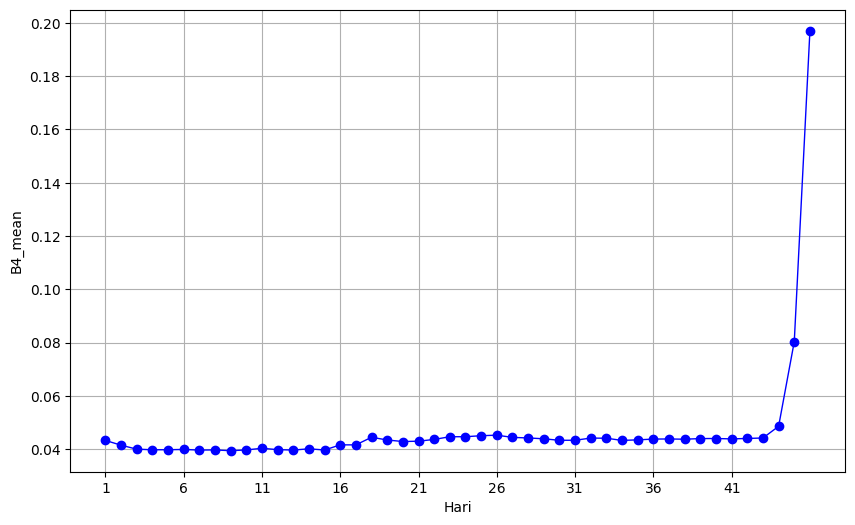

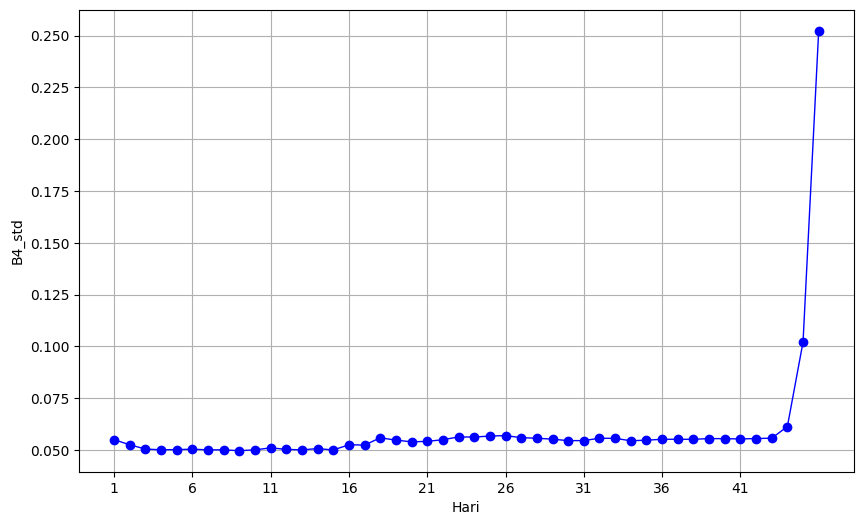

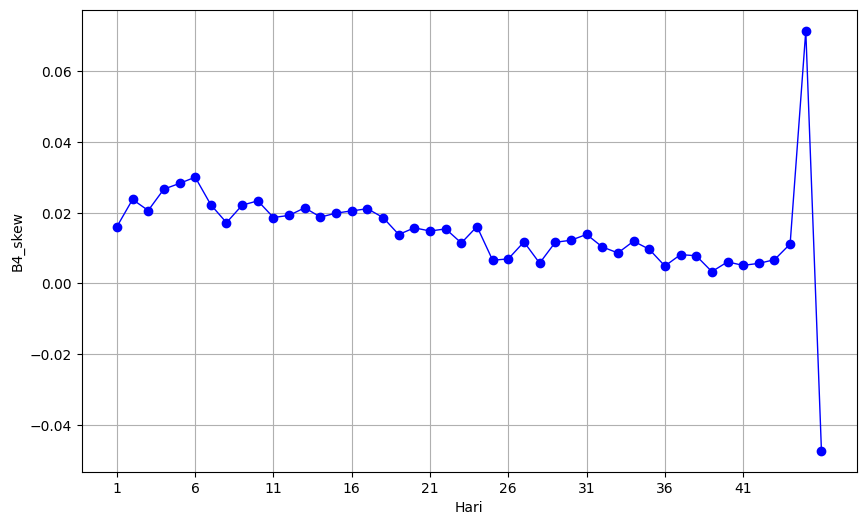

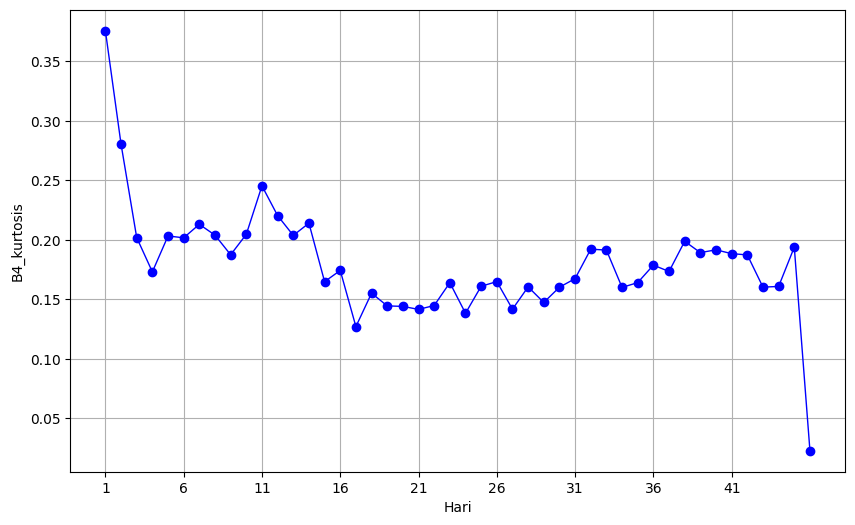

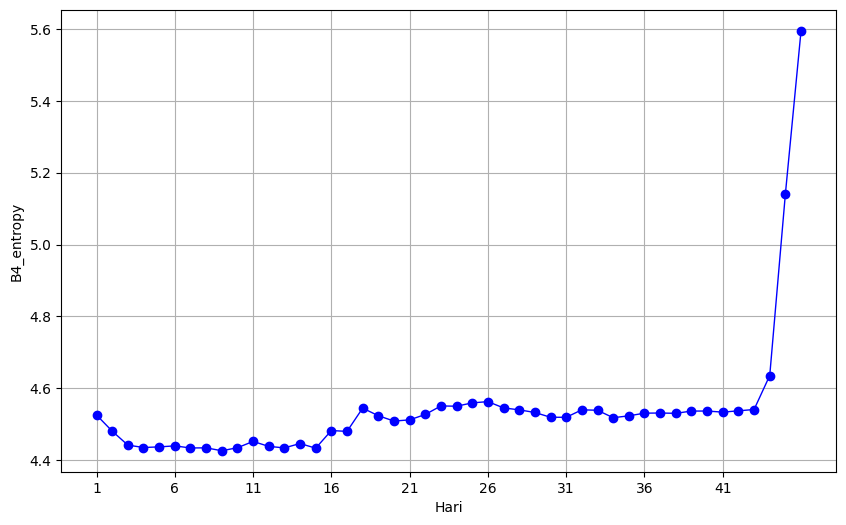

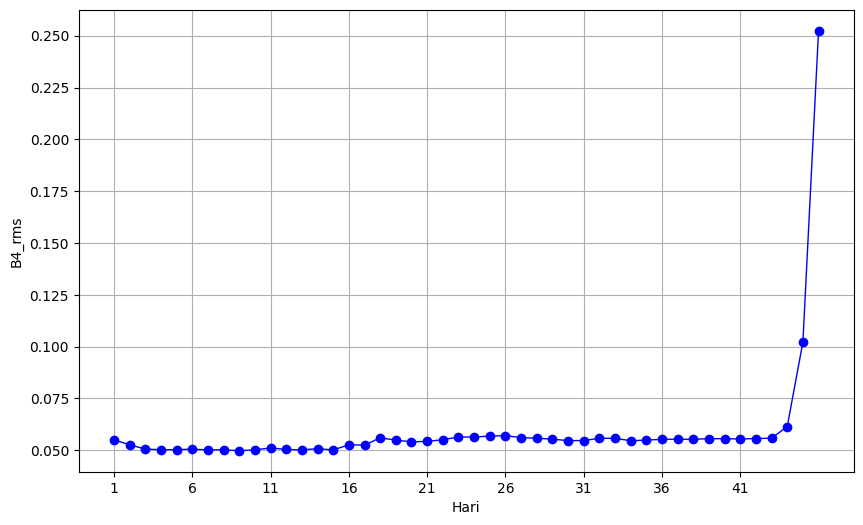

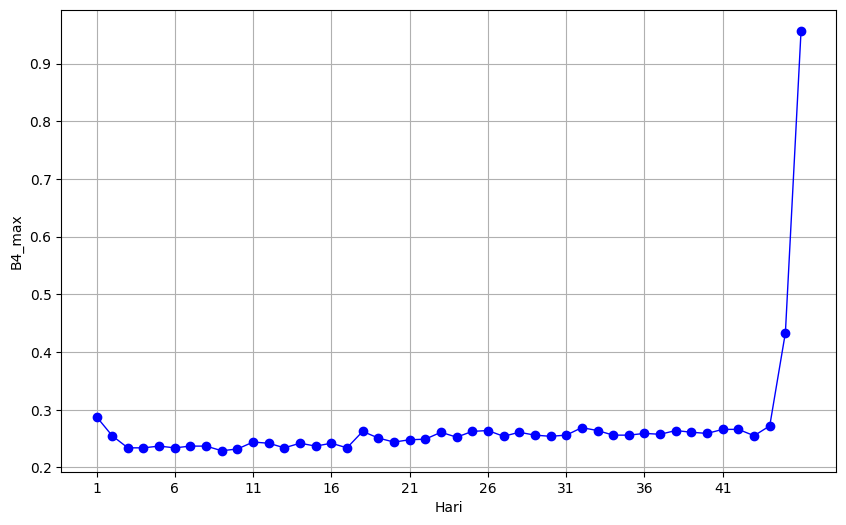

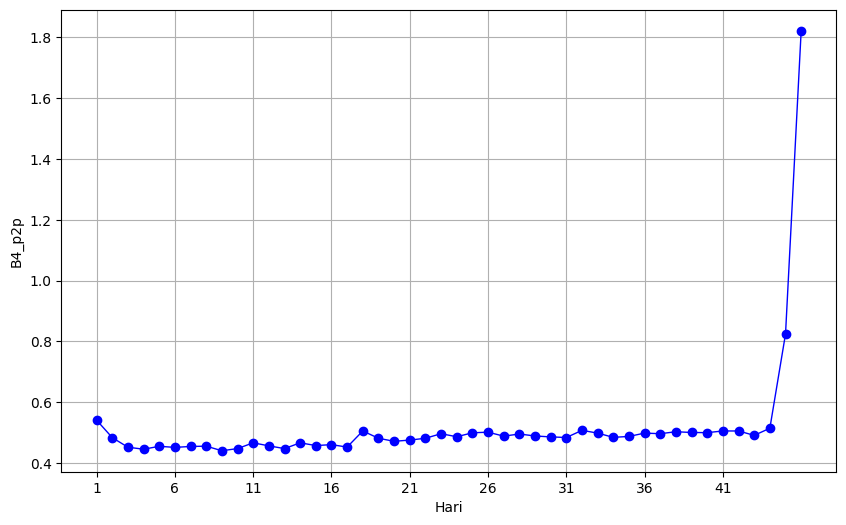

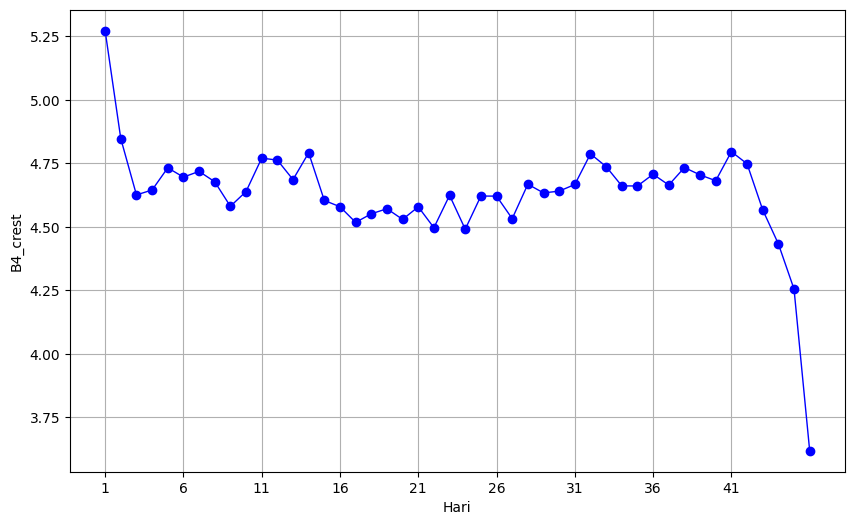

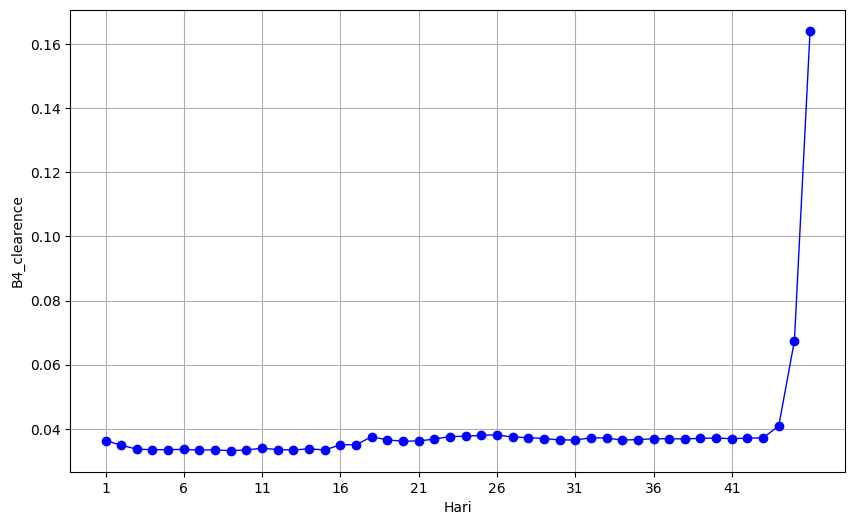

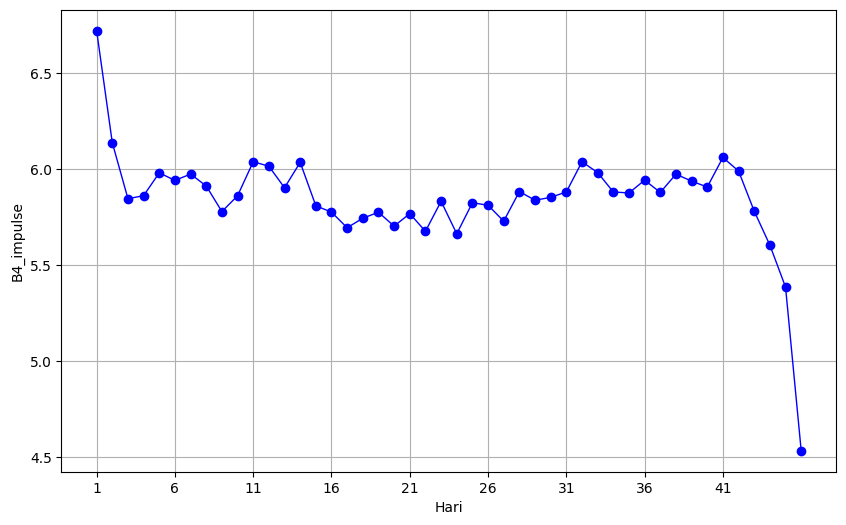

In [165]:
columns = list(df_copy.columns)

# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
    plt.figure(figsize=(10, 6)) # Ukuran plot
    Features = plt.plot(df_copy.index, df_copy[tf], linestyle='-', marker='o', color='b', linewidth=1)
    plt.xticks(np.arange(1, 46, step=5))
    plt.ylabel(tf)
    plt.xlabel('Hari')
    plt.grid()

## Feature Selection

In [166]:
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
rawdata = df_copy.copy()

In [168]:
RUL = np.arange(46, 0 ,-1) # Array nilai RUL dari 46 sampai 1
rawdata.insert(2, 'RUL',RUL)

In [169]:
# # Pembuatan fungsi untuk menghitung nilai korelasi antara time_features dengan variabel RUL
# def calculate_correlation(df):
#   result = [] # List kosong untuk menampung hasil perhitungan
#   # List dari time_features yang ingin dicari nilai korelasi sebelumnya
#   columns = list(rawdata.columns)
#   for tf in columns: # Iterasi untuk tiap time_features
#     r = abs(df[tf].corr(df['RUL'])) # Perhitungan nilai korelasi
#     result.append(r) # Hasil perhitungan ditambahkan ke dalam list result
#   return result # Mengeluarkan output result
rawdata.drop(columns='RUL', axis=1, inplace=True)
# Pembuatan fungsi untuk menghitung monotonicity
def calculate_monotonicity(df):
  result = [] # List kosong untuk menampung hasil perhitungan
  # List dari time_features yang ingin dicari nilai monotonicity sebelumnya
  columns = list(rawdata.columns)
  for tf in columns: # Iterasi untuk tiap time_features
    mon = (df[tf].max()-df[tf].min())/(len(df[tf])-1) # Perhitungan nilai monotonicty
    result.append(mon) # Hasil perhitungan ditambahkan ke dalam list result
  return result # Mengeluarkan output result

In [170]:
rawdata['Hari'] = pd.date_range(start='03/04/2004', end='18/04/2004')
rawdata.set_index('Hari', drop=True, inplace=True)
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
# Pembuatan fungsi untuk menghitung robustness
def calculate_robustness(df):
  result = [] # List kosong untuk menampung hasil perhitungan
  # List dari time_features yang ingin dicari nilai monotonicity sebelumnya
  columns = list(rawdata.columns)
  for tf in columns:
    decomposed = seasonal_decompose(rawdata[tf], model='additive')
    residual = pd.DataFrame(decomposed.resid)
    residual.fillna(0,inplace=True)
    robust = (1/len(df[tf]))*np.exp(-(abs(residual['resid']/rawdata[tf]))).sum() # Perhitungan robustness
    result.append(robust) # Menambahkan hasil perhitungan ke list result
  return result # Mengeluarkan output result

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: UserWarning: Parsing '18/04/2004' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [171]:
def calculate_goodnessmetric(monotonicity, robustness):
    result = [] # List kosong untuk menampung hasil perhitungan
    for i in range(len(monotonicity)): # Iterasi sesuai dengan jumlah time_features
        r = 0.2*monotonicity[i] + 0.5*robustness[i] + 0.3*monotonicity[i] # Perhitungan goodness metric
        result.append(r) # Menambahkan hasil perhitungan ke list result
    return result # Mengeluarkan output result

In [172]:
# Melakukan perhitungan sesuai dengan fungsi yang telah dibuat 
monotonicity = np.array(calculate_monotonicity(rawdata))
robustness = np.array(calculate_robustness(rawdata))
goodness_metric = np.array(calculate_goodnessmetric(monotonicity, robustness))

# Hasil dari perhitungan disimpan dalam bentuk dataframe
columns = list(rawdata.columns)[:49]
goodness_metric = pd.DataFrame({'monotonicity': monotonicity, 'robustness':robustness, 'goodness_metric':goodness_metric}, 
                               columns=['monotonicity', 'robustness', 'goodness_metric'], index=columns)

# Menampilkan hasil perhitungan goodness metric yang sudah diurutkan dari nilai tertinggi ke rendah
goodness_metric.sort_values('goodness_metric', ascending=False)

monotonicity  robustness  goodness_metric
B4_impulse        0.048600    0.991748         0.520174
B4_crest          0.036747    0.992142         0.514444
B4_entropy        0.025976    0.996074         0.511025
B4_p2p            0.030711    0.969426         0.500068
B4_max            0.016178    0.968394         0.492286
B4_rms            0.004503    0.965527         0.485015
B4_std            0.004505    0.965462         0.484983
B4_mean           0.003501    0.966022         0.484761
B4_clearence      0.002911    0.966249         0.484580
B4_kurtosis       0.007844    0.951438         0.479641
B4_skew           0.002640    0.874478         0.438559

# Data Smoothing

In [173]:
goodness_metric.sort_values('goodness_metric', ascending=False).head(6).index

Index(['B4_impulse', 'B4_crest', 'B4_entropy', 'B4_p2p', 'B4_max', 'B4_rms'], dtype='object')

In [174]:
health_indicator = rawdata.loc[:,['B4_impulse', 'B4_crest', 'B4_entropy', 'B4_p2p', 'B4_max', 'B4_rms']]

In [175]:
health_indicator = health_indicator.rename(columns={'B4_impulse' : 'Impulse', 'B4_crest' : 'Faktor Puncak', 
                                                    'B4_entropy' : 'Entropi', 'B4_p2p' : 'Peek to Peek', 'B4_max' : 'Maksimum Absolut', 
                                                    'B4_rms' : 'Root Mean Square'})

In [176]:
print(health_indicator.columns)

Index(['Impulse', 'Faktor Puncak', 'Entropi', 'Peek to Peek',
       'Maksimum Absolut', 'Root Mean Square'],
      dtype='object')


## Gaussian Method

In [177]:
from scipy.ndimage.filters import gaussian_filter1d
# Define smoothing function using Gaussian smoothing
def gaussian_smoothing(data, sigma):
  smoothed_data = np.zeros_like(data)
  for i in range(data.shape[1]):
    smoothed_data[:, i] = gaussian_filter1d(data[:, i], sigma=sigma)
  return smoothed_data
# Apply Gaussian smoothing with sigma = 2.0 to health_indicator dataframe
smoothing_gaussian = pd.DataFrame(gaussian_smoothing(health_indicator.values, sigma=2.0), columns=health_indicator.columns)
# Print the first 10 rows of the smoothed data
smoothing_gaussian.head(10)

<ipython-input-177-e0d3d0d8774a>:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Impulse  Faktor Puncak   Entropi  Peek to Peek  Maksimum Absolut  \
0  6.267734       4.941403  4.483967      0.493790          0.260631   
1  6.196788       4.889267  4.475601      0.485627          0.255820   
2  6.095956       4.815101  4.462996      0.473672          0.248754   
3  6.011176       4.752532  4.451179      0.463074          0.242440   
4  5.960919       4.715068  4.442915      0.456371          0.238366   
5  5.936043       4.696153  4.438199      0.453117          0.236316   
6  5.921033       4.684753  4.435864      0.451728          0.235427   
7  5.910556       4.677273  4.435087      0.451198          0.235156   
8  5.908957       4.677074  4.435588      0.451411          0.235444   
9  5.918981       4.686234  4.437032      0.452432          0.236296   

   Root Mean Square  
0          0.052818  
1          0.052373  
2          0.051705  
3          0.051081  
4          0.050648  
5          0.050404  
6          0.050283  
7          0.050240  
8          0.050262  
9          0.050333

## Exponential Moving Avarage Smoothing

In [179]:
# Penggunaan algoritma Exponential Moving Average mirip dengan Simple Moving Average
# Minimal nilai window lebih rendah dibanding SMA
smoothing_EMA15 = pd.DataFrame() # Pembuatan Dataframe untuk menampung hasil smoothing data SMA
for col in health_indicator:  # Iterasi untuk setiap kolom pada dataframe time_features
  smoothing_EMA15[col] = health_indicator[col].ewm(span=5).mean() # Mencari nilai Simple Moving Average dengan rentang span 17

smoothing_EMA15.head(10) # Menampilkan hasil data smoothing

Impulse  Faktor Puncak   Entropi  Peek to Peek  Maksimum Absolut  \
Hari                                                                            
2004-03-04  6.719767       5.272661  4.525562      0.540500          0.288000   
2004-03-05  6.369733       5.017721  4.498652      0.506000          0.268200   
2004-03-06  6.121186       4.832292  4.471727      0.480184          0.252000   
2004-03-07  6.013077       4.754724  4.456495      0.465569          0.244523   
2004-03-08  6.000341       4.746344  4.448948      0.461320          0.241635   
2004-03-09  5.978371       4.728079  4.445540      0.457549          0.238845   
2004-03-10  5.976591       4.724818  4.441394      0.456292          0.238192   
2004-03-11  5.953887       4.708603  4.438879      0.455844          0.237778   
2004-03-12  5.893765       4.665063  4.434519      0.450422          0.234774   
2004-03-13  5.882330       4.656377  4.434485      0.449261          0.233833   

            Root Mean Square  
Hari                          
2004-03-04          0.055070  
2004-03-05          0.053578  
2004-03-06          0.052161  
2004-03-07          0.051356  
2004-03-08          0.050955  
2004-03-09          0.050783  
2004-03-10          0.050581  
2004-03-11          0.050445  
2004-03-12          0.050213  
2004-03-13          0.050199

## Holt's Method Smoothing

In [180]:
# The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing. 
# This method is suitable for forecasting data with no clear trend or seasonal pattern. 

from statsmodels.tsa.holtwinters import Holt # Import modul Simple Exponential Smoothing dari library
smoothing_DoubleExp = pd.DataFrame() # Pembuatan Dataframe untuk menampung hasil smoothing data dari Simple Exponential Smoothing
for col in health_indicator: # Iterasi untuk setiap kolom pada dataframe time_feature
  model = Holt(health_indicator[col]) # Pembuatan model dari tiap kolom pada dataframe time_features
  fit_model = model.fit(smoothing_level=0.15, smoothing_slope=0.05,  optimized=True) # Fitting model dengan smoothing level 0.5
  smoothing_DoubleExp[col] = fit_model.fittedvalues # Hasil fitting dimasukkan ke dalam dataframe

smoothing_DoubleExp.head(10) # Menampilkan hasil data smoothing

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-180-4d567cda27db>:8: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit_model = model.fit(smoothing_level=0.15, smoothing_slope=0.05,  optimized=True) # Fitting model dengan smoothing level 0.5
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-180-4d567cda27db>:8: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit_model = model.fit(smoothing_level=0.15, smoothing_slope=0.05,  optimized=True) # Fitting model dengan smoothing level 0.5
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWar

Impulse  Faktor Puncak   Entropi  Peek to Peek  Maksimum Absolut  \
Hari                                                                            
2004-03-04  6.085359       4.808685  4.417933      0.437074          0.228904   
2004-03-05  6.172574       4.872429  4.439932      0.456445          0.239808   
2004-03-06  6.158928       4.862691  4.452210      0.464485          0.244240   
2004-03-07  6.101270       4.819416  4.456733      0.466497          0.244781   
2004-03-08  6.052844       4.784222  4.459402      0.467070          0.245160   
2004-03-09  6.028982       4.767023  4.461768      0.468889          0.245870   
2004-03-10  6.002080       4.746394  4.464030      0.469775          0.245936   
2004-03-11  5.983967       4.732029  4.464859      0.470860          0.246374   
2004-03-12  5.958694       4.713294  4.465379      0.471813          0.246676   
2004-03-13  5.915920       4.681877  4.464327      0.470135          0.245600   

            Root Mean Square  
Hari                          
2004-03-04          0.046829  
2004-03-05          0.048631  
2004-03-06          0.049819  
2004-03-07          0.050536  
2004-03-08          0.051088  
2004-03-09          0.051564  
2004-03-10          0.051987  
2004-03-11          0.052292  
2004-03-12          0.052533  
2004-03-13          0.052653

## Savitzky-Golay filter Smoothing

In [181]:
# The Savitzky-Golay filter adalah low pass filter yang memungkinkan untuk smoothing data.

from scipy.signal import savgol_filter # Import modul Savgol Filter dari library
smoothing_savgolfilter = pd.DataFrame() # Pembuatan Dataframe untuk menampung hasil smoothing data dari Savgol Filter
for col in health_indicator: # Iterasi untuk setiap kolom pada dataframe time_feature
  smoothing_savgolfilter[col] = savgol_filter(health_indicator[col],12,2) # Smoothing dengan window length 12 dan degree 2

smoothing_savgolfilter.head(10) # Menampilkan hasil data smoothing

Impulse  Faktor Puncak   Entropi  Peek to Peek  Maksimum Absolut  \
0  6.440154       5.070121  4.504586      0.512784          0.272508   
1  6.266508       4.940909  4.483124      0.492995          0.260304   
2  6.121206       4.832880  4.465025      0.476370          0.250093   
3  6.004246       4.746034  4.450288      0.462909          0.241874   
4  5.915630       4.680369  4.438915      0.452613          0.235648   
5  5.855356       4.635887  4.430904      0.445482          0.231414   
6  5.896636       4.665429  4.431938      0.448902          0.233598   
7  5.917615       4.681259  4.434733      0.450875          0.235375   
8  5.935836       4.697535  4.436790      0.452326          0.236223   
9  5.938624       4.702883  4.433756      0.452540          0.236437   

   Root Mean Square  
0          0.053908  
1          0.052774  
2          0.051817  
3          0.051038  
4          0.050437  
5          0.050014  
6          0.050079  
7          0.050223  
8          0.050326  
9          0.050166

## Smoothing Plot

### Gaussian Plot

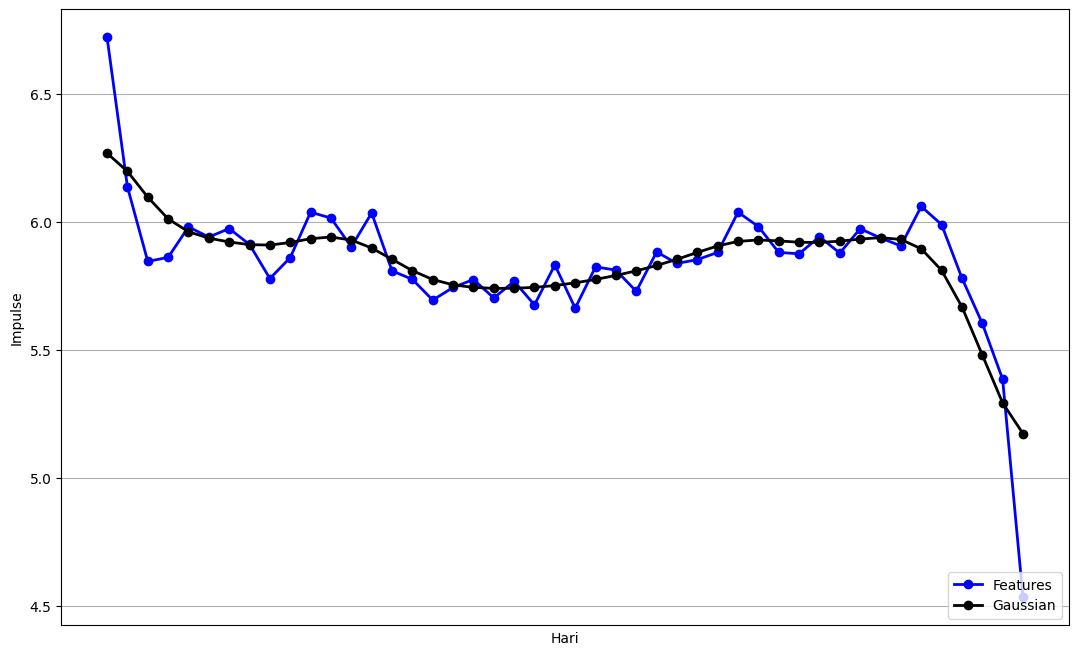

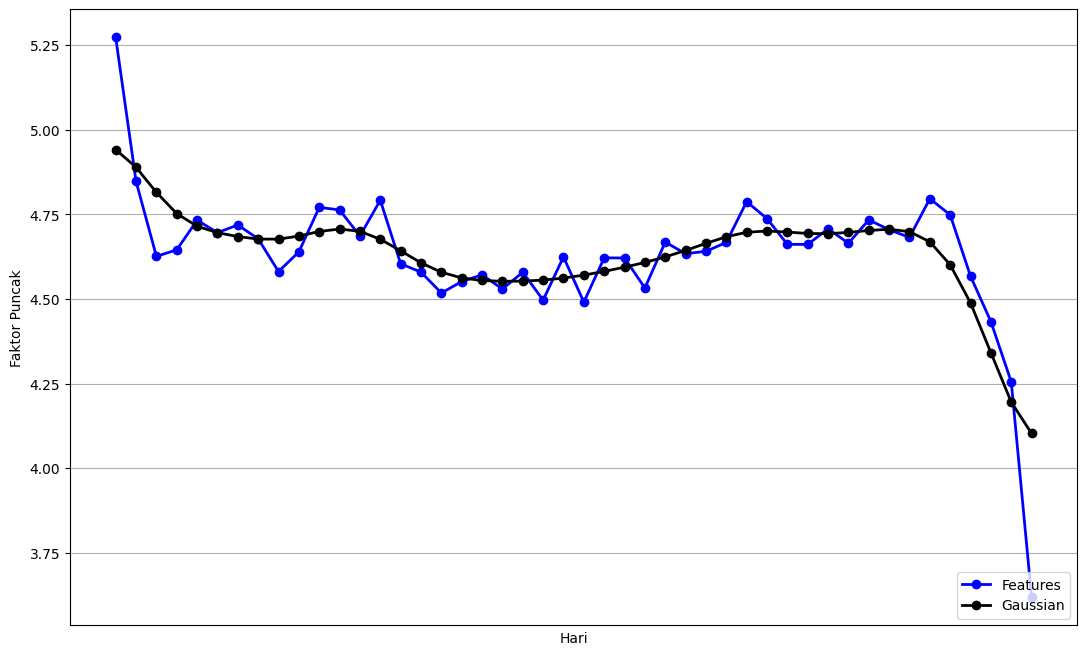

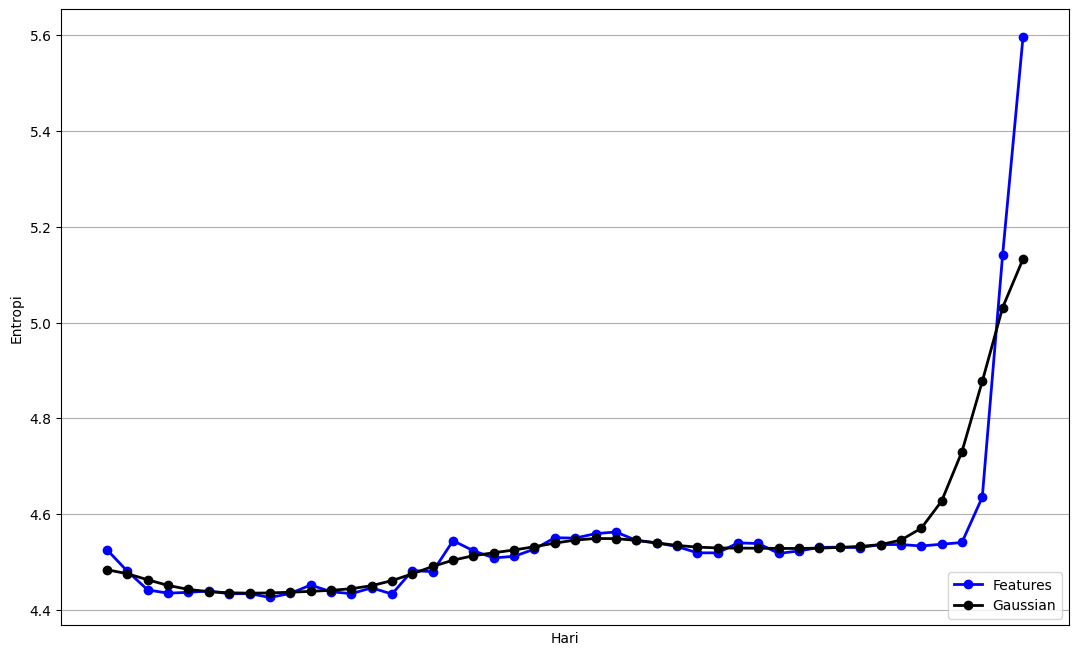

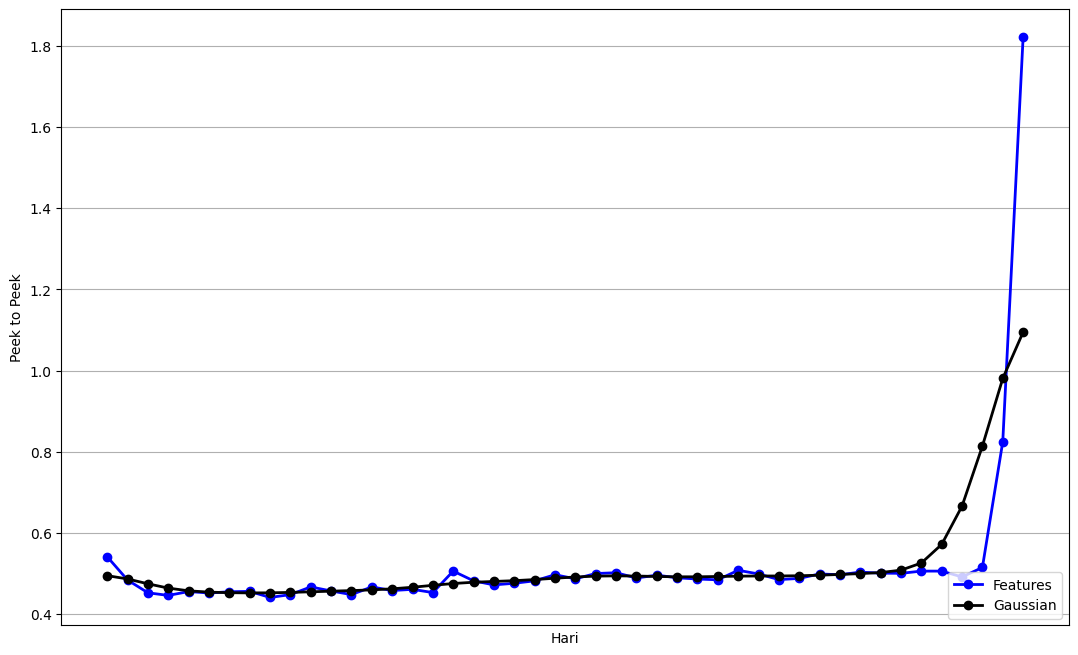

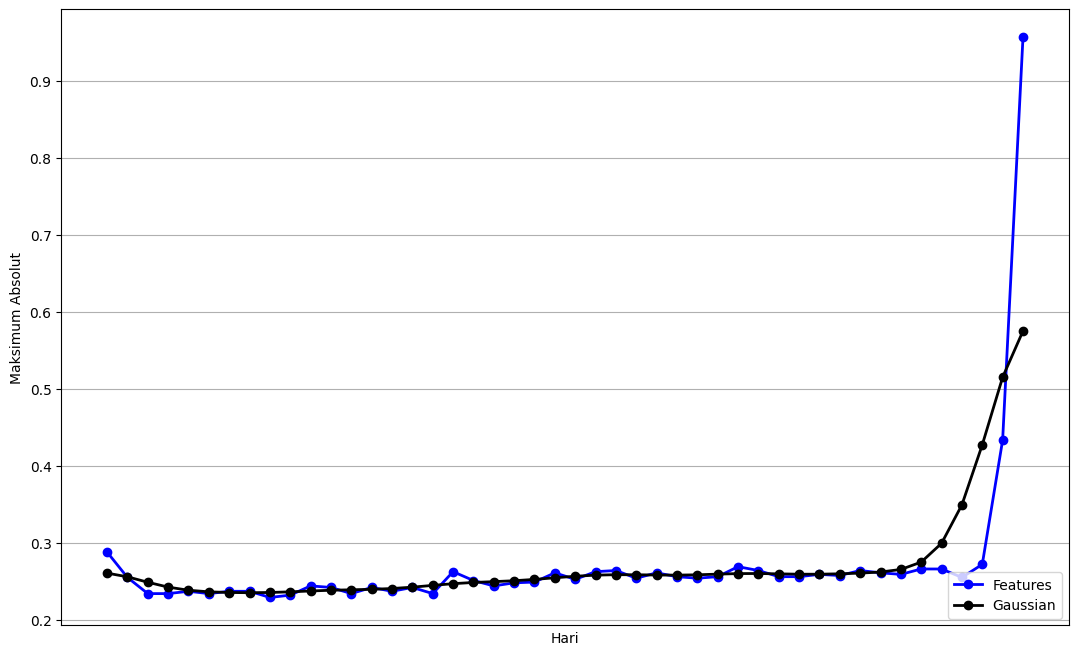

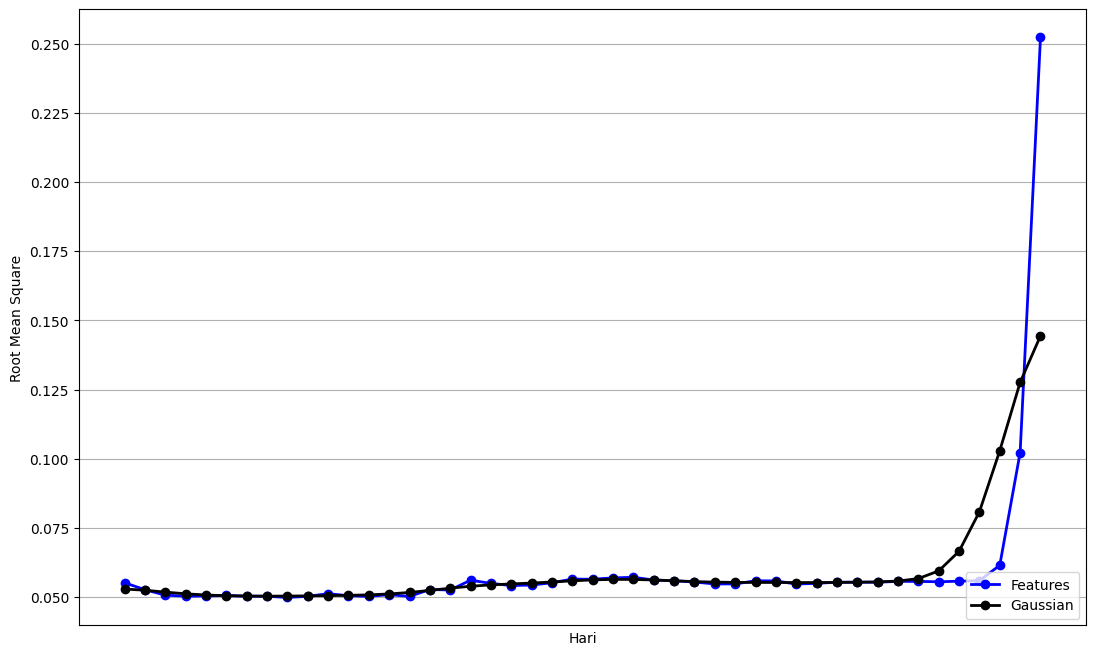

In [182]:
# Pembuatan plot untuk membandingkan hasil data smoothing
# List untuk variabel time_features
columns = list(health_indicator.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  timefeatures = plt.plot(health_indicator.index + pd.Timedelta(days=1), health_indicator[[tf]], linestyle='-', marker='o', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
  DoubleExp = plt.plot(health_indicator.index + pd.Timedelta(days=1), smoothing_gaussian[[tf]], linestyle='-', marker='o', color='black', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
  plt.xticks(np.arange(0))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()
  plt.legend(['Features',"Gaussian"], loc=4)

### EMA Plot

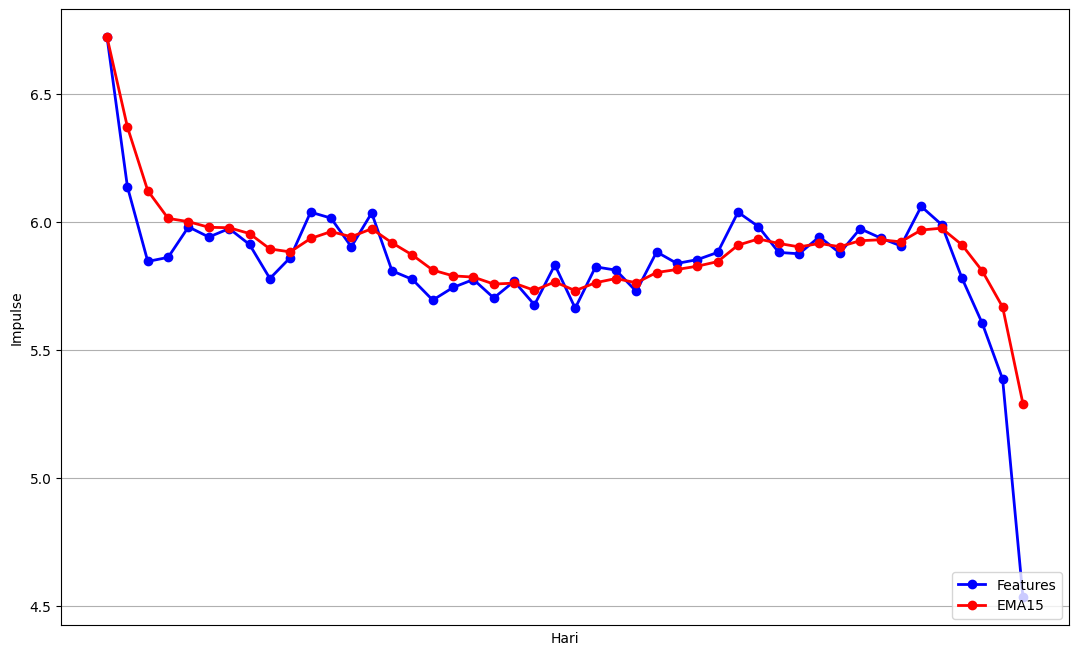

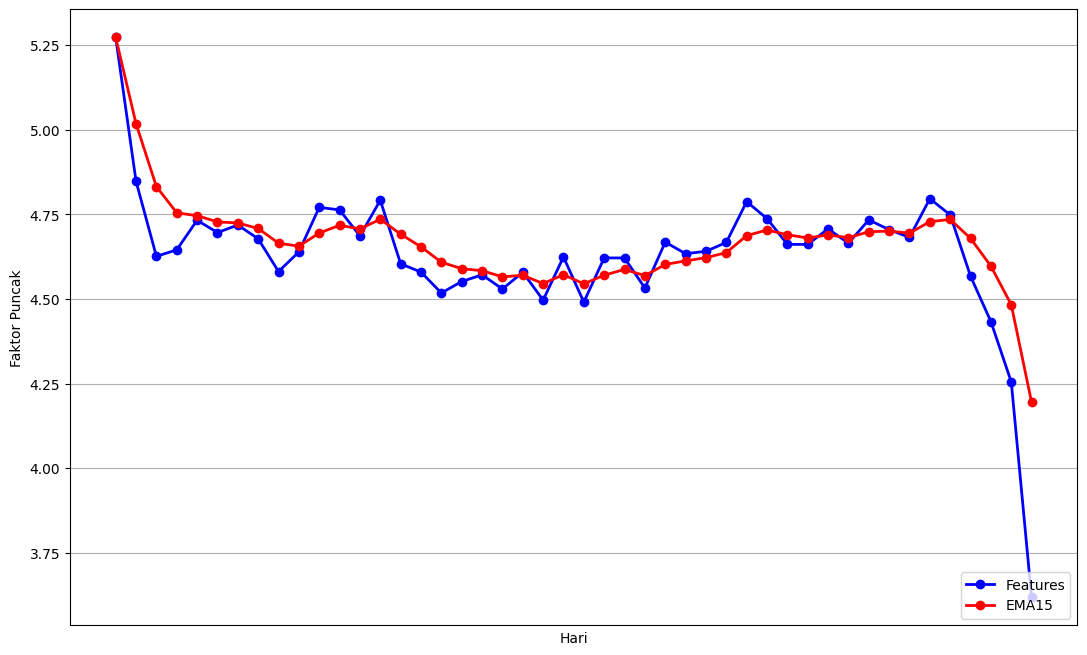

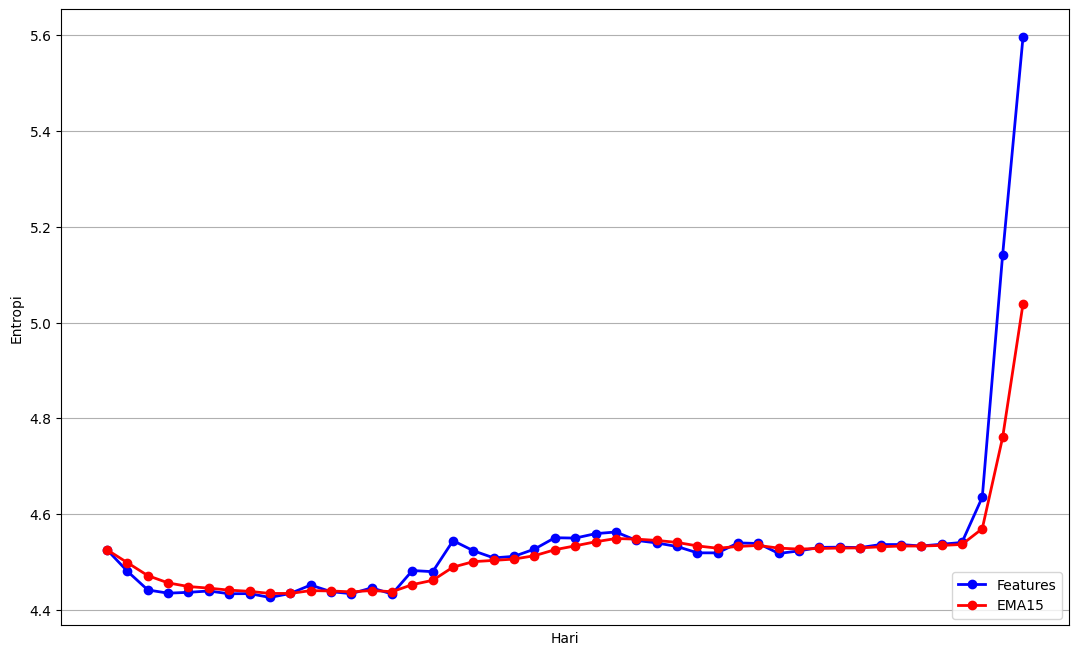

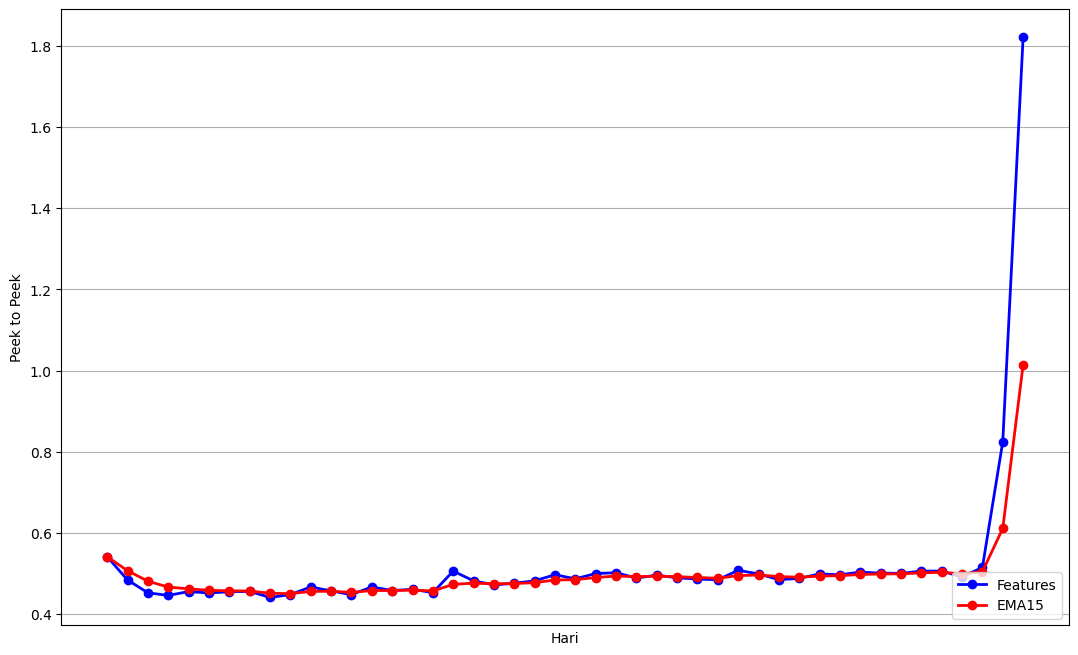

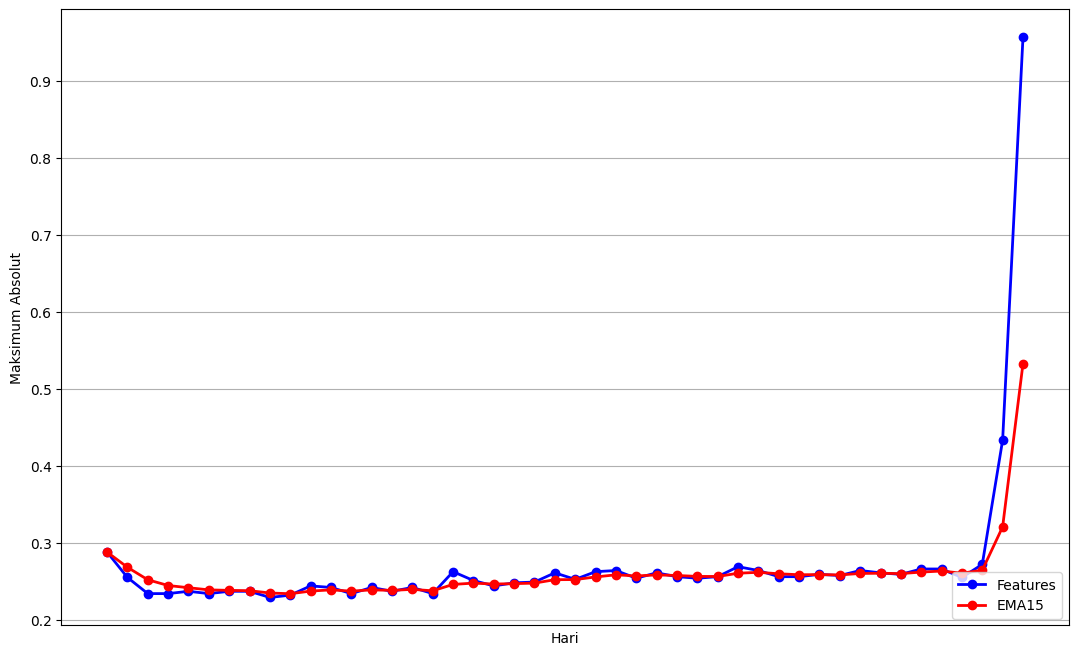

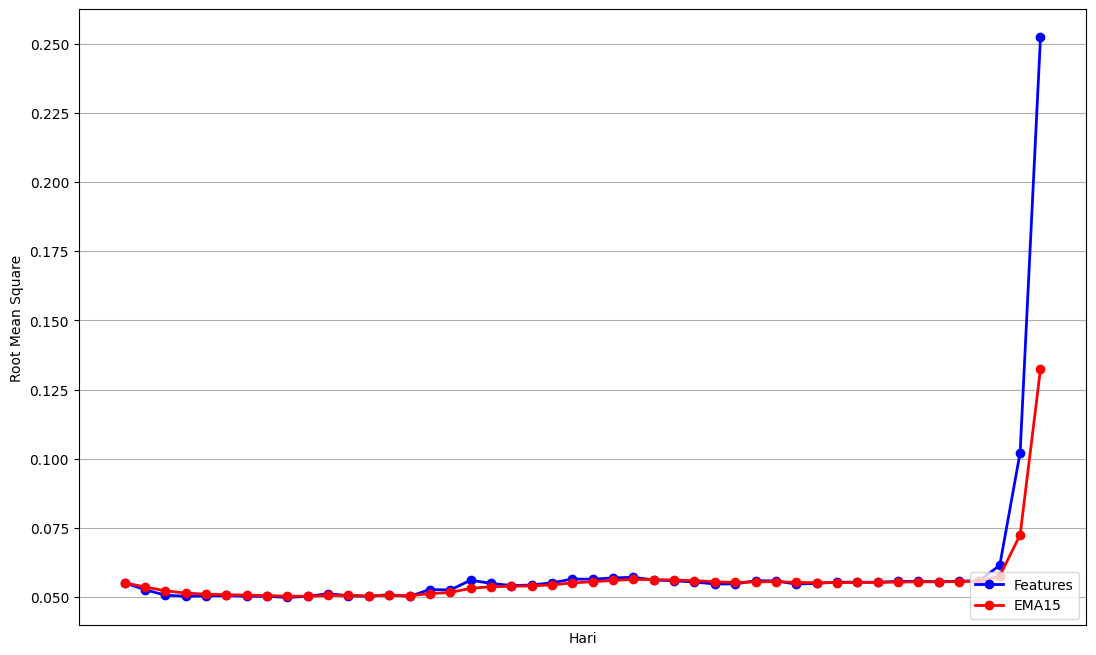

In [184]:
# Pembuatan plot untuk membandingkan hasil data smoothing
# List untuk variabel time_features
columns = list(health_indicator.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  timefeatures = plt.plot(health_indicator.index + pd.Timedelta(days=1), health_indicator[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  EMA15 = plt.plot(health_indicator.index + pd.Timedelta(days=1), smoothing_EMA15[[tf]], linestyle='-', marker='o', color='red', linewidth=2)
  plt.xticks(np.arange(0))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()
  plt.legend(['Features','EMA15'], loc=4)

### Holt's Plot

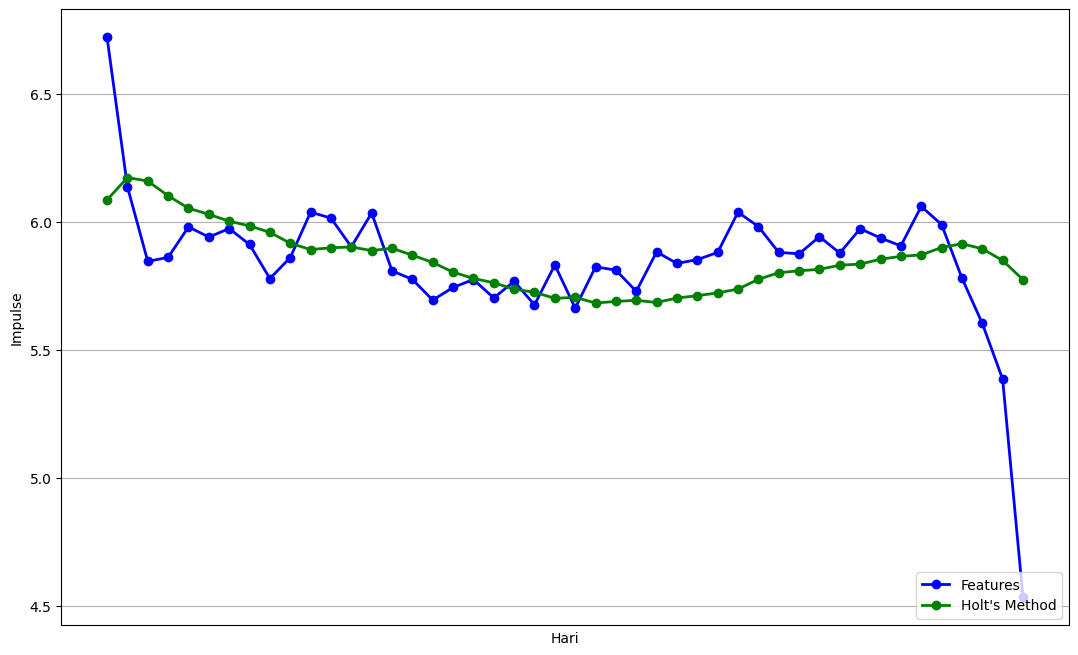

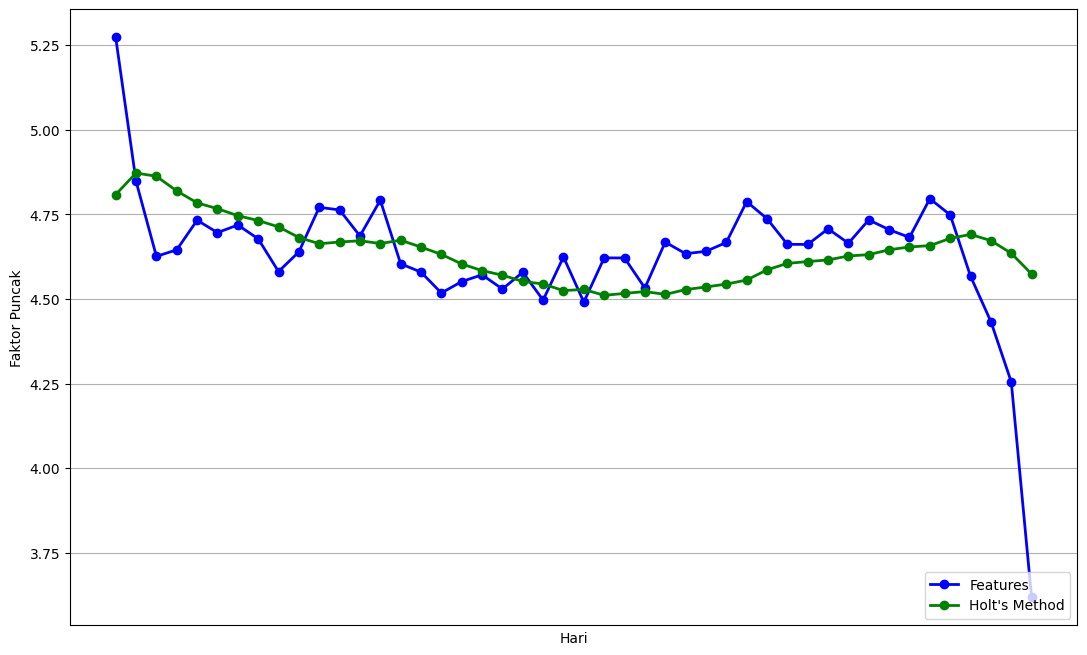

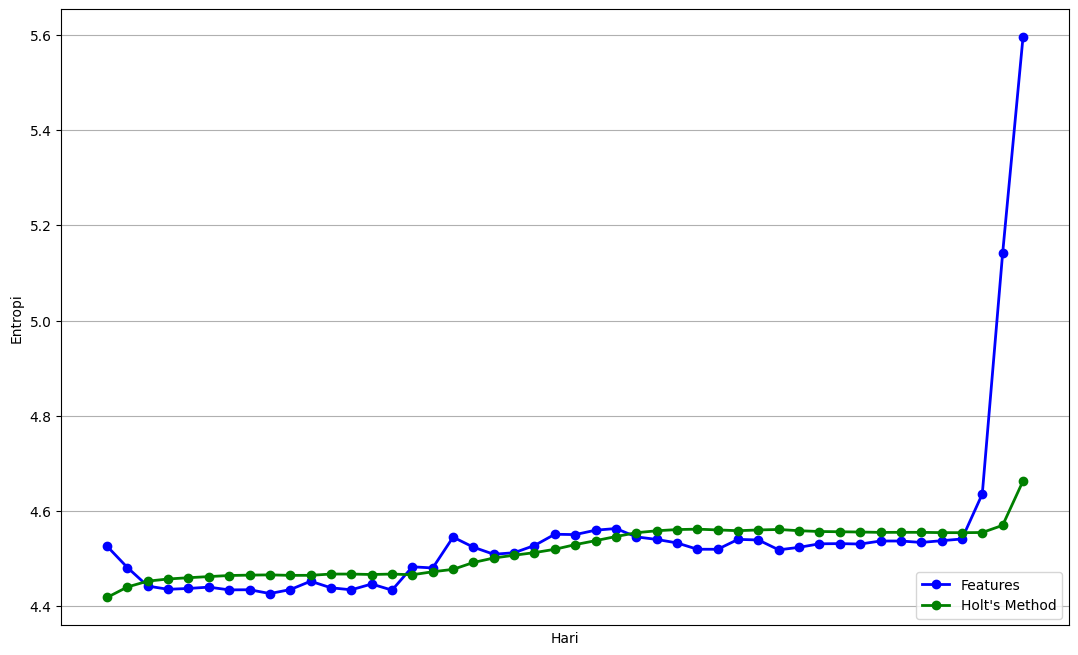

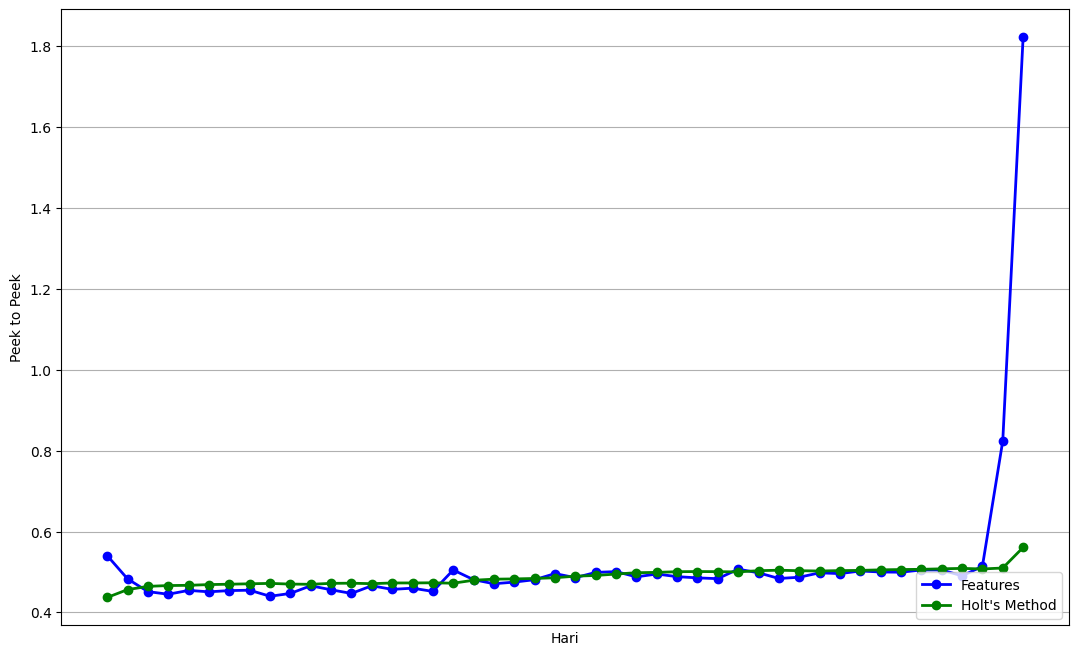

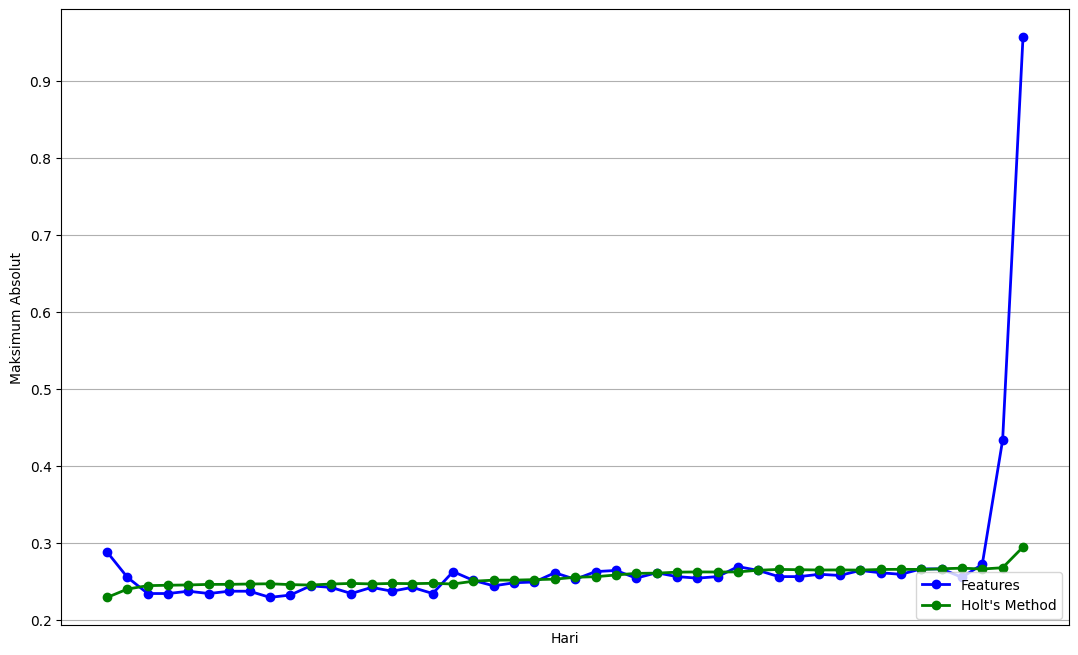

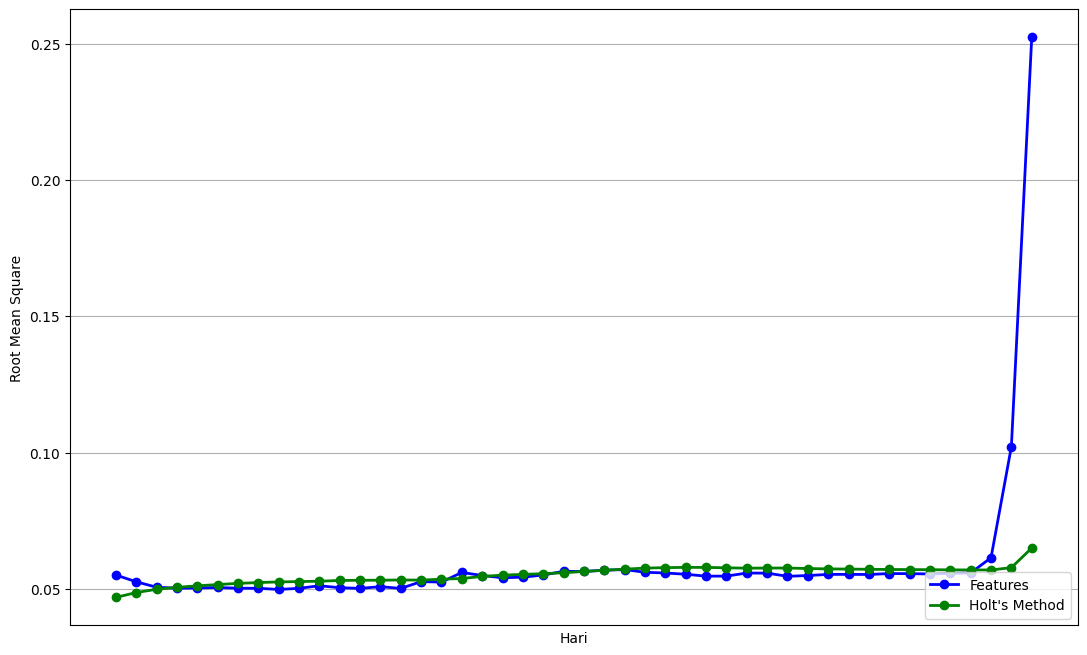

In [185]:
# Pembuatan plot untuk membandingkan hasil data smoothing
# List untuk variabel time_features
columns = list(health_indicator.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  timefeatures = plt.plot(health_indicator.index + pd.Timedelta(days=1), health_indicator[[tf]], linestyle='-', marker='o', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
  DoubleExp = plt.plot(health_indicator.index + pd.Timedelta(days=1), smoothing_DoubleExp[[tf]], linestyle='-', marker='o', color='green', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
  plt.xticks(np.arange(0))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()
  plt.legend(['Features',"Holt's Method"], loc=4)

### Savgol Plot

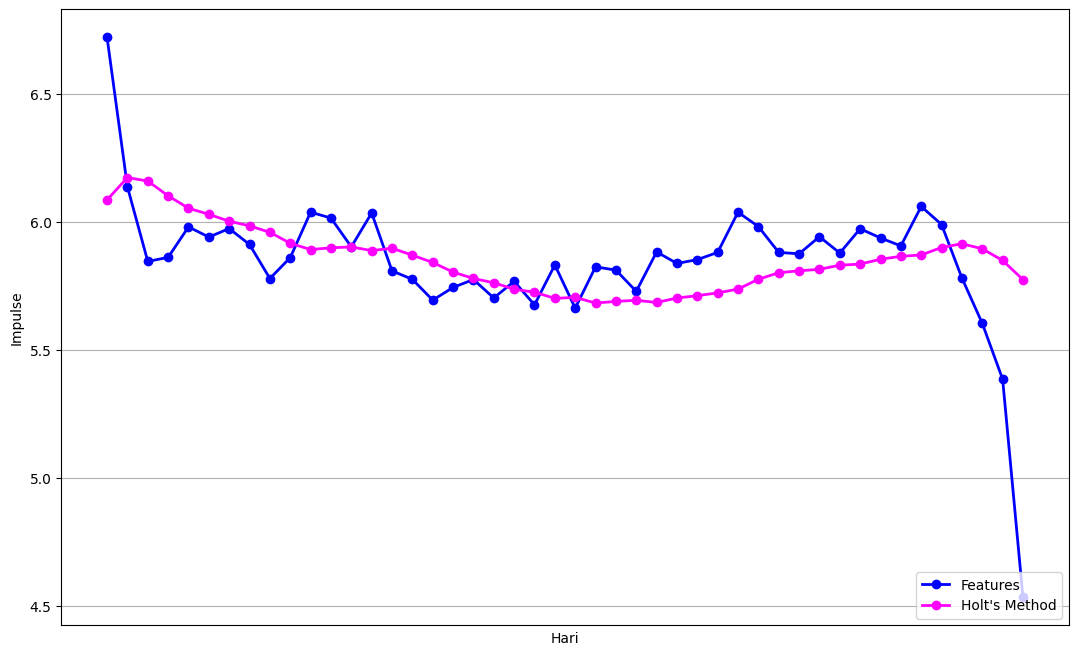

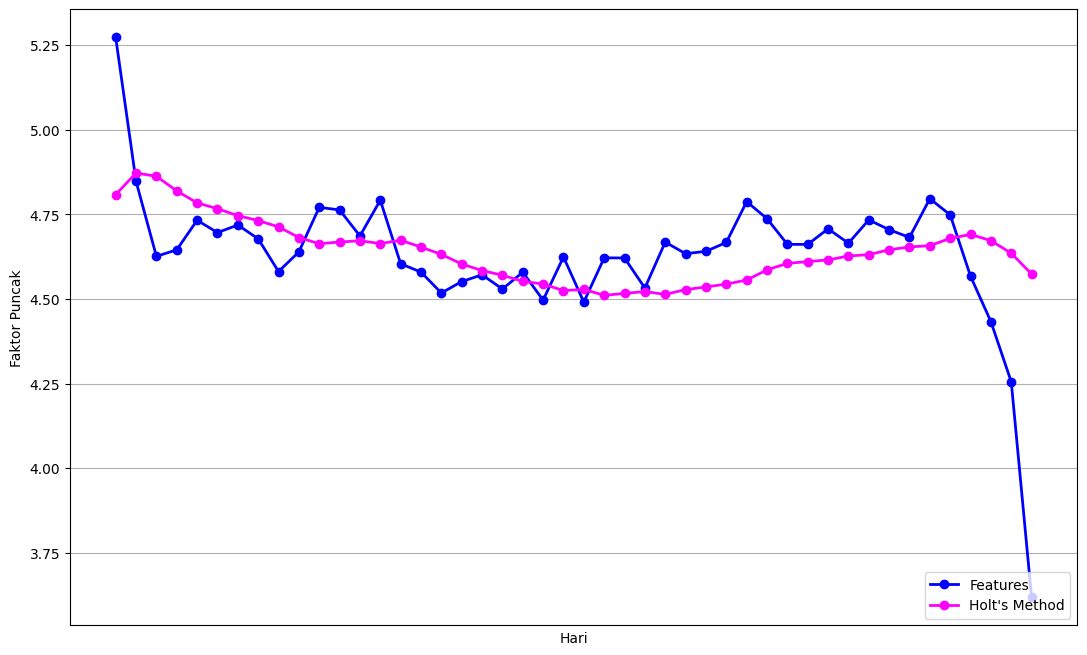

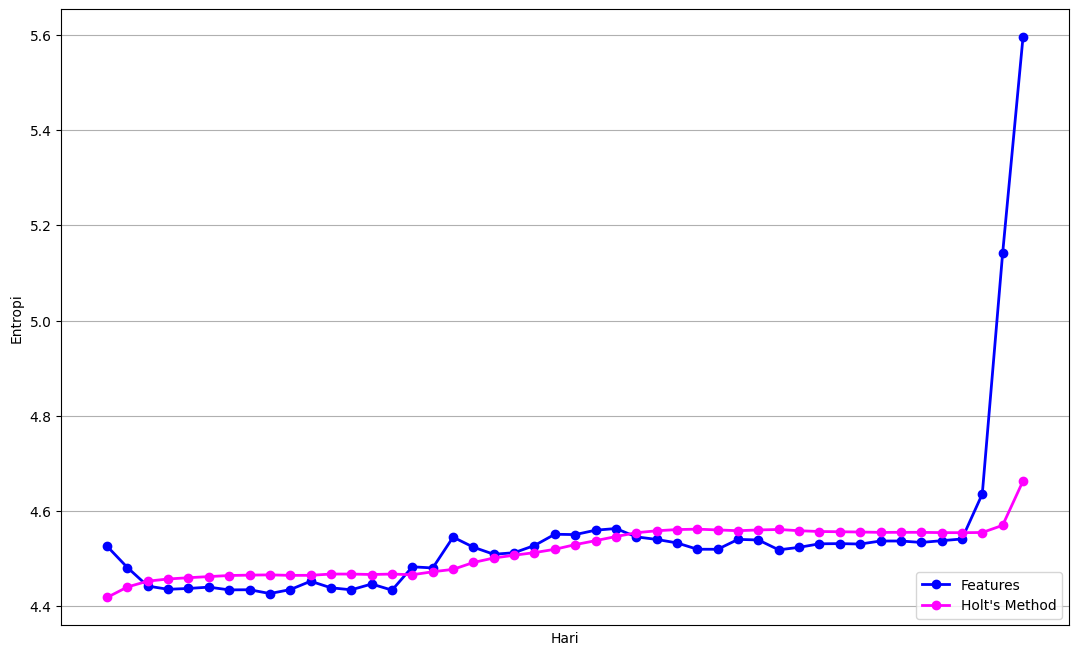

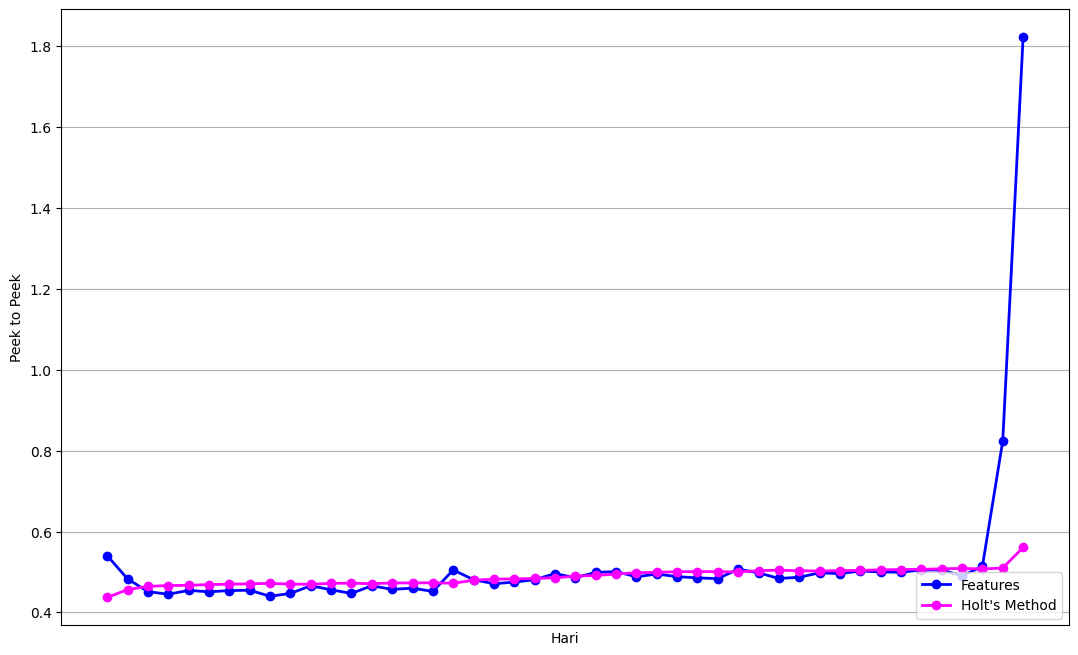

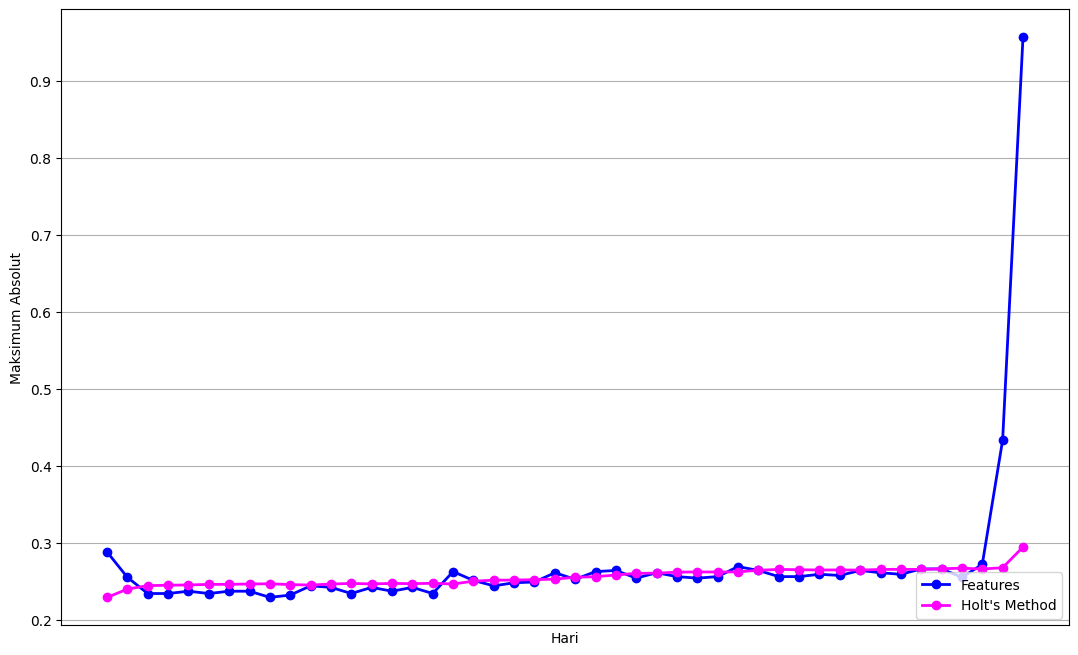

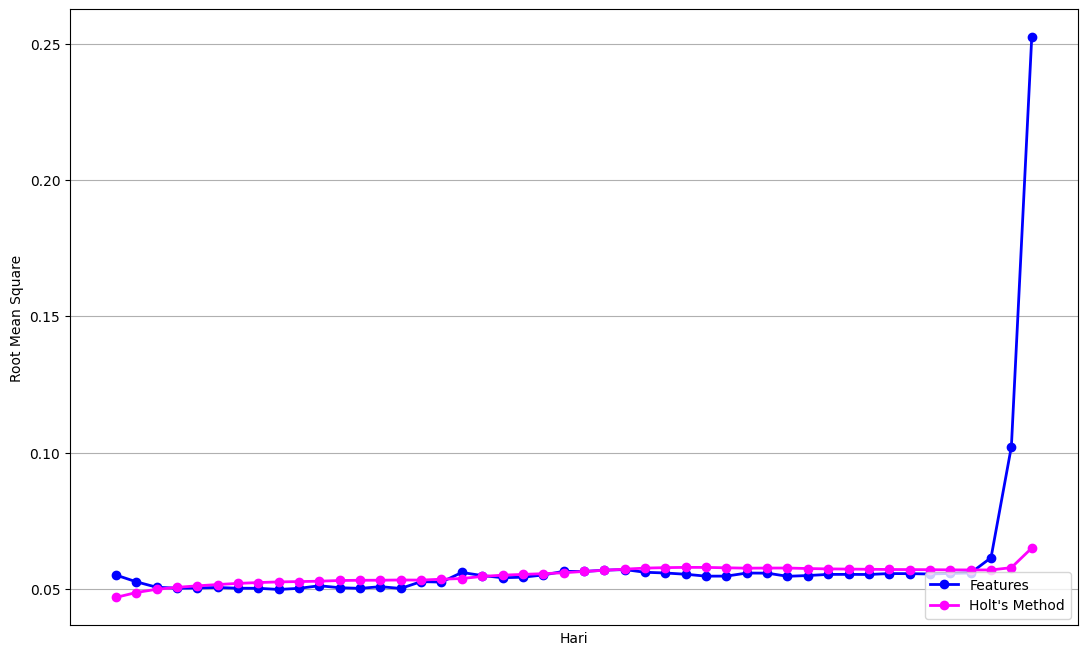

In [186]:
# Pembuatan plot untuk membandingkan hasil data smoothing
# List untuk variabel time_features
columns = list(health_indicator.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  timefeatures = plt.plot(health_indicator.index + pd.Timedelta(days=1), health_indicator[[tf]], linestyle='-', marker='o', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
  DoubleExp = plt.plot(health_indicator.index + pd.Timedelta(days=1), smoothing_DoubleExp[[tf]], linestyle='-', marker='o', color='magenta', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
  plt.xticks(np.arange(0))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()
  plt.legend(['Features',"Holt's Method"], loc=4)

In [187]:
RUL_Aktual = [] # List kosong untuk RUL
for i in range (46, -5,-1): # Membuat iterasi angka dari 50 hingga 1
  RUL_Aktual.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
RUL_Aktual = pd.DataFrame(RUL_Aktual, columns=['RUL Aktual'])

# SVR tanpa Smoothing

## Pembuatan fitur PCA

In [188]:
hi = health_indicator.copy().iloc[:20]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler() # Pendefinisian scaler
hi = pd.DataFrame(scaler.fit_transform(hi)) # Fitting scaler pada X_train

from sklearn.decomposition import PCA
pca = PCA()

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
PCA_explained_variance_ratio= pd.DataFrame(pca.explained_variance_ratio_)
PCA_explained_variance_ratio.rename({0:'Fitur 1', 1:'Fitur 2', 2:'Fitur 3', 3:'Fitur 4', 
                                     4:'Fitur 5', 5:'Fitur 6'}, axis=0, inplace=True)
PCA_explained_variance_ratio.rename({0:'Variance Ratio'}, axis=1, inplace=True)
PCA_explained_variance_ratio

Variance Ratio
Fitur 1        0.698702
Fitur 2        0.293623
Fitur 3        0.006597
Fitur 4        0.000927
Fitur 5        0.000137
Fitur 6        0.000014

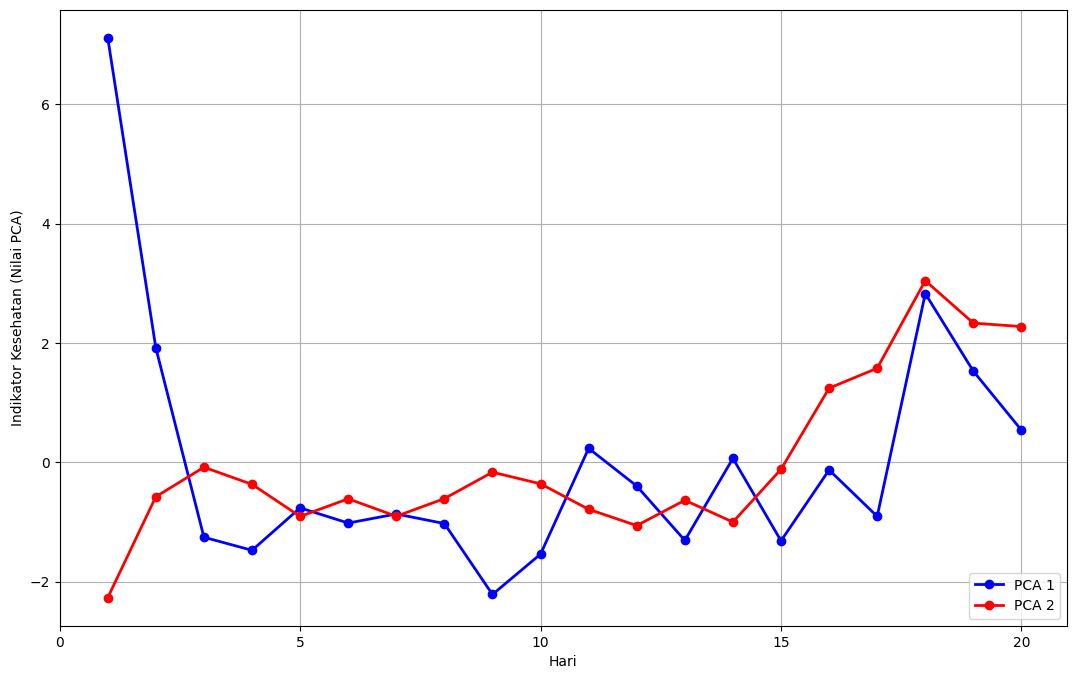

In [189]:
# Membuat fungsi PCA dengan 3 Principal Component 
# svd_solver = full ==> run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing

pca = PCA(n_components=2)

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
hi_PCA= pd.DataFrame(hi_PCA, columns=['Fitur 1','Fitur 2'])
plt.figure(figsize=(13,8))
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 2'], linestyle='-', marker='o', color='red', linewidth=2)
plt.xticks(np.arange(0,21,step=5))
plt.legend(['PCA 1', 'PCA 2'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

In [190]:
# # ['Impulse', 'Faktor Puncak', 'Entropi', 'Peek to Peek',
#        'Maksimum Absolut', 'Root Mean Square']

In [191]:
scaler_parameter = pd.DataFrame([scaler.scale_, scaler.mean_, scaler.var_]).T
scaler_parameter.rename(columns={0:'Scale', 1:'Mean', 2:'Variances'}, index={0:'Impulse', 1:'Faktor Puncak', 2:'Entropi',
                                                                             3:'Peek to Peek', 4:'Maksimum Absolut', 5:'Root Mean Square'}, inplace=True)
scaler_parameter

Scale      Mean  Variances
Impulse           0.217515  5.924512   0.047313
Faktor Puncak     0.160897  4.690384   0.025888
Entropi           0.036286  4.461548   0.001317
Peek to Peek      0.023048  0.464125   0.000531
Maksimum Absolut  0.013189  0.242475   0.000174
Root Mean Square  0.001906  0.051612   0.000004

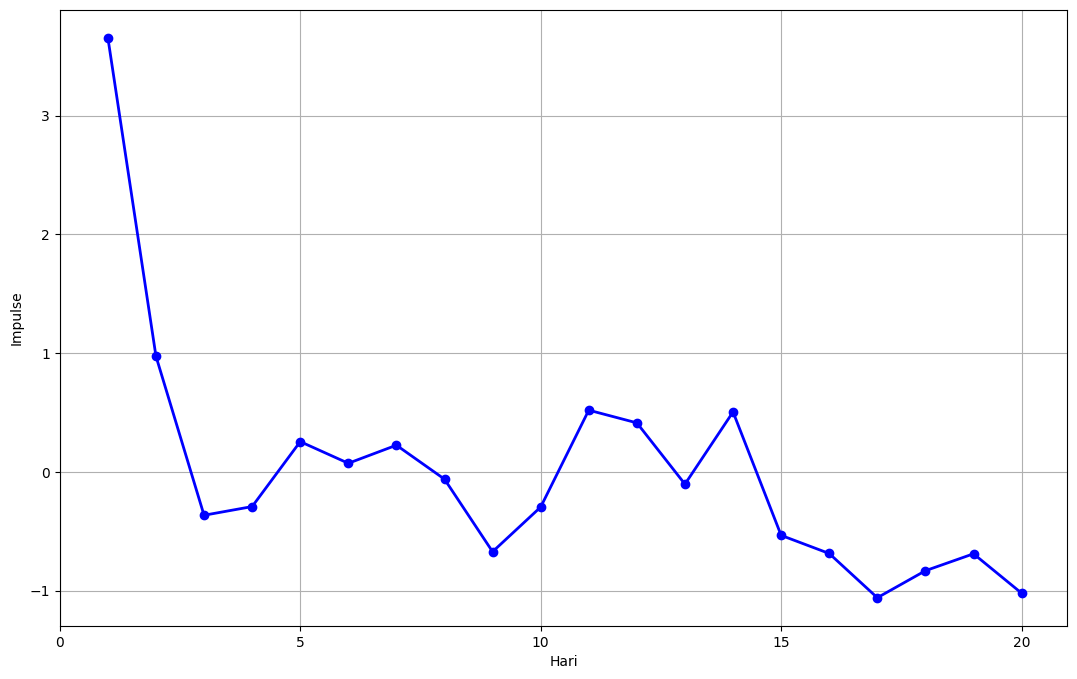

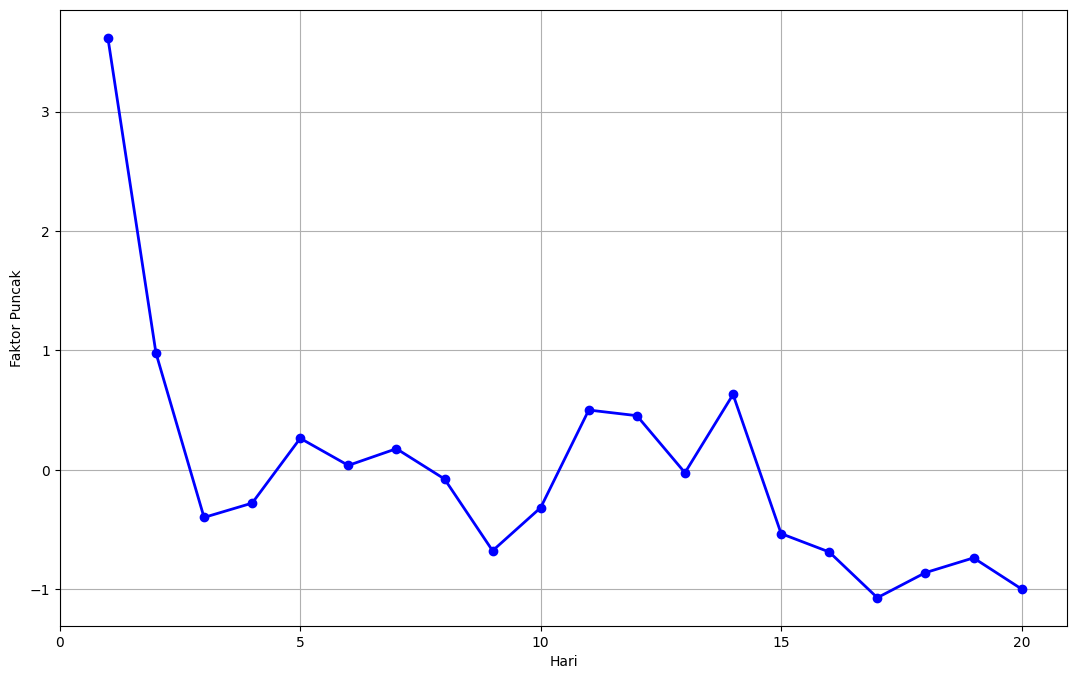

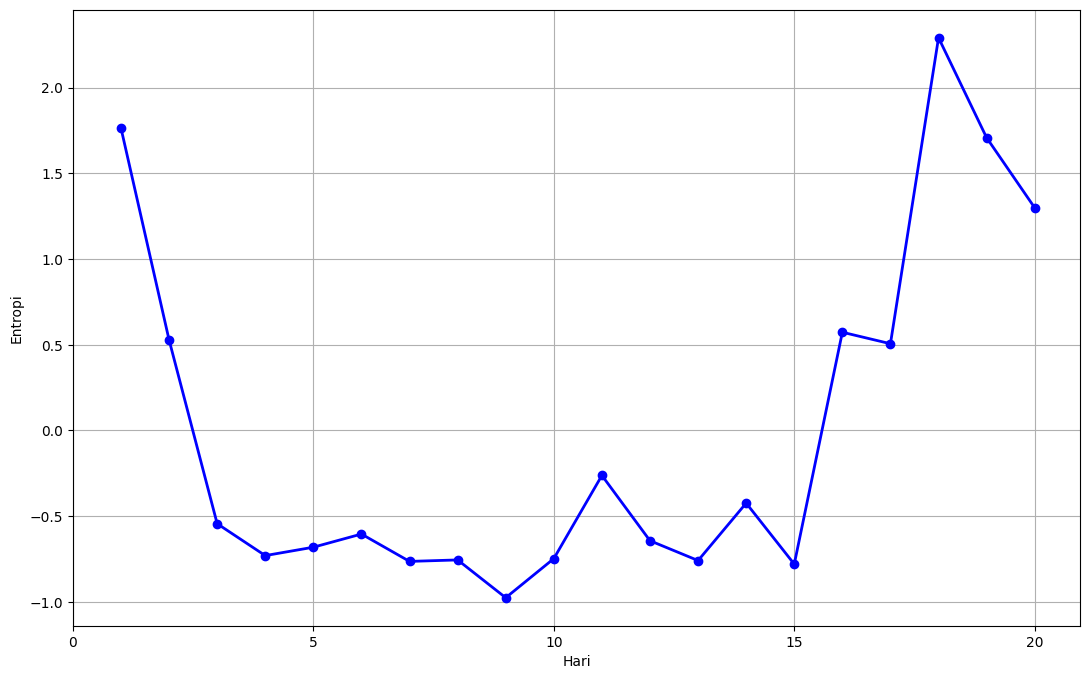

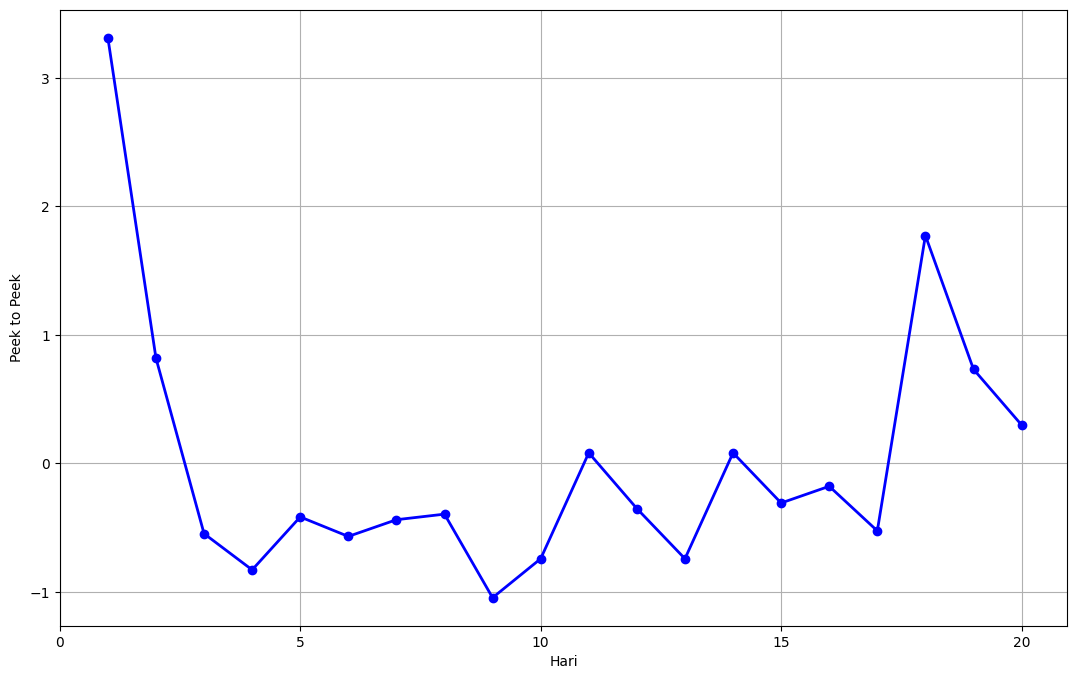

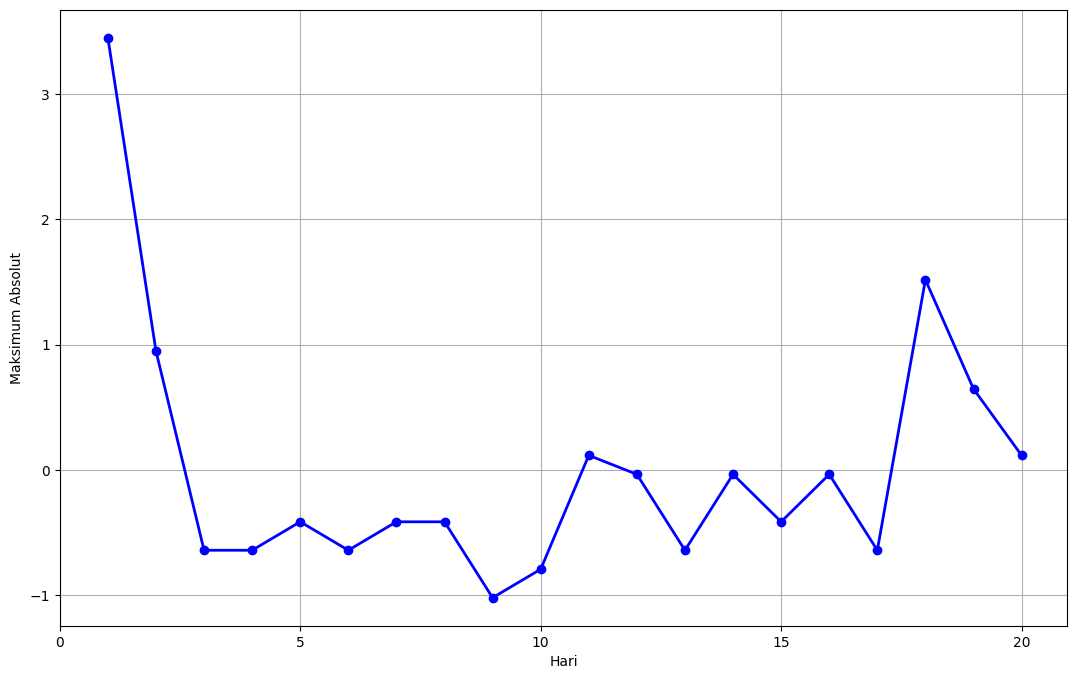

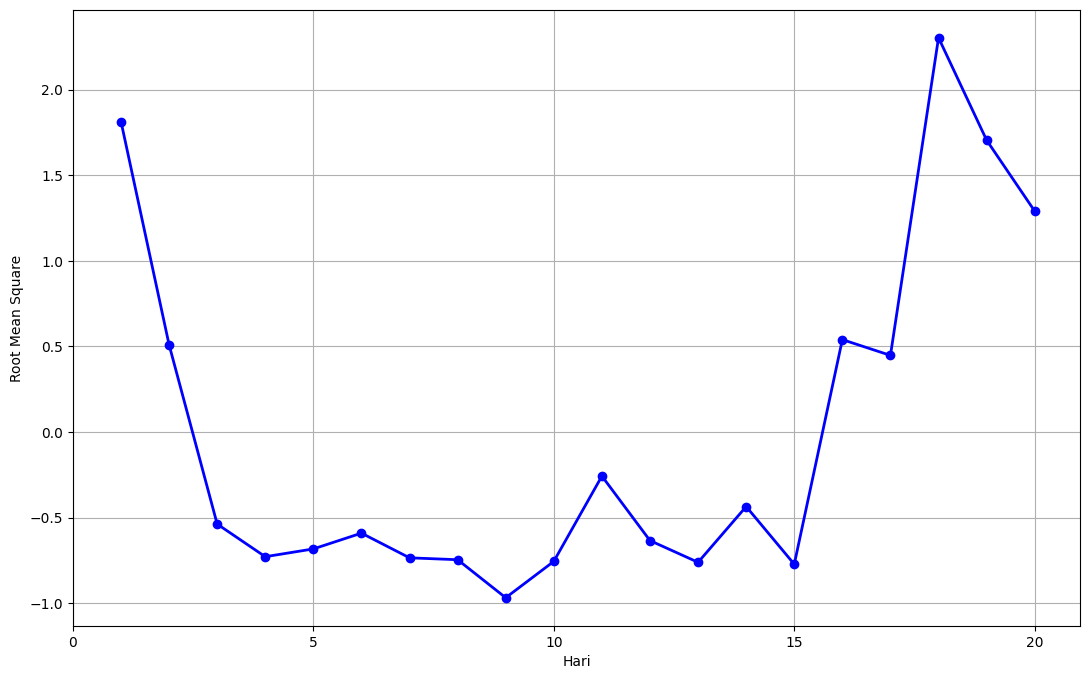

In [192]:
hi.rename(columns={0:'Impulse', 1:'Faktor Puncak', 2:'Entropi', 3:'Peek to Peek', 4:'Maksimum Absolut', 5:'Root Mean Square'}, inplace=True)
columns = list(hi.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(hi.index+1, hi[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,21,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

In [193]:
PCA_loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=hi.columns)
PCA_loadings

PCA1      PCA2
Impulse           0.336773 -0.543707
Faktor Puncak     0.332535 -0.549802
Entropi           0.389326  0.450810
Peek to Peek      0.483487  0.046400
Maksimum Absolut  0.485764 -0.013144
Root Mean Square  0.393324  0.443334

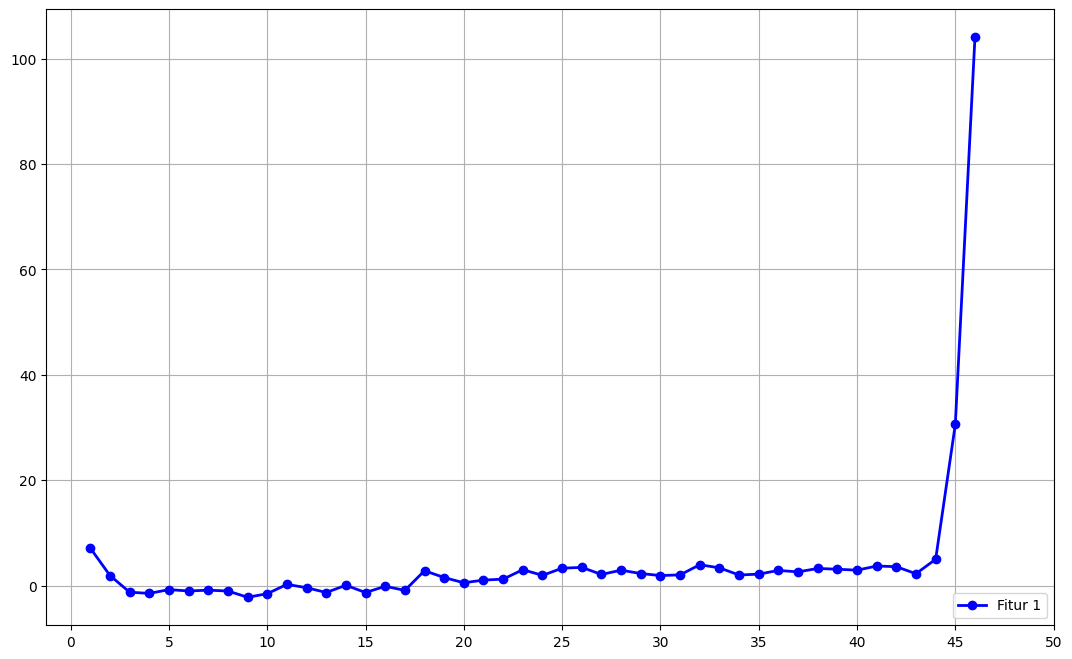

In [194]:
PCA_loadings = PCA_loadings.loc[:,['PCA1']]
hi_svr = health_indicator.copy()

hi_svr = pd.DataFrame(scaler.transform(hi_svr)) # Fitting scaler pada X_train

# Fitting dan transform train data dengan PCA
hi_svr_PCA= np.dot(hi_svr, PCA_loadings)
hi_svr_PCA = pd.DataFrame(hi_svr_PCA, columns =['Fitur 1'])

# Variabel days_cycle dan RUL akan ditambahkan pada dataframe dari data smoothing yang dipilih
# Memasukkan list days_cycle ke dalam dataframe Simple Exponential Smoothing
plt.figure(figsize=(13,8))
hi_plot = plt.plot(hi_svr_PCA.index+1, hi_svr_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
plt.xticks(np.arange(0,51,step=5))
plt.legend(['Fitur 1'], loc=4)
plt.grid()

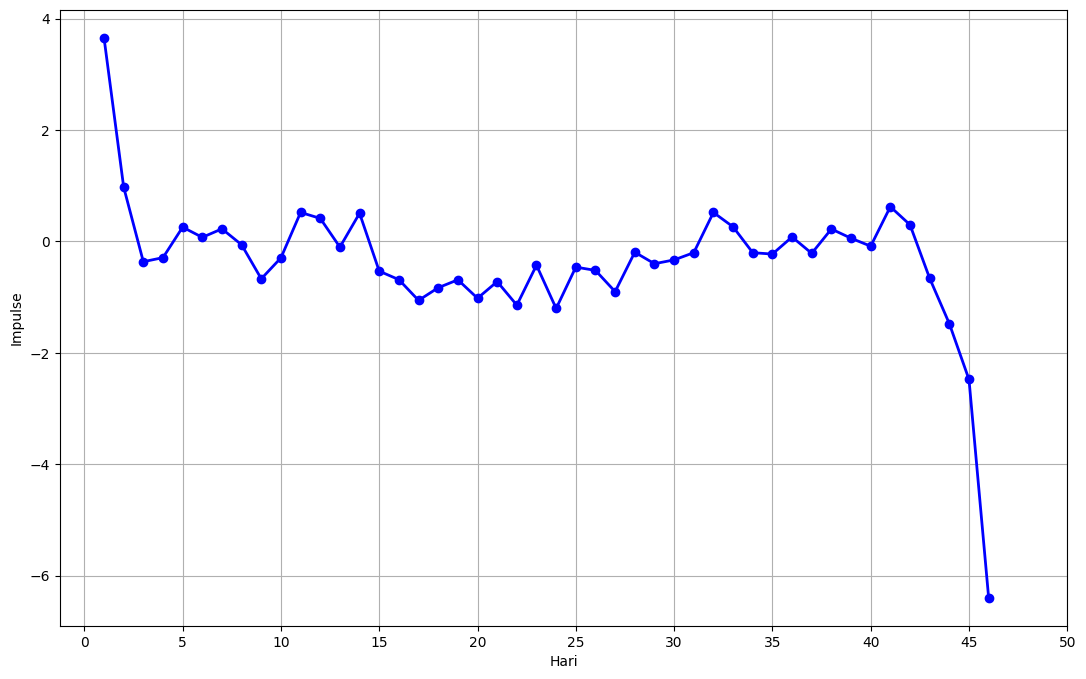

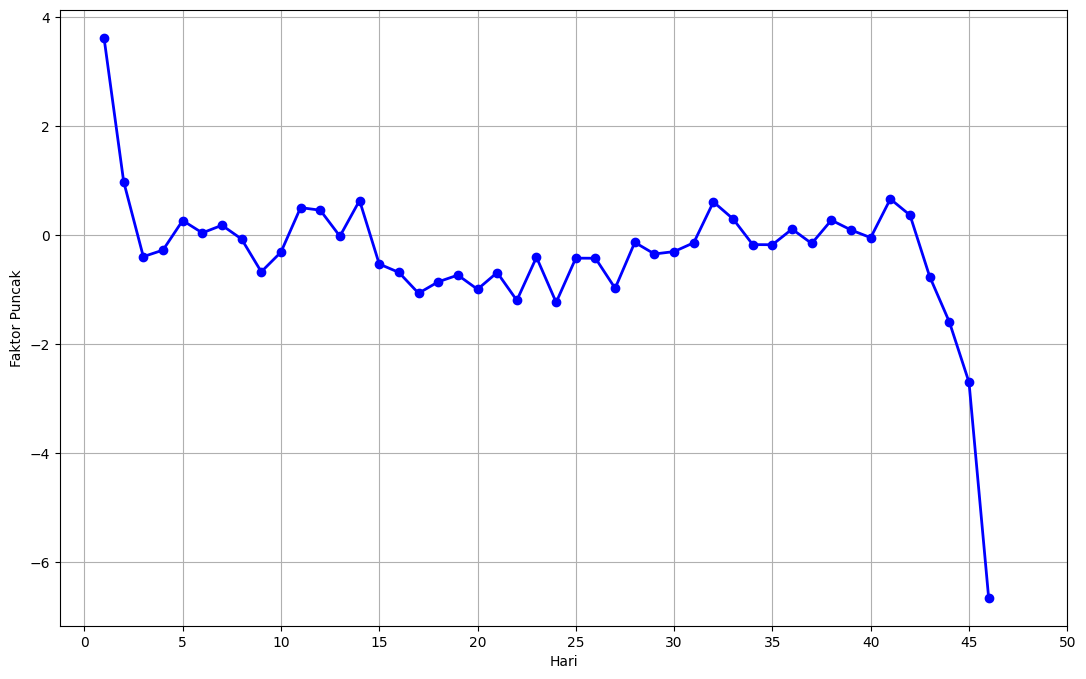

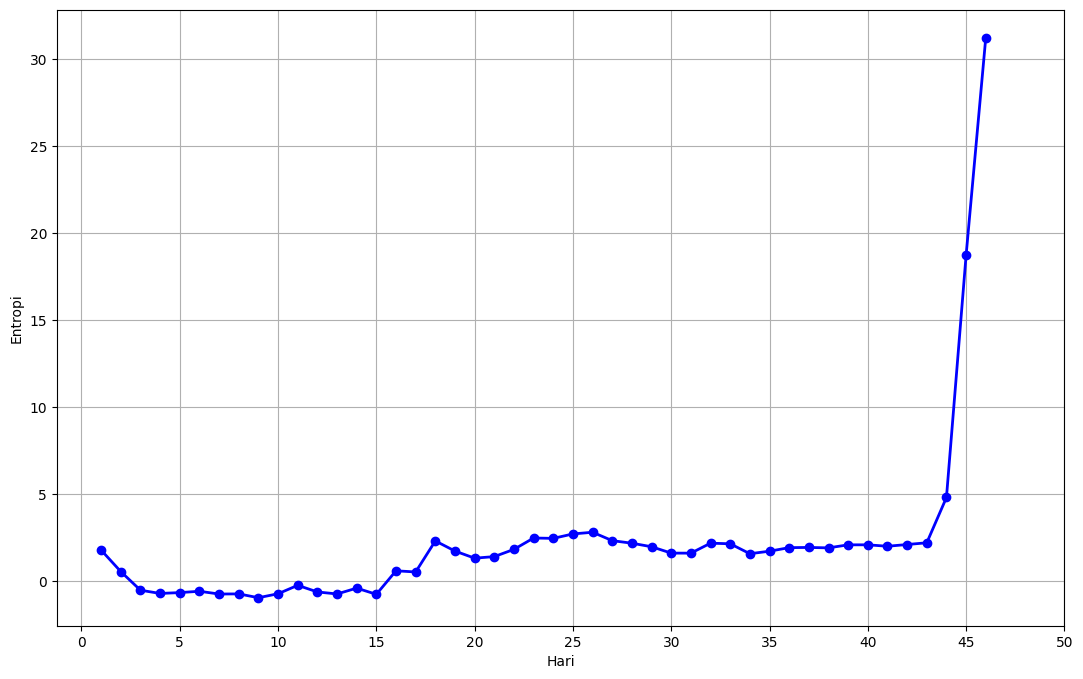

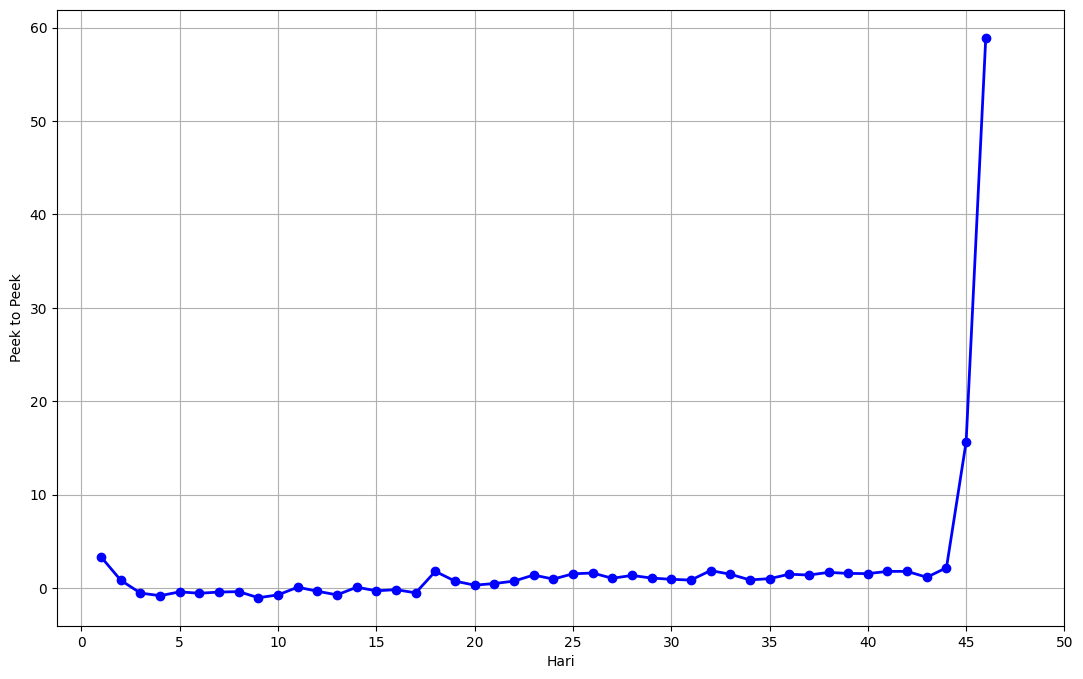

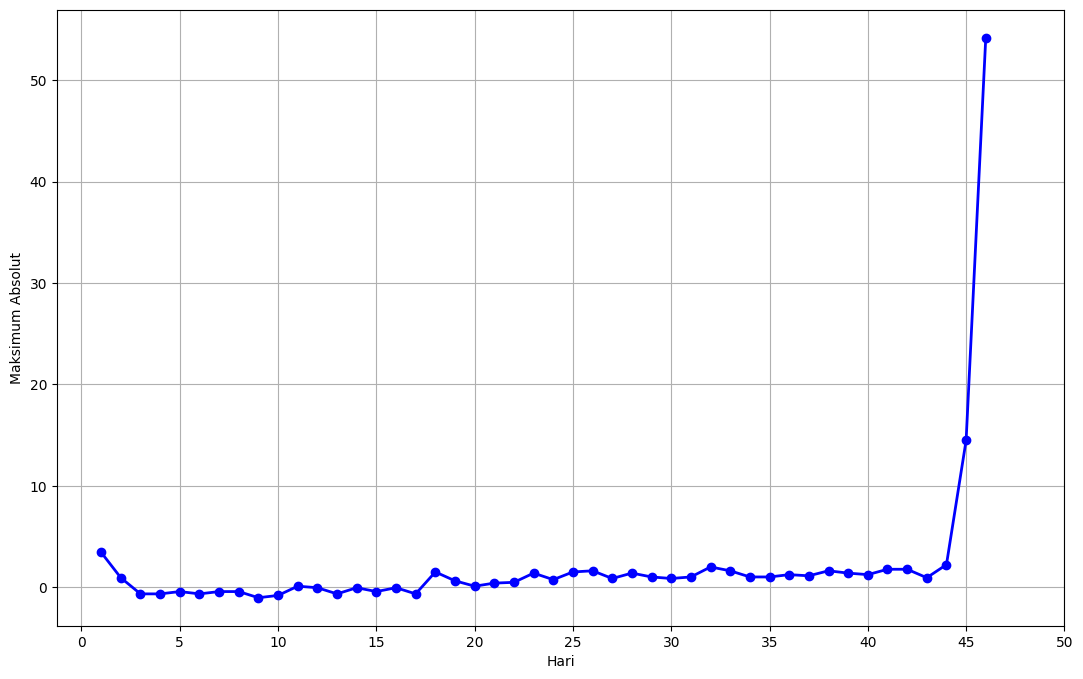

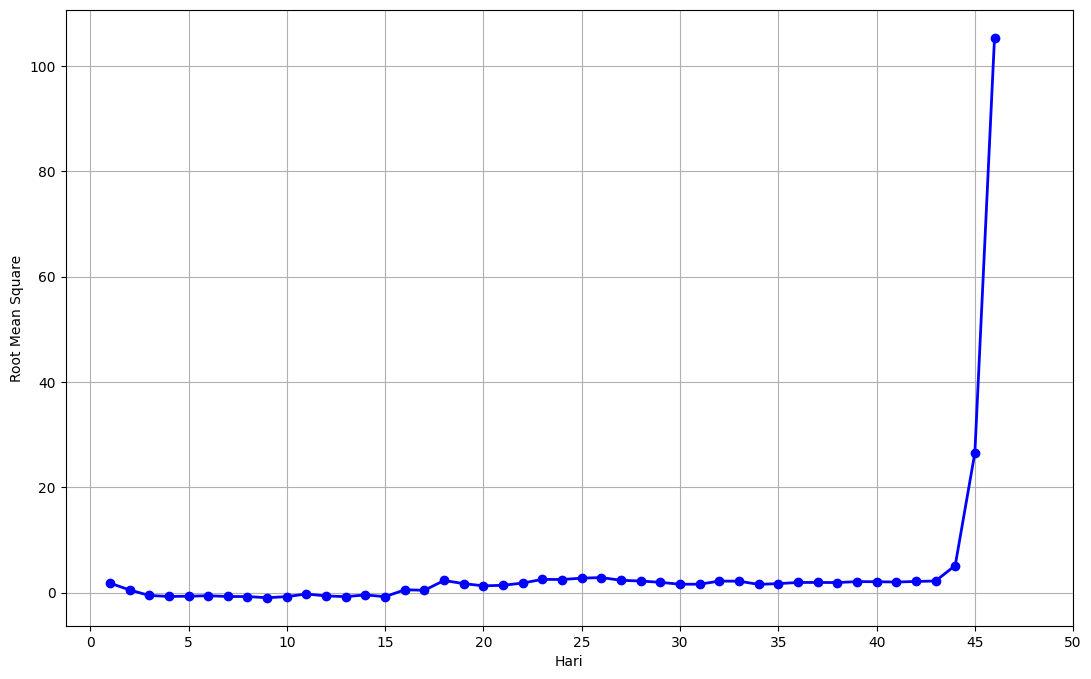

In [195]:
hi_svr.rename(columns={0:'Impulse', 1:'Faktor Puncak', 2:'Entropi', 3:'Peek to Peek', 4:'Maksimum Absolut', 5:'Root Mean Square'}, inplace=True)
columns = list(hi_svr.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(hi_svr.index+1, hi_svr[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,51,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

## Pembuatan Model SVR

In [196]:
# Import modul SVR dan Optuna
# Import modul Scaler untuk preprocessing data
# Install Library Optuna
!pip install optuna
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [197]:
# Pembuatan fungsi pengukuran performa model 
def evaluate(y_true, y_pred, label='test'): # Inisiasi nama fungsi dengan 3 input
    rmse = mean_squared_error(y_true, y_pred, squared=False) # Perhitungan RMSE
    variance = r2_score(y_true, y_pred) # Perhitungan R2
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance)) # Print hasil perhitungan

### Model SVR tanpa PCA

#### Perhitungan nilai RUL

In [198]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 50 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
hi_svr['RUL'] = np.asarray(RUL).flatten()

#### Pembagian Data Train dan Test

In [199]:
train_data = hi_svr.iloc[0:20] # Pembagian training data
test_data = hi_svr.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier

In [200]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:3.75800807473073, R2:0.5752594078273273
test set RMSE:39.268772360973976, R2:-26.41398191534211


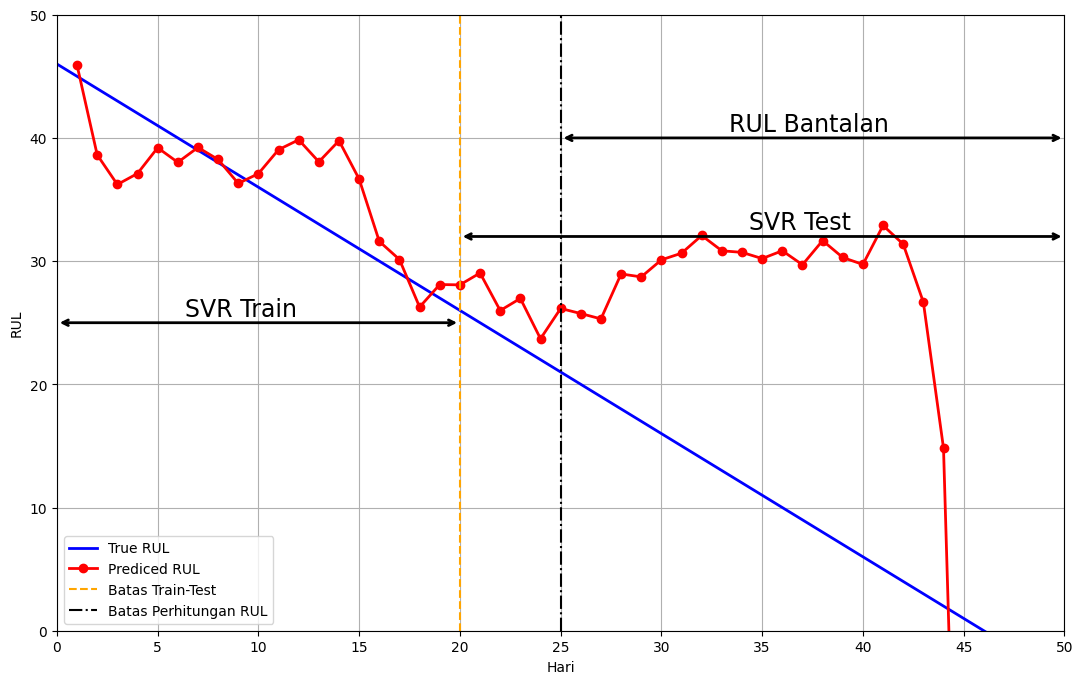

In [201]:
y_pred_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(hi_svr.index+1, y_pred_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna

In [202]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 18:56:32,569] A new study created in memory with name: no-name-551484fd-a0e8-4b40-a62f-51c7bf8008e4
[I 2023-04-10 18:56:32,582] Trial 0 finished with value: 18.470249887987805 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.17, 'coef0': 0.34}. Best is trial 0 with value: 18.470249887987805.
[I 2023-04-10 18:56:32,593] Trial 1 finished with value: 21.262014871159302 and parameters: {'kernel': 'rbf', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.28}. Best is trial 0 with value: 18.470249887987805.
[I 2023-04-10 18:56:32,603] Trial 2 finished with value: 33.61554695729699 and parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'epsilon': 0.2, 'coef0': 0.29000000000000004}. Best is trial 0 with value: 18.470249887987805.
[I 2023-04-10 18:56:32,613] Trial 3 finished with value: 32545.54636558945 and parameters: {'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'epsilon': 0.03, 'coef0': 0.12}. Best is trial 0 with value: 18.47024988798780

In [203]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 18.212967675818103
Best Parameters: {'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'epsilon': 0.06999999999999999, 'coef0': 0.05}


In [204]:
# Pembuatan model dengan SVR
svr = SVR(kernel='poly', degree=2, gamma='auto', epsilon=0.37, coef0=0.05) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:4.351650852218136, R2:0.4304702213650877
test set RMSE:588.7195723627912, R2:-6160.61306458716


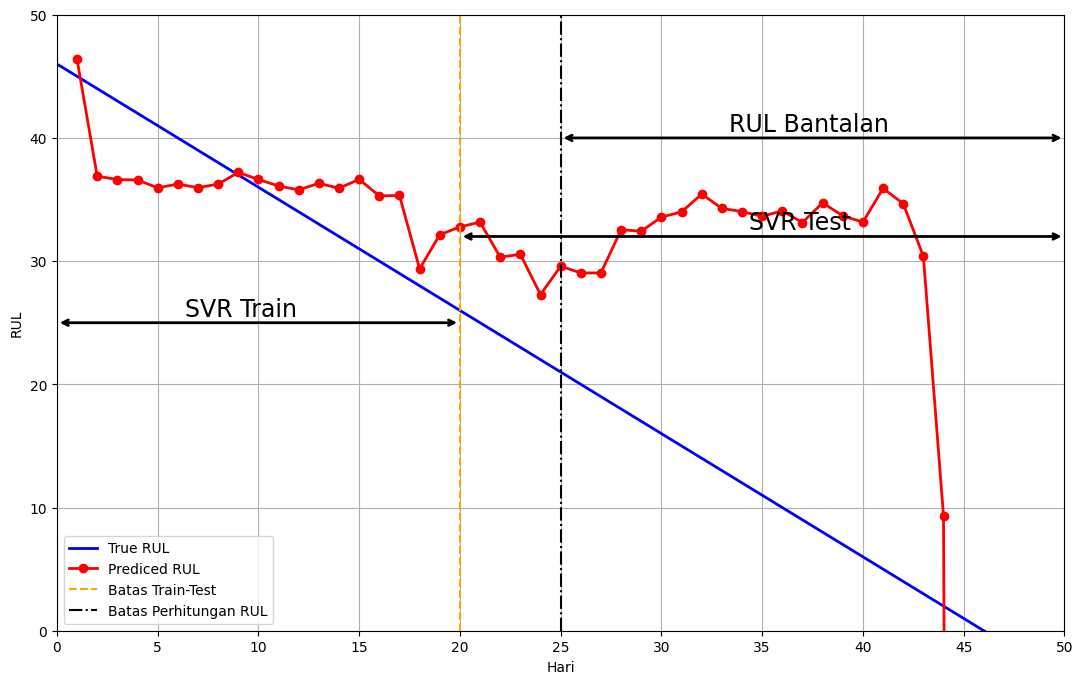

In [205]:
y_pred_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(hi_svr.index+1, y_pred_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

### Model SVR dengan PCA

#### Perhitungan nilai RUL

In [206]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 50 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
hi_svr_PCA['RUL'] = np.asarray(RUL).flatten() 

#### Pembagian Data Train dan Test

In [207]:
train_data = hi_svr_PCA.iloc[0:20] # Pembagian training data
test_data = hi_svr_PCA.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier

In [208]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:5.956088195906984, R2:-0.06691689014804547
test set RMSE:21.139831560066643, R2:-6.944755171342039


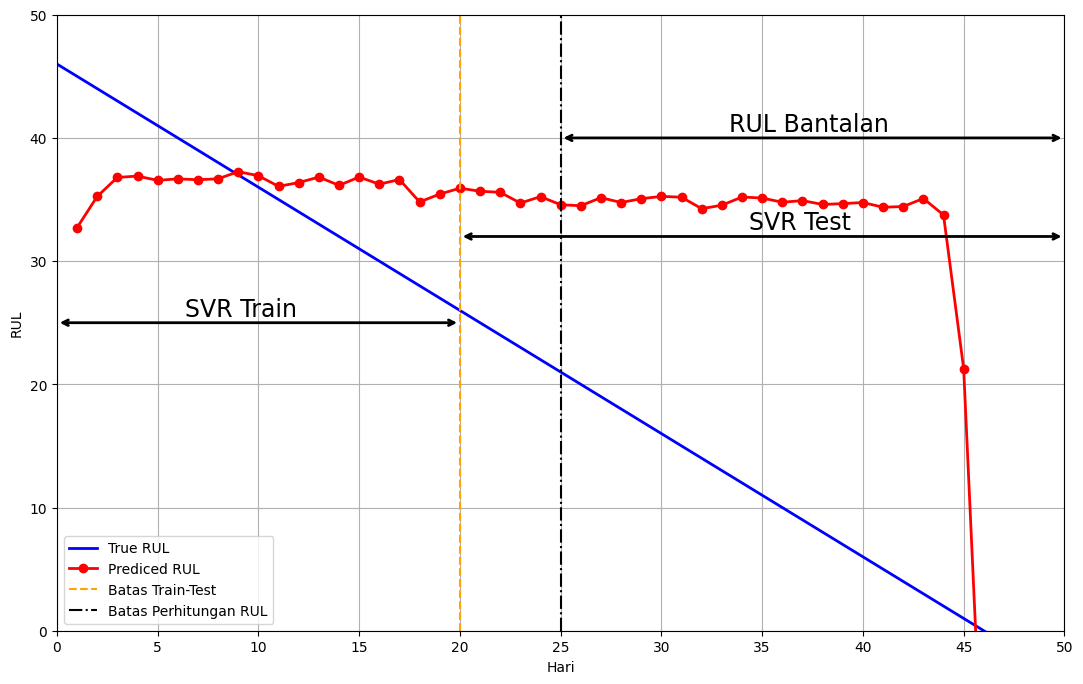

In [209]:
y_predPCA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(hi_svr_PCA.index+1, y_predPCA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna

In [210]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 18:58:08,804] A new study created in memory with name: no-name-537b99b5-924b-4b2c-b09c-60bf6a664ff9
[I 2023-04-10 18:58:08,816] Trial 0 finished with value: 20.844094209509446 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'gamma': 'auto', 'epsilon': 0.34, 'coef0': 0.29000000000000004}. Best is trial 0 with value: 20.844094209509446.
[I 2023-04-10 18:58:08,828] Trial 1 finished with value: 20.809807392150077 and parameters: {'kernel': 'sigmoid', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.38, 'coef0': 0.23}. Best is trial 1 with value: 20.809807392150077.
[I 2023-04-10 18:58:08,837] Trial 2 finished with value: 21.016949000049546 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.21000000000000002, 'coef0': 0.39}. Best is trial 1 with value: 20.809807392150077.
[I 2023-04-10 18:58:08,848] Trial 3 finished with value: 23.31123858129326 and parameters: {'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'epsilon': 0.09999999999999999}. Best i

In [211]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 20.79805683058602
Best Parameters: {'kernel': 'sigmoid', 'degree': 3, 'gamma': 'auto', 'epsilon': 0.06999999999999999, 'coef0': 0.01}


In [212]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear', degree=1, gamma='auto', epsilon=0.24, coef0=0.01) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:5.956088195906984, R2:-0.06691689014804547
test set RMSE:21.139831560066643, R2:-6.944755171342039


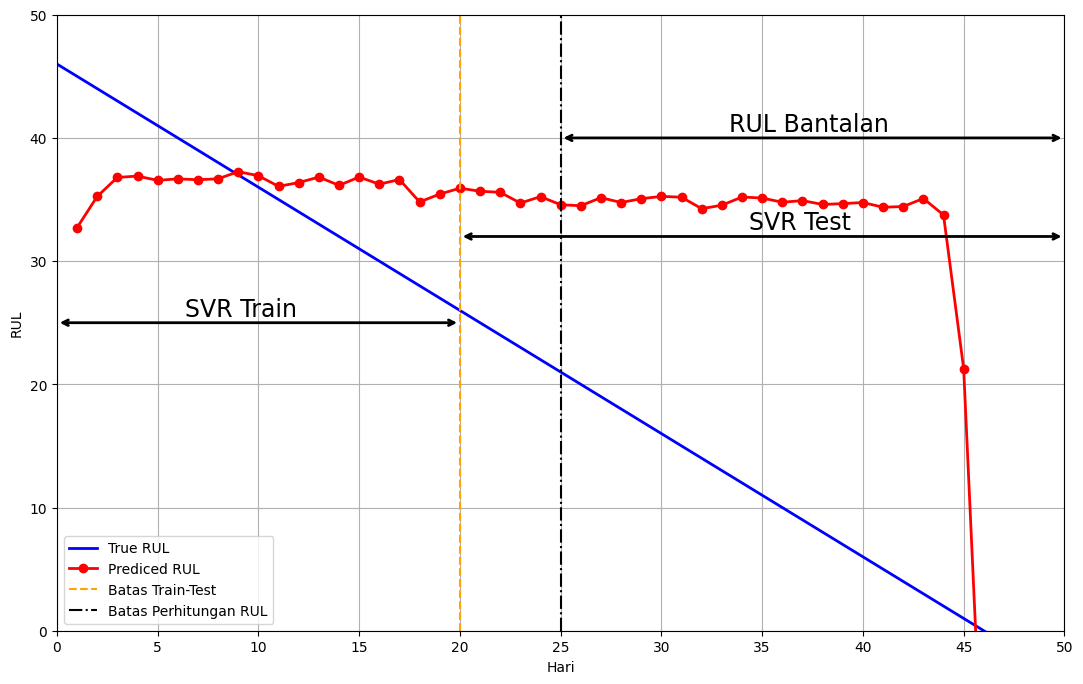

In [213]:
y_predPCA_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(hi_svr_PCA.index+1, y_predPCA_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

# Gaussian Method Smoothing

## Pembuatan Fitur PCA

In [214]:
from scipy.ndimage import gaussian_filter1d

# Gaussian smoothing dengan sigma 3
smoothing_gaussian = pd.DataFrame()
for col in health_indicator:
  smoothing_gaussian[col] = gaussian_filter1d(health_indicator[col], sigma=3)

# Mengambil 20 baris pertama dari hasil smoothing
hi = smoothing_gaussian.copy().iloc[:20]

# Scaling menggunakan StandardScaler()
scaler = StandardScaler()
hi = pd.DataFrame(scaler.fit_transform(hi))

# PCA
pca = PCA()
hi_PCA = pca.fit_transform(hi)

# Variance ratio hasil PCA
PCA_explained_variance_ratio = pd.DataFrame(pca.explained_variance_ratio_)
PCA_explained_variance_ratio.rename({0:'Fitur 1', 1:'Fitur 2', 2:'Fitur 3', 3:'Fitur 4', 4:'Fitur 5', 5:'Fitur 6'}, axis=0, inplace=True)
PCA_explained_variance_ratio.rename({0:'Variance Ratio'}, axis=1, inplace=True)

PCA_explained_variance_ratio

Variance Ratio
Fitur 1    6.163103e-01
Fitur 2    3.833251e-01
Fitur 3    3.422793e-04
Fitur 4    2.122641e-05
Fitur 5    9.638616e-07
Fitur 6    7.619467e-08

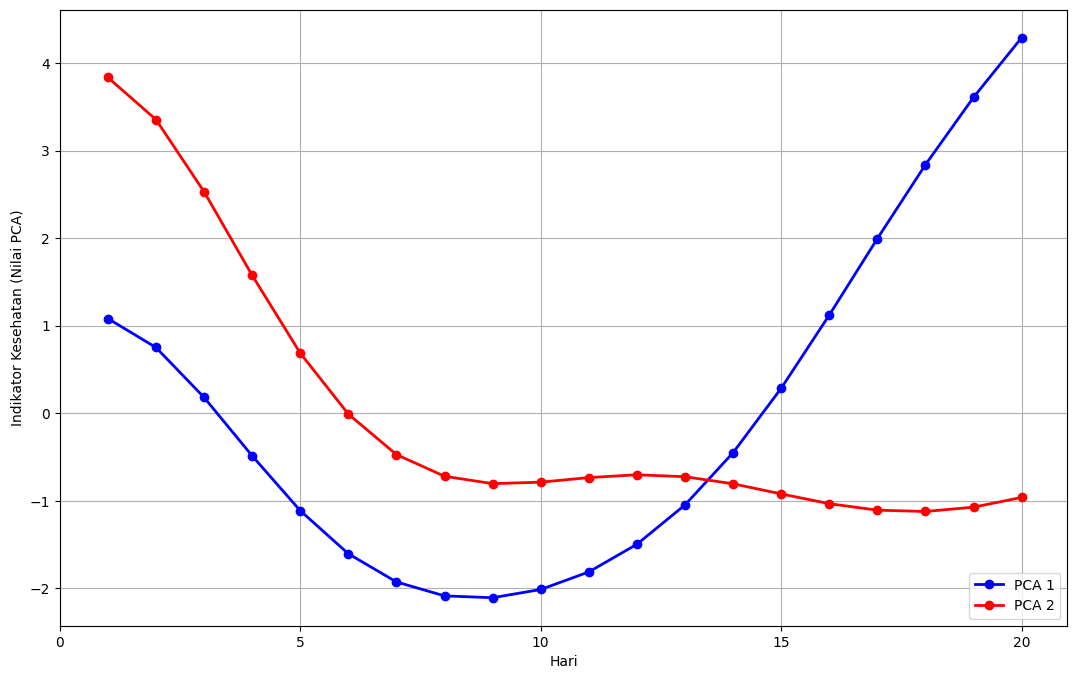

In [215]:
pca = PCA(n_components=2)

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
hi_PCA= pd.DataFrame(hi_PCA, columns=['Fitur 1', 'Fitur 2'])
plt.figure(figsize=(13,8))
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 2'], linestyle='-', marker='o', color='red', linewidth=2)
plt.xticks(np.arange(0,21,step=5))
plt.legend(['PCA 1', 'PCA 2'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

In [216]:
scaler_parameter = pd.DataFrame([scaler.scale_, scaler.mean_, scaler.var_]).T
scaler_parameter.rename(columns={0:'Scale', 1:'Mean', 2:'Variances'}, index={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi',
                                                                             3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
scaler_parameter

Scale      Mean  Variances
Faktor Impuls       0.116230  5.925000   0.013509
Faktor Puncak       0.084687  4.690830   0.007172
Entropi             0.023597  4.462743   0.000557
Peak to Peak (P2P)  0.009335  0.464562   0.000087
Rata-Rata Absolut   0.005151  0.242758   0.000027
Faktor Clearence    0.001235  0.051679   0.000002

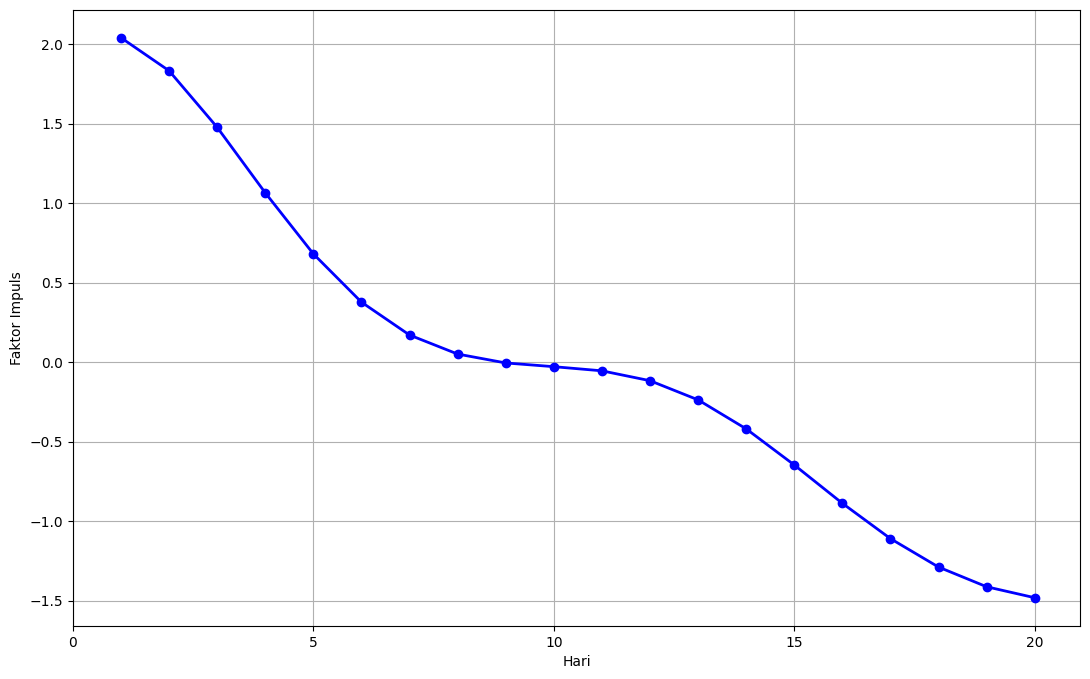

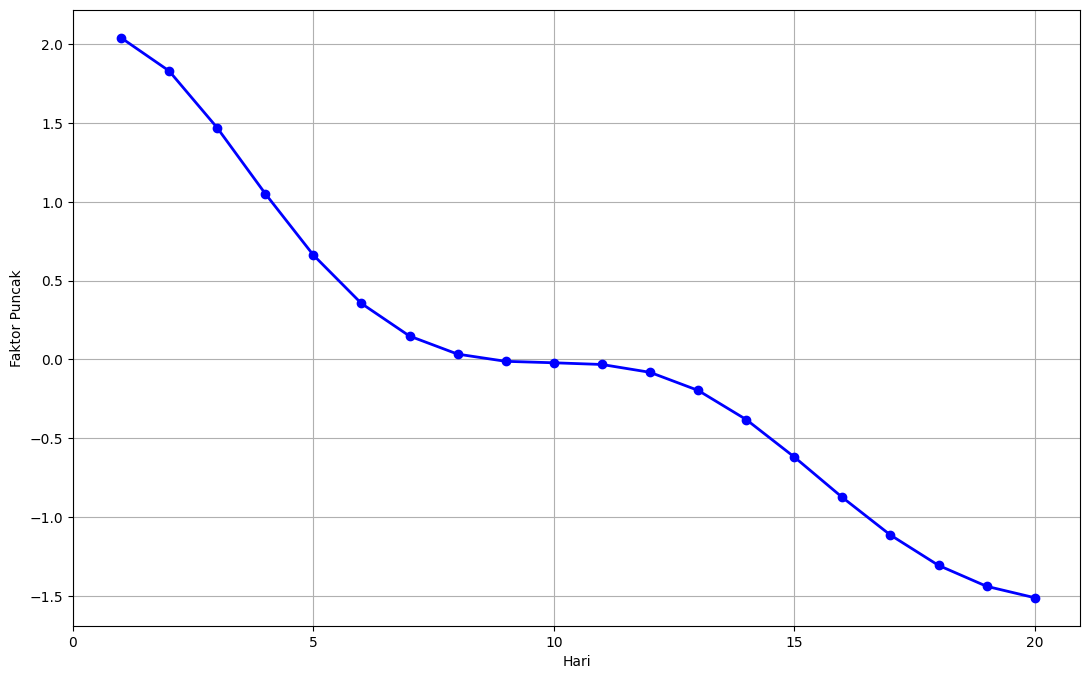

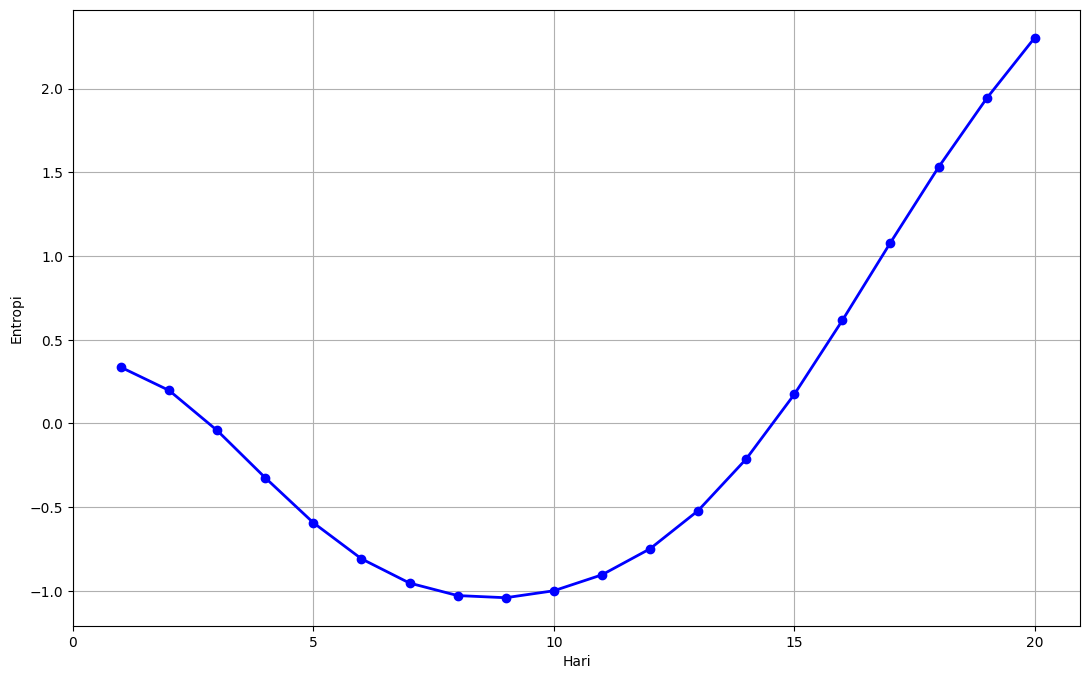

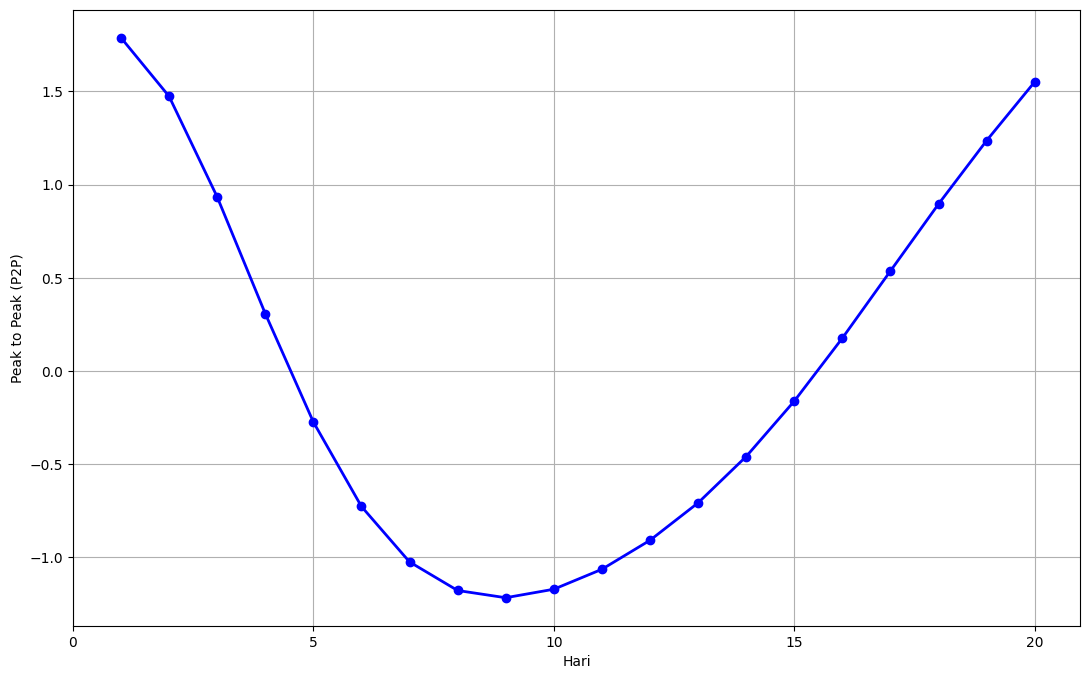

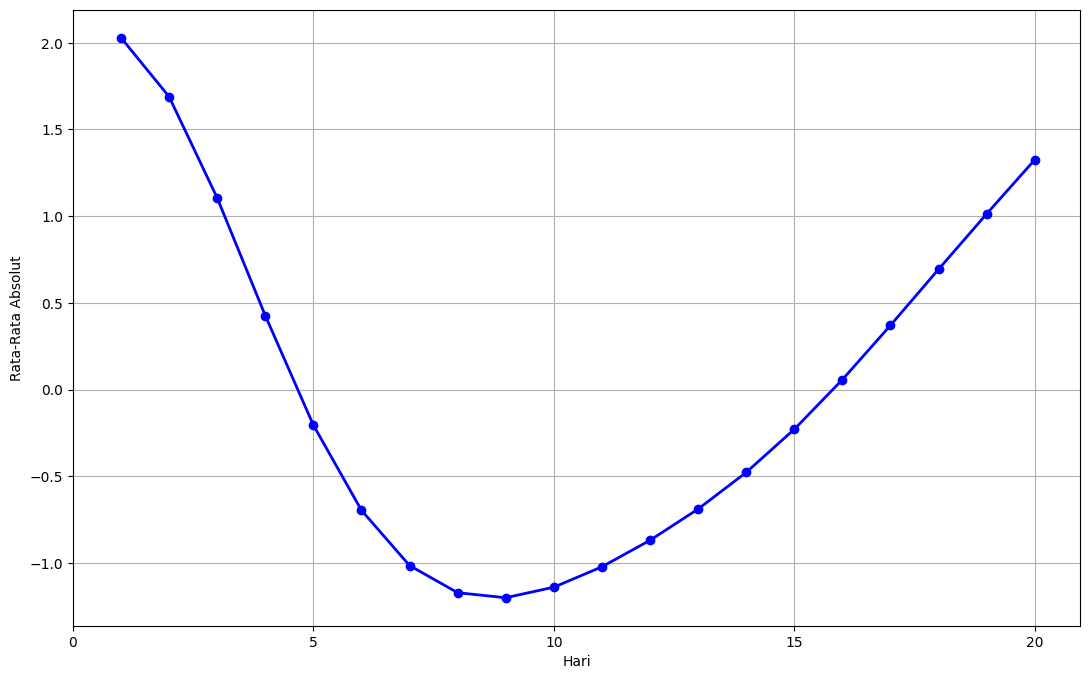

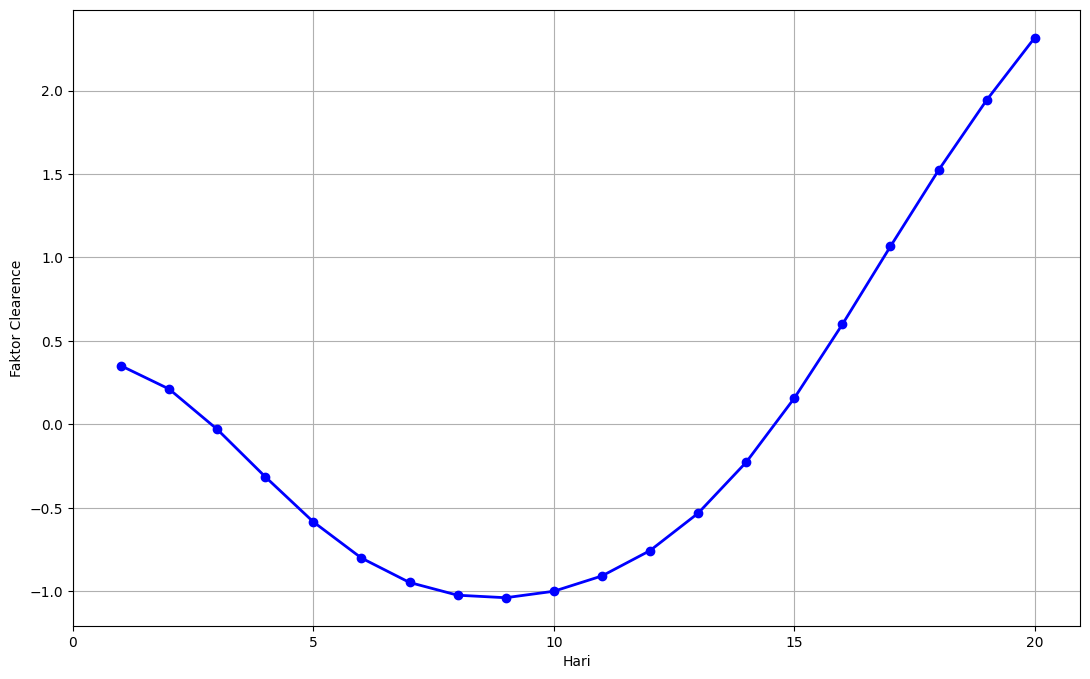

In [217]:
hi.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(hi.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(hi.index+1, hi[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,21,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

In [218]:
PCA_loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=hi.columns)
PCA_loadings

PCA1      PCA2
Faktor Impuls      -0.218754  0.598017
Faktor Puncak      -0.222470  0.595989
Entropi             0.518154 -0.054850
Peak to Peak (P2P)  0.446345  0.338223
Rata-Rata Absolut   0.407704  0.408994
Faktor Clearence    0.518385 -0.049931

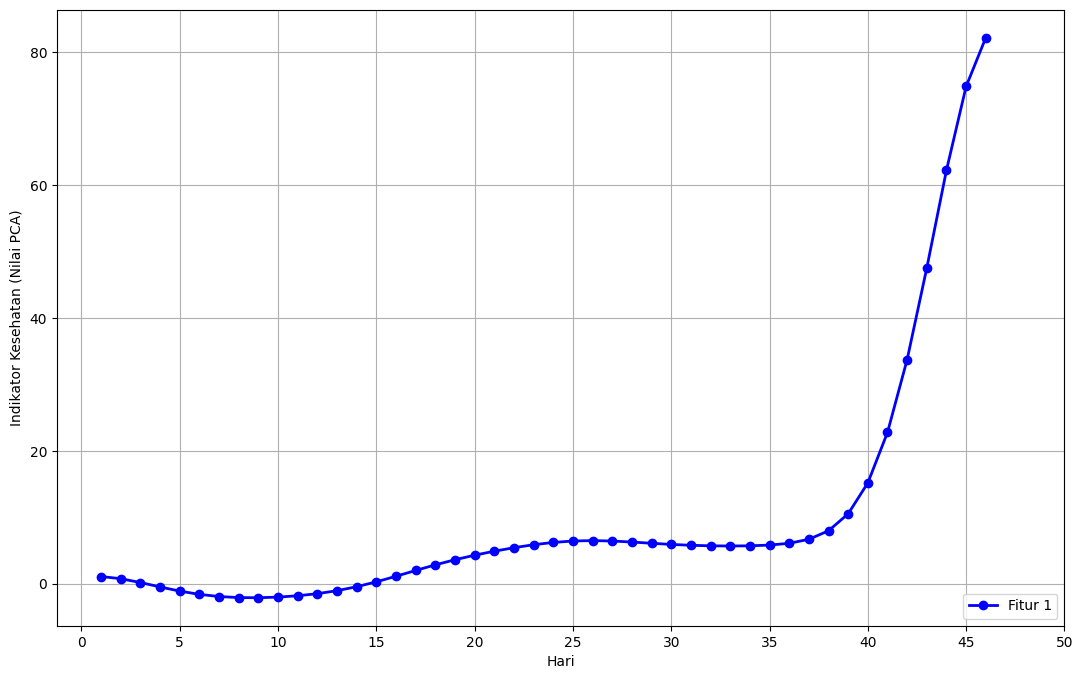

In [219]:
# Membuat fungsi PCA dengan 3 Principal Component 
# svd_solver = full ==> run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing
PCA_loadings = PCA_loadings.loc[:,['PCA1']]
smoothing_gaussian = pd.DataFrame(scaler.transform(smoothing_gaussian)) # Fitting scaler pada X_train

# Fitting dan transform train data dengan PCA
smoothing_gaussian_PCA = np.dot(smoothing_gaussian, PCA_loadings)
smoothing_gaussian_PCA = pd.DataFrame(smoothing_gaussian_PCA, columns =['Fitur 1'])

# Variabel days_cycle dan RUL akan ditambahkan pada dataframe dari data smoothing yang dipilih
plt.figure(figsize=(13,8))
hi_plot = plt.plot(smoothing_gaussian_PCA.index+1, smoothing_gaussian_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
plt.xticks(np.arange(0,51,step=5))
plt.legend(['Fitur 1'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

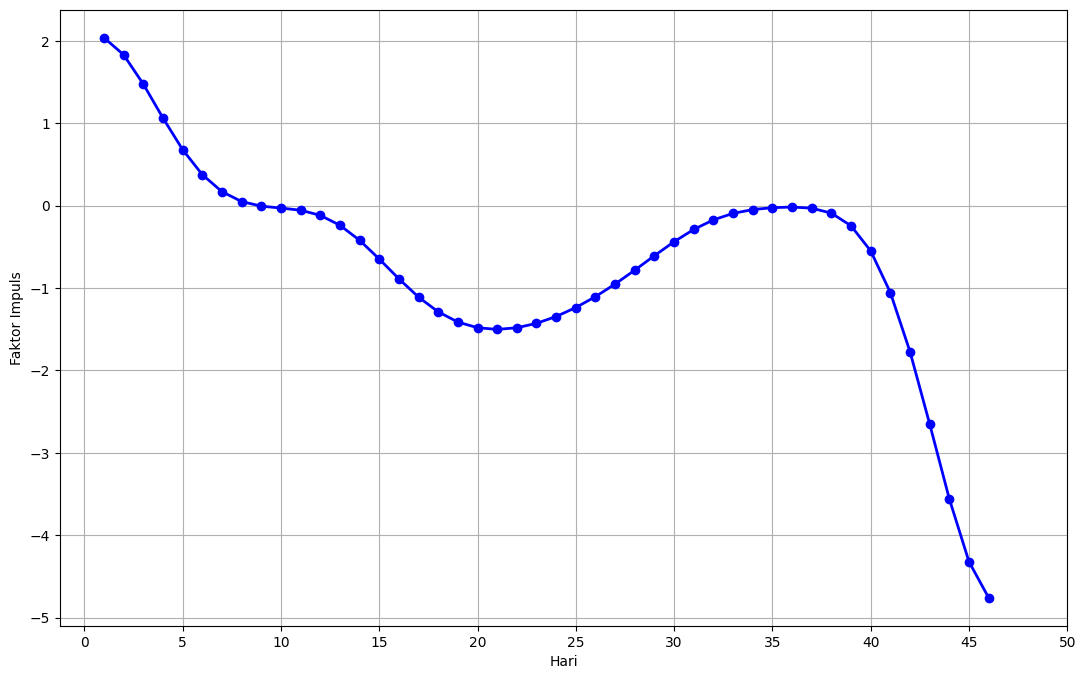

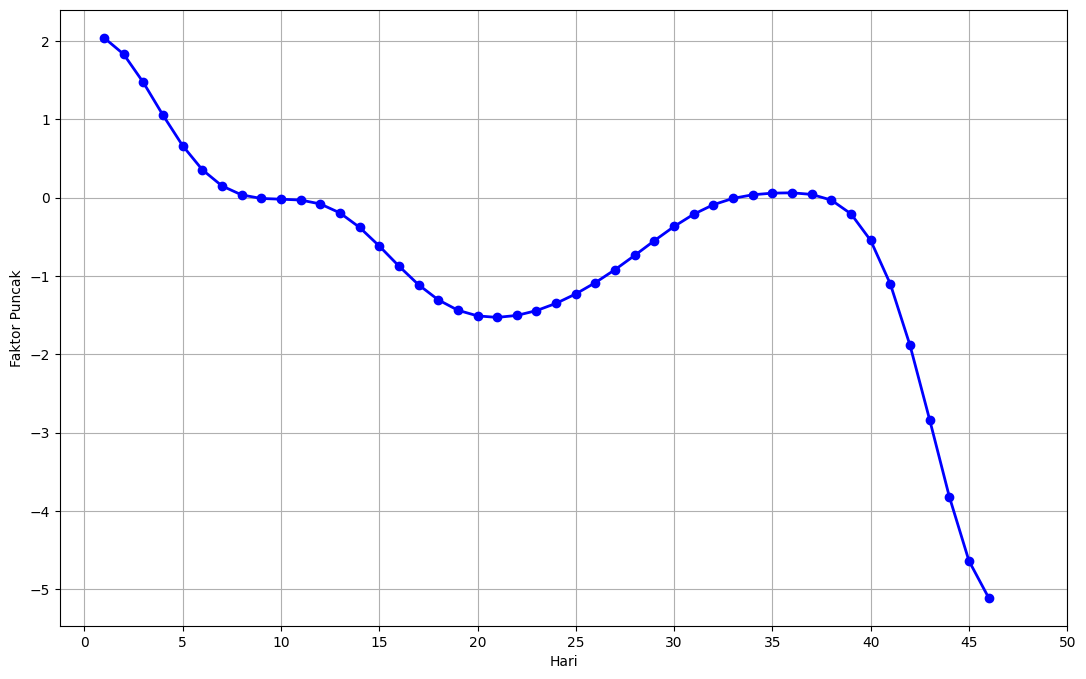

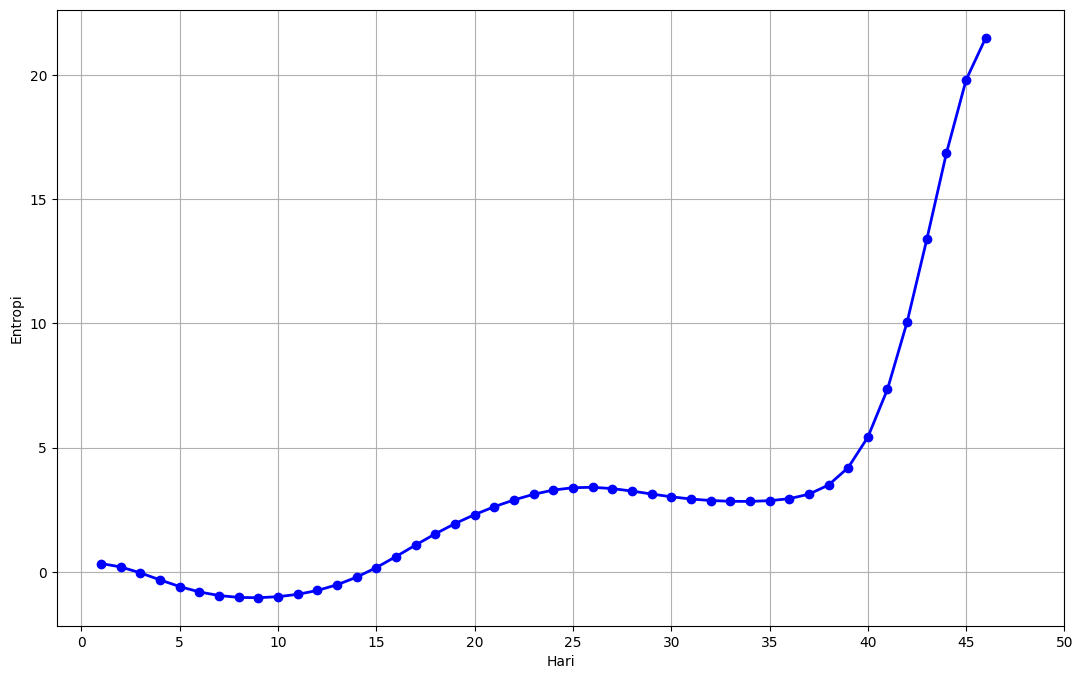

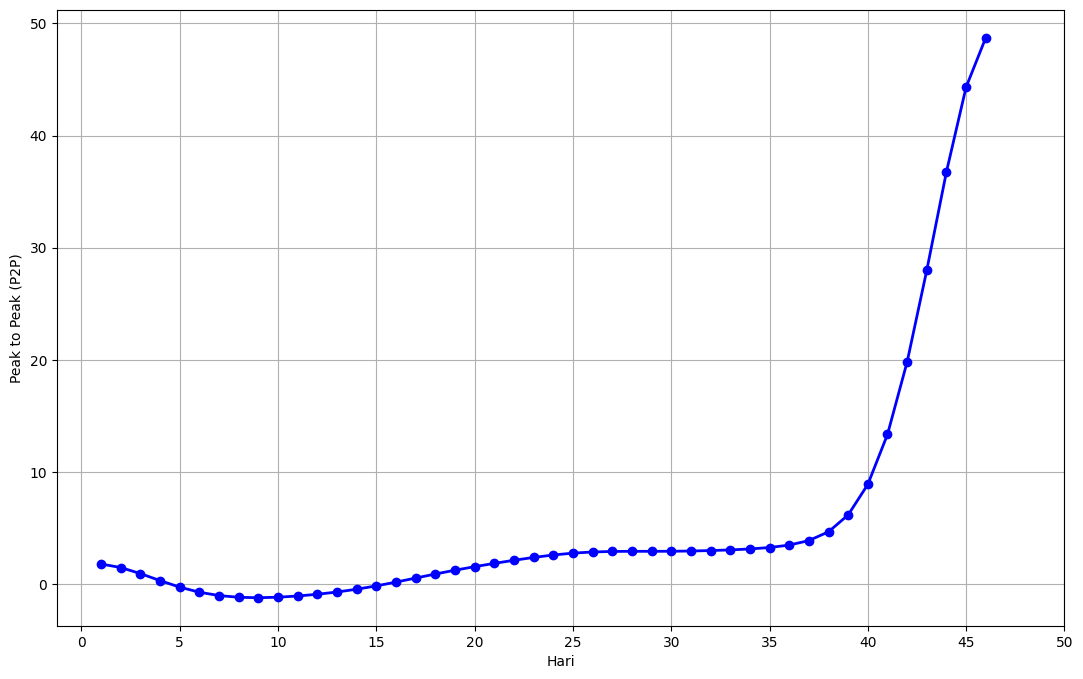

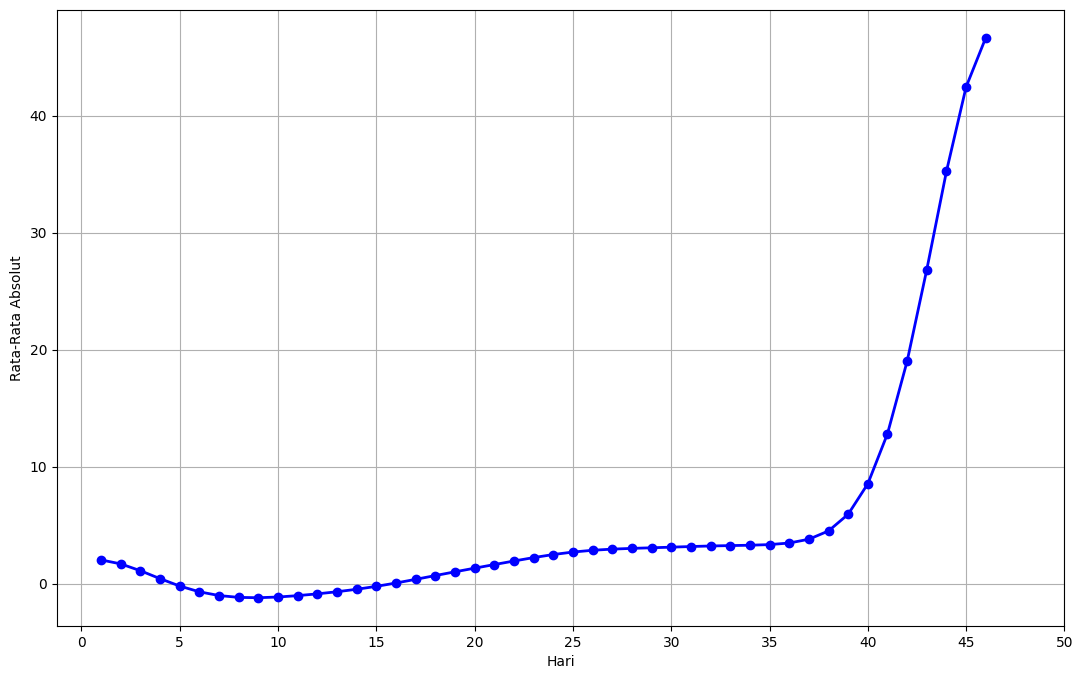

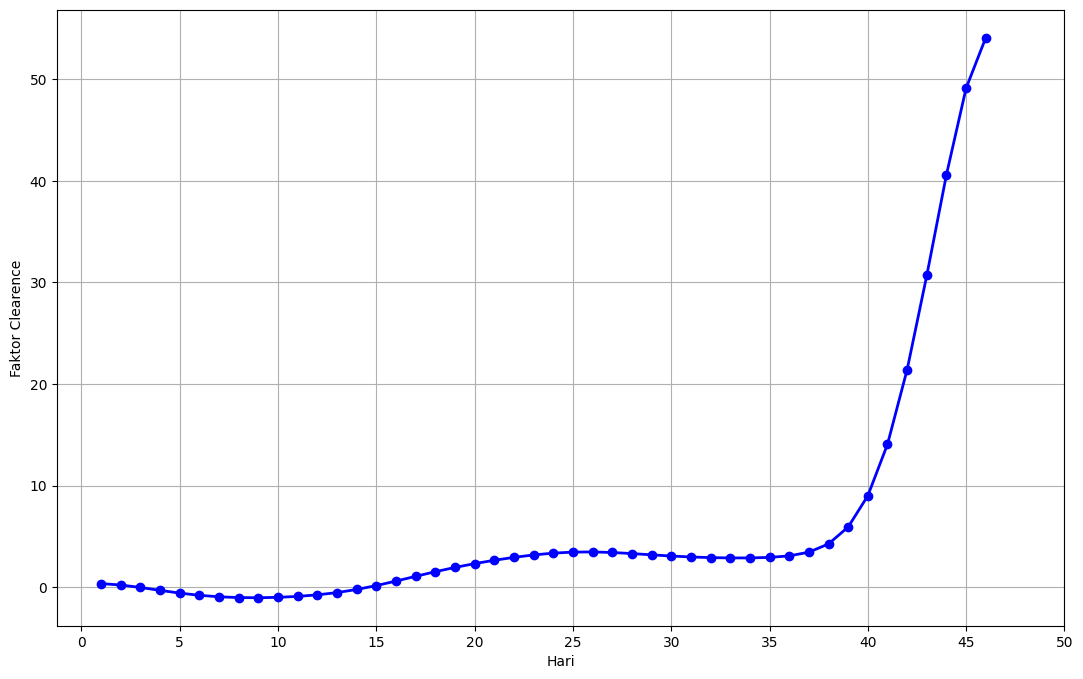

In [220]:
smoothing_gaussian.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(smoothing_gaussian.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(smoothing_gaussian.index+1, smoothing_gaussian[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,51,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

## Pembuatan Model SVR

### Model SVR tanpa PCA

#### Perhitungan RUL

In [221]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 50 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_gaussian['RUL'] = np.asarray(RUL).flatten()

#### Pembagian Data Train dan Test

In [222]:
train_data = smoothing_gaussian.iloc[0:20] # Pembagian training data
test_data = smoothing_gaussian.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linear

In [223]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:1.1831155108755773, R2:0.9579018853511465
test set RMSE:15.295375143189734, R2:-3.1590844581494473


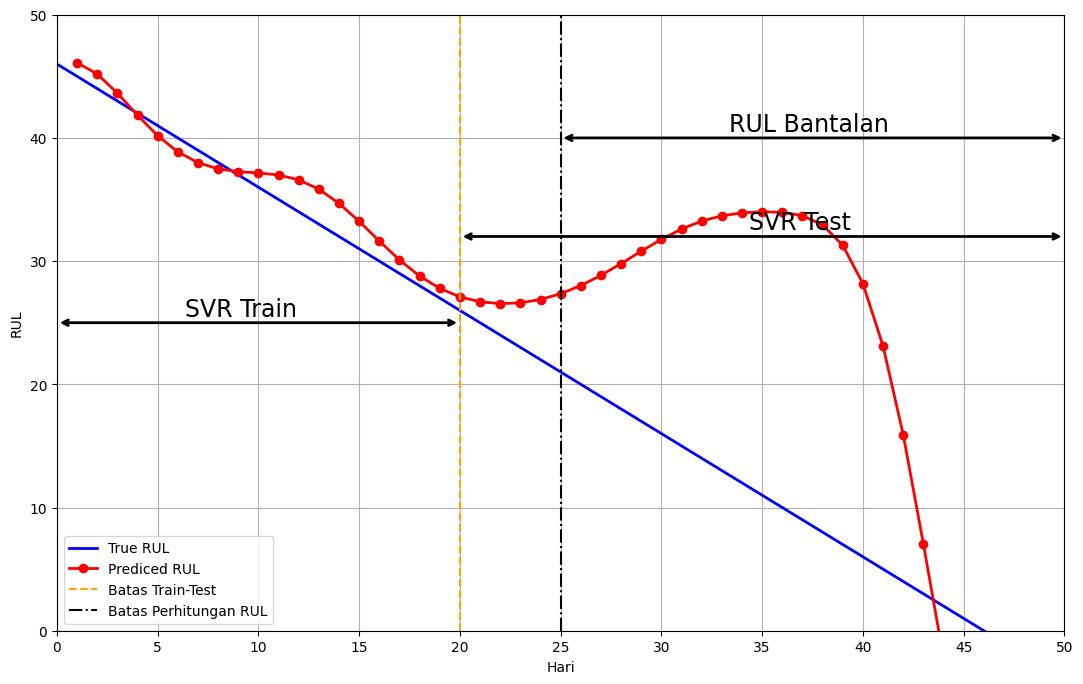

In [224]:
y_predGAU_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_gaussian.index+1, y_predGAU_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna

In [225]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 18:59:50,535] A new study created in memory with name: no-name-58d55346-b46d-442f-a160-50dbf9cf830e
[I 2023-04-10 18:59:50,555] Trial 0 finished with value: 22.655256965321424 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.09999999999999999}. Best is trial 0 with value: 22.655256965321424.
[I 2023-04-10 18:59:50,570] Trial 1 finished with value: 22.655946702117856 and parameters: {'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'epsilon': 0.32}. Best is trial 0 with value: 22.655256965321424.
[I 2023-04-10 18:59:50,577] Trial 2 finished with value: 15.33364800821724 and parameters: {'kernel': 'linear', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.17}. Best is trial 2 with value: 15.33364800821724.
[I 2023-04-10 18:59:50,586] Trial 3 finished with value: 22.655256965321424 and parameters: {'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'epsilon': 0.15000000000000002}. Best is trial 2 with value: 15.33364800821724.
[I 2023-04-10 18:59:50,595] Tr

In [226]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 15.232475649282133
Best Parameters: {'kernel': 'linear', 'degree': 3, 'gamma': 'auto', 'epsilon': 0.01}


In [227]:
# Pembuatan model dengan SVR
svr = SVR(kernel='poly', degree=1, gamma='auto', epsilon=0.35, coef0=0.32) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:1.2971153522862342, R2:0.9493982485071687
test set RMSE:15.248332349412616, R2:-3.133540256678102


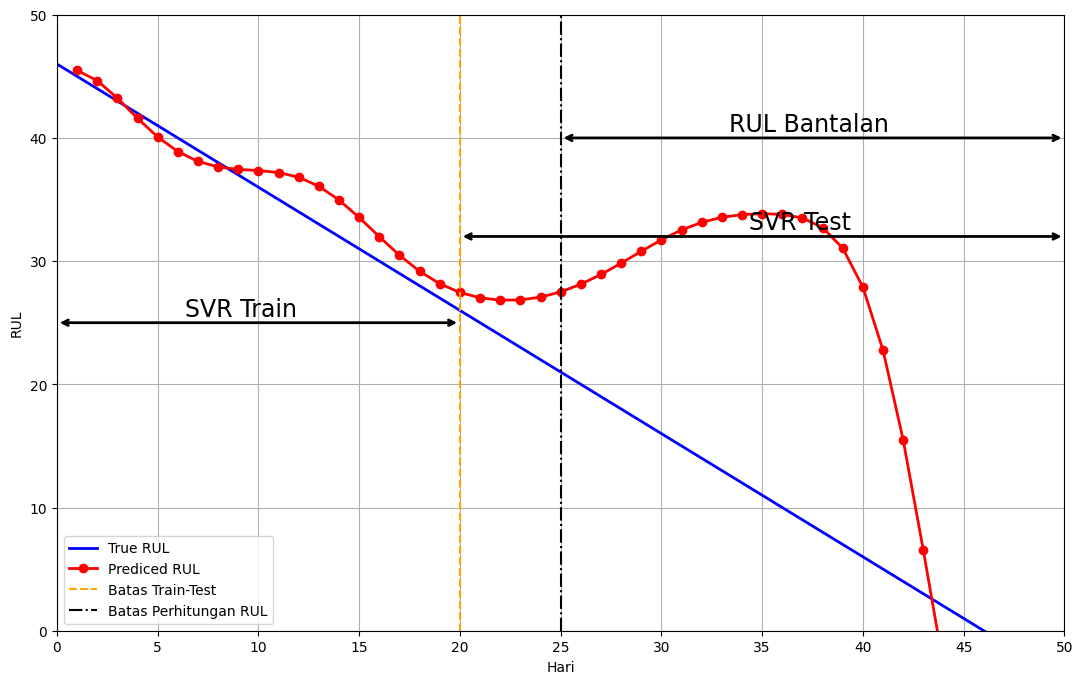

In [228]:
y_predGAU_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_gaussian.index+1, y_predGAU_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

### Model SVR Dengan PCA GAU

#### Perhitungan RUL

In [229]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 50 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_gaussian_PCA['RUL'] = np.asarray(RUL).flatten() # Memasukkan list days_cycle ke dalam dataframe Simple Exponential Smoothing

#### Pembagian Data Train dan Test

In [230]:
train_data = smoothing_gaussian_PCA.iloc[0:20] # Pembagian training data
test_data = smoothing_gaussian_PCA.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linear GAU

In [231]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:5.33271431471105, R2:0.1447265575240858
test set RMSE:34.78395542932139, R2:-20.50975209438252


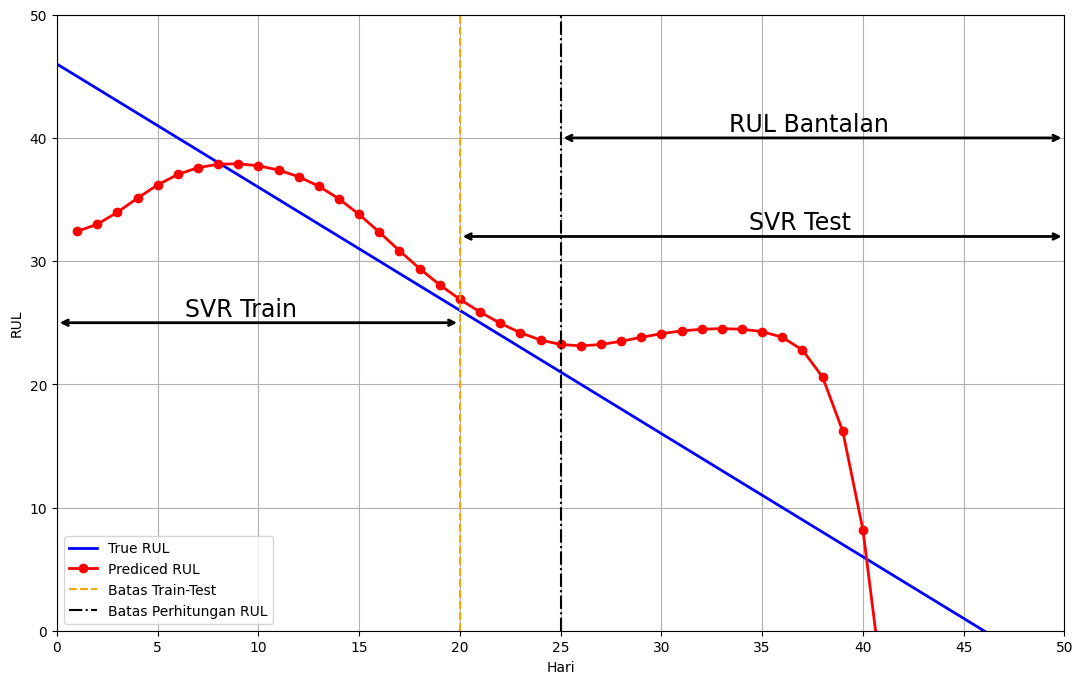

In [232]:
y_predGAUPCA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_gaussian_PCA.index+1, y_predGAUPCA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna GAU

In [233]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 19:00:46,097] A new study created in memory with name: no-name-08950578-567a-41a4-b47b-dd93dc80c540
[I 2023-04-10 19:00:46,120] Trial 0 finished with value: 35.19395056170389 and parameters: {'kernel': 'linear', 'degree': 1, 'gamma': 'auto', 'epsilon': 0.04}. Best is trial 0 with value: 35.19395056170389.
[I 2023-04-10 19:00:46,130] Trial 1 finished with value: 20.806830167855033 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.18000000000000002}. Best is trial 1 with value: 20.806830167855033.
[I 2023-04-10 19:00:46,140] Trial 2 finished with value: 21.271032282328132 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'epsilon': 0.08}. Best is trial 1 with value: 20.806830167855033.
[I 2023-04-10 19:00:46,149] Trial 3 finished with value: 18.858126676613583 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.38, 'coef0': 0.08}. Best is trial 3 with value: 18.858126676613583.
[I 2023-04-10 19:00:46,15

In [234]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 18.28129334589232
Best Parameters: {'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'epsilon': 0.18000000000000002, 'coef0': 0.4}


In [235]:
# Pembuatan model dengan SVR
svr = SVR(kernel='poly', degree=2, gamma='auto', epsilon=0.2, coef0=0.12) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:4.8455616156487515, R2:0.2938506053819988
test set RMSE:396.25805254966485, R2:-2790.4745637413857


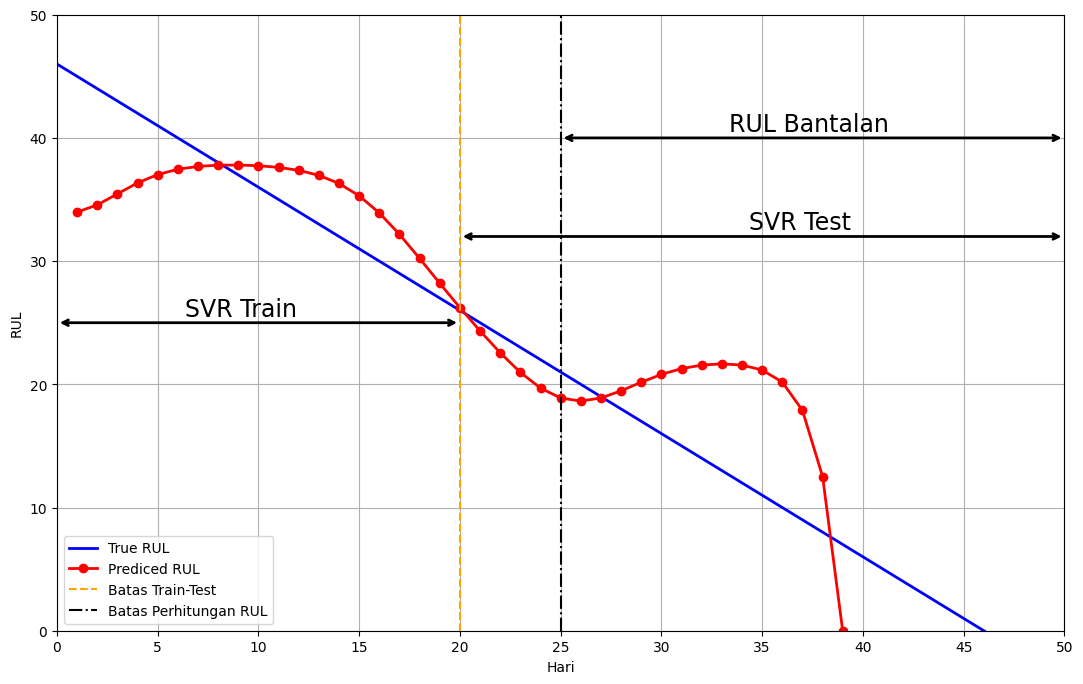

In [236]:
y_predGAUPCA_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_gaussian_PCA.index+1, y_predGAUPCA_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

# Simple Exponential Smoothing atau Exponential Moving Average

## Pembuatan Fitur PCA

In [237]:
hi = smoothing_EMA15.copy().iloc[:20]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler() # Pendefinisian scaler
hi = pd.DataFrame(scaler.fit_transform(hi)) # Fitting scaler pada X_train

from sklearn.decomposition import PCA
pca = PCA()

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
PCA_explained_variance_ratio= pd.DataFrame(pca.explained_variance_ratio_)
PCA_explained_variance_ratio.rename({0:'Fitur 1', 1:'Fitur 2', 2:'Fitur 3', 3:'Fitur 4', 
                                     4:'Fitur 5', 5:'Fitur 6'}, axis=0, inplace=True)
PCA_explained_variance_ratio.rename({0:'Variance Ratio'}, axis=1, inplace=True)
PCA_explained_variance_ratio

Variance Ratio
Fitur 1        0.812335
Fitur 2        0.186754
Fitur 3        0.000748
Fitur 4        0.000124
Fitur 5        0.000034
Fitur 6        0.000004

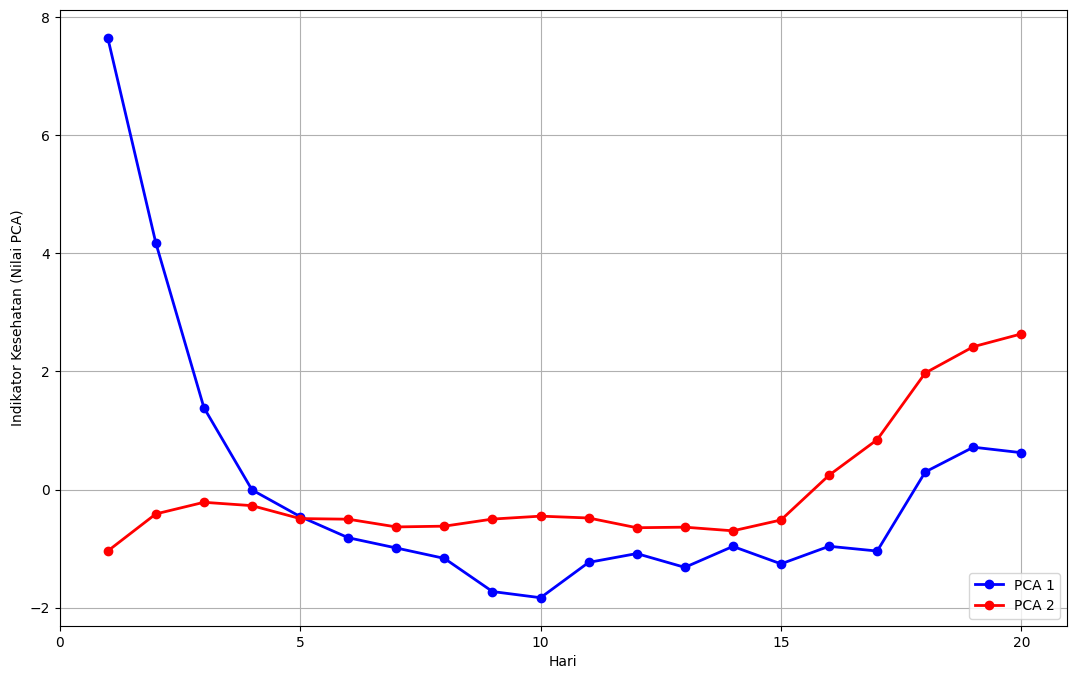

In [238]:
pca = PCA(n_components=2)

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
hi_PCA= pd.DataFrame(hi_PCA, columns=['Fitur 1', 'Fitur 2'])
plt.figure(figsize=(13,8))
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 2'], linestyle='-', marker='o', color='red', linewidth=2)
plt.xticks(np.arange(0,21,step=5))
plt.legend(['PCA 1', 'PCA 2'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

In [239]:
scaler_parameter = pd.DataFrame([scaler.scale_, scaler.mean_, scaler.var_]).T
scaler_parameter.rename(columns={0:'Scale', 1:'Mean', 2:'Variances'}, index={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
scaler_parameter

Scale      Mean  Variances
Faktor Impuls       0.213484  5.982361   0.045575
Faktor Puncak       0.156566  4.732877   0.024513
Entropi             0.027384  4.460070   0.000750
Peak to Peak (P2P)  0.021315  0.466753   0.000454
Rata-Rata Absolut   0.012528  0.244264   0.000157
Faktor Clearence    0.001443  0.051541   0.000002

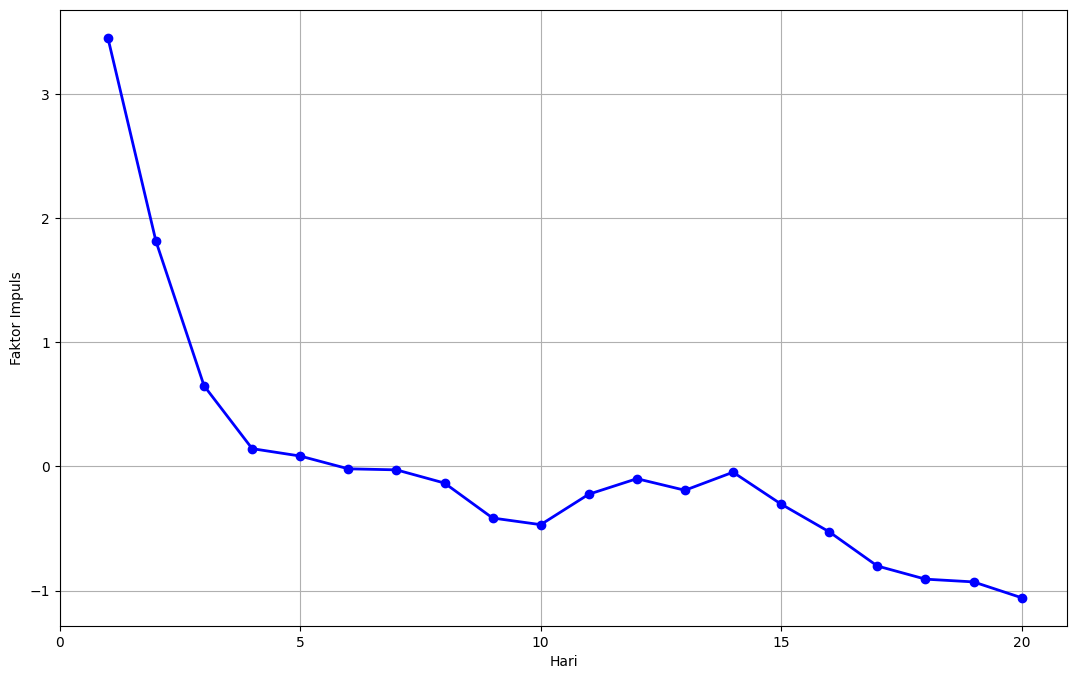

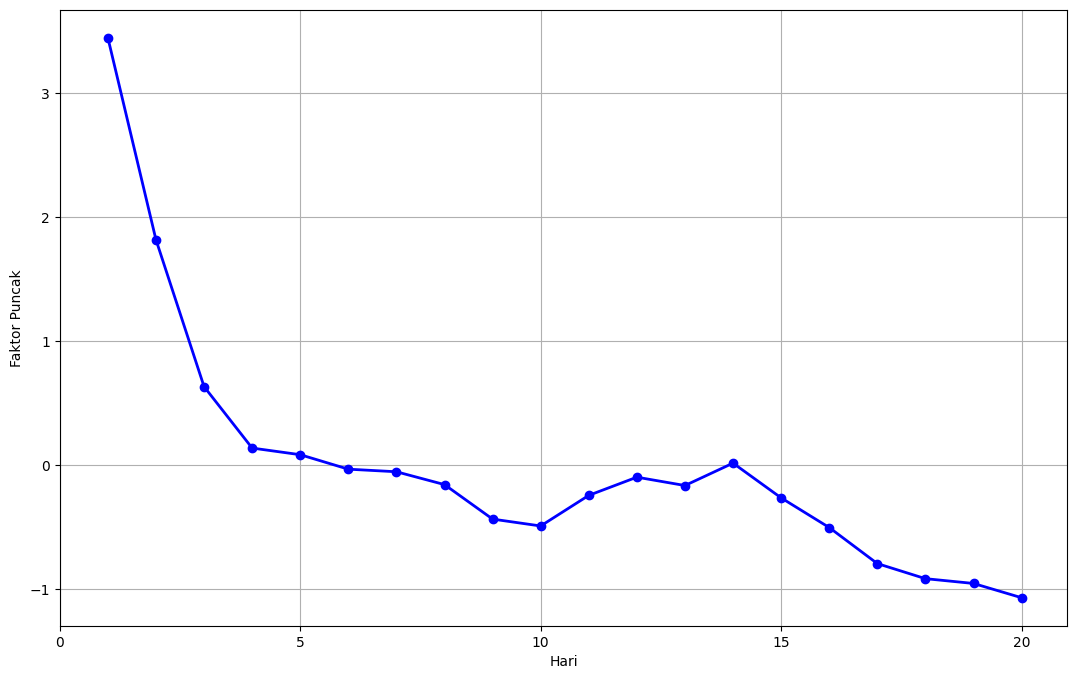

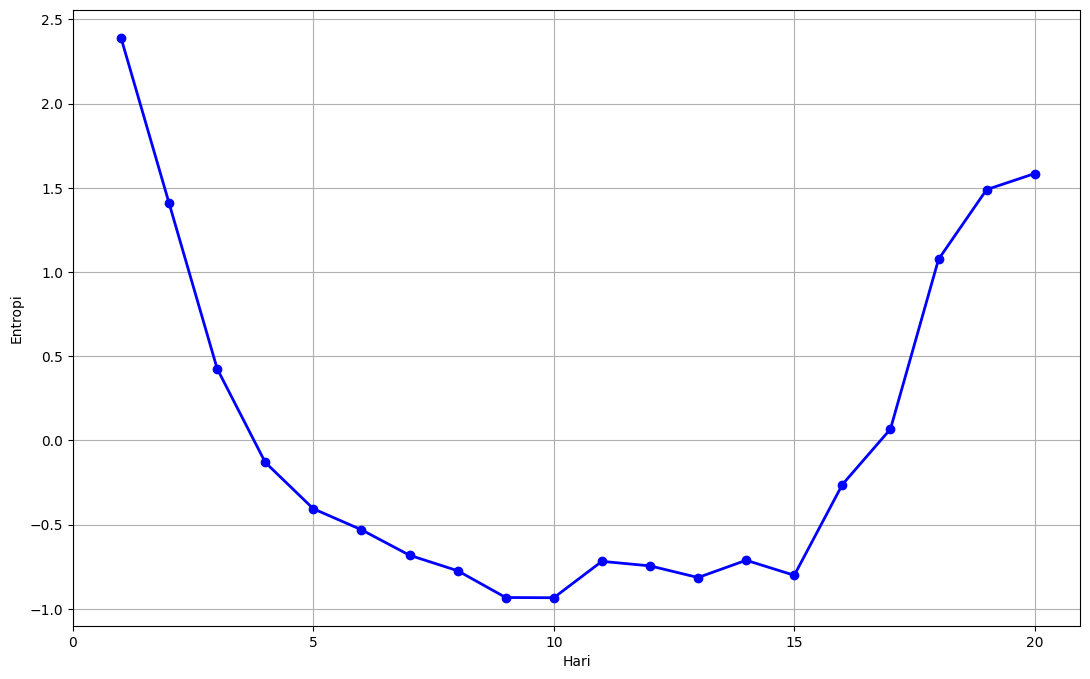

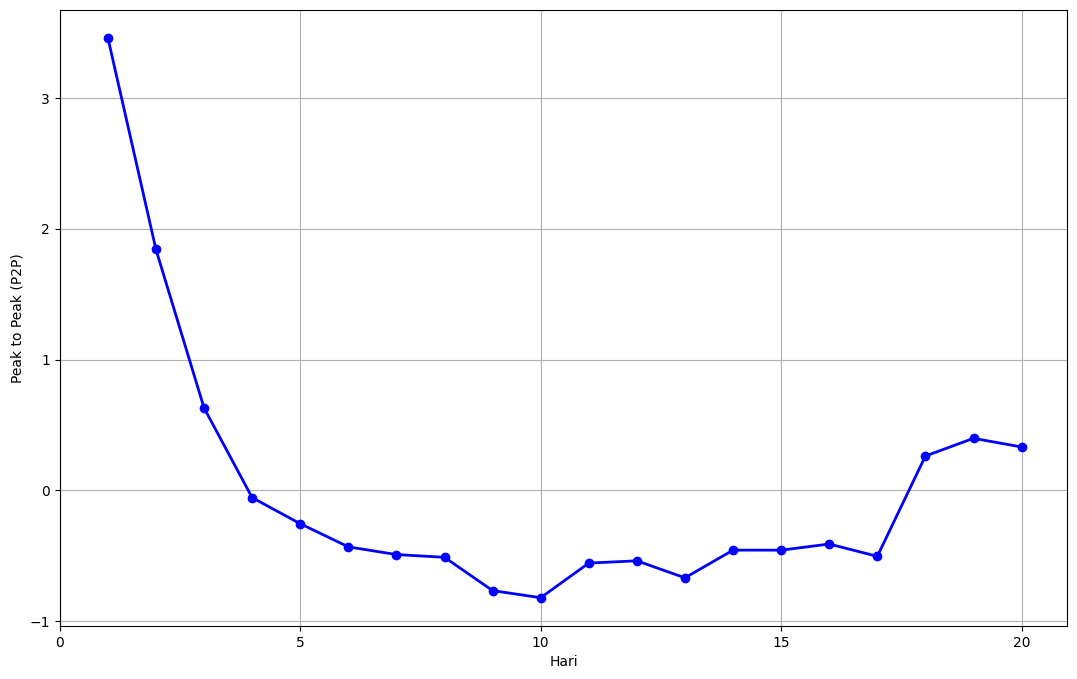

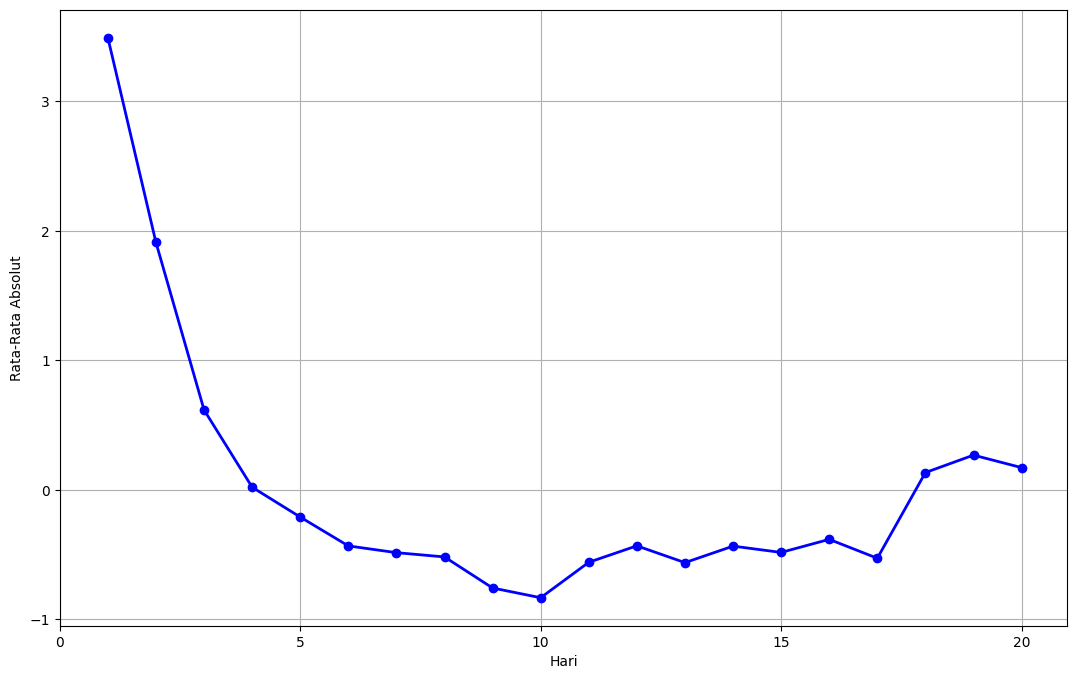

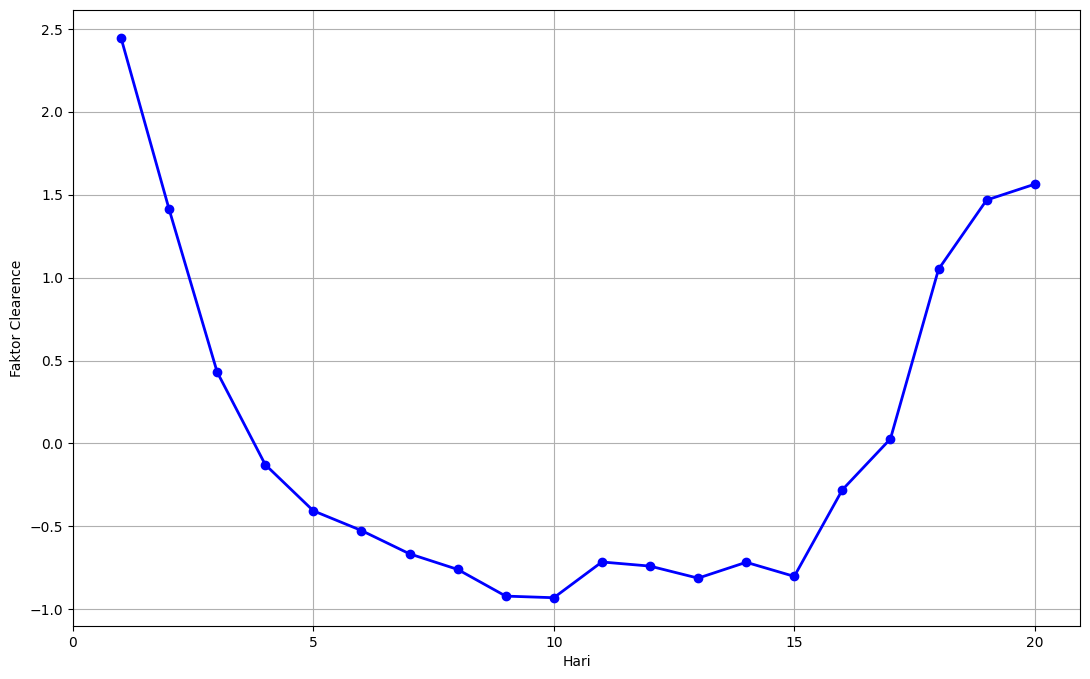

In [240]:
hi.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(hi.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(hi.index+1, hi[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,21,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

In [241]:
PCA_loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=hi.columns)
PCA_loadings

PCA1      PCA2
Faktor Impuls       0.384278 -0.499490
Faktor Puncak       0.383095 -0.503659
Entropi             0.382929  0.504141
Peak to Peak (P2P)  0.452276  0.029757
Rata-Rata Absolut   0.452487 -0.025576
Faktor Clearence    0.386828  0.491060

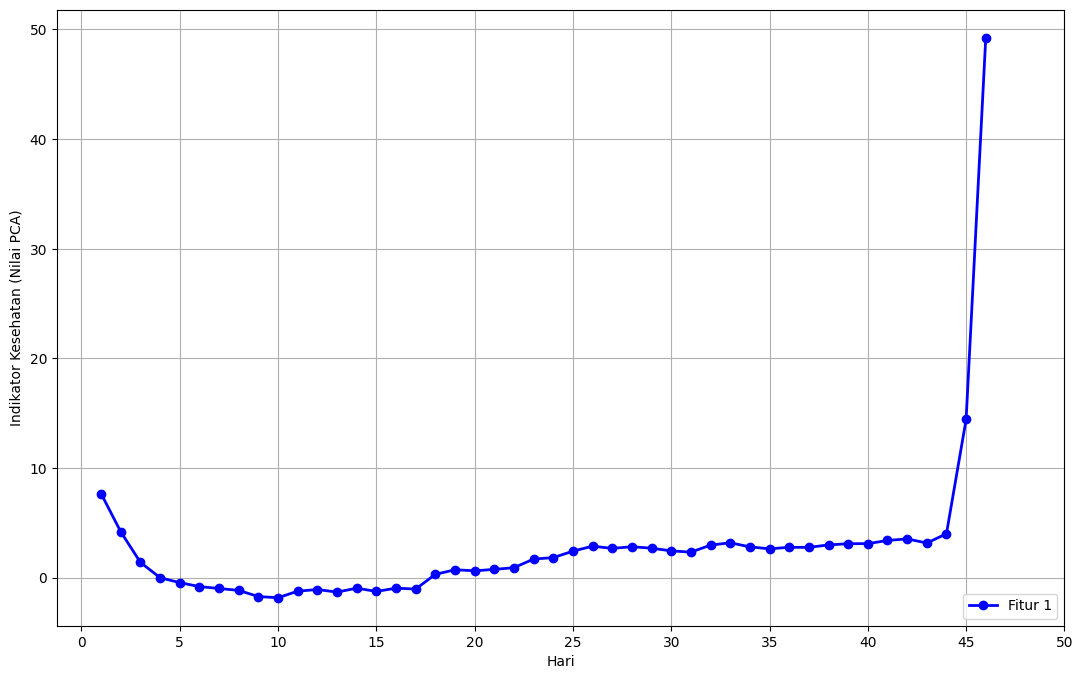

In [242]:
# Membuat fungsi PCA dengan 3 Principal Component 
# svd_solver = full ==> run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing
PCA_loadings = PCA_loadings.loc[:,['PCA1']]
smoothing_EMA15 = pd.DataFrame(scaler.transform(smoothing_EMA15)) # Fitting scaler pada X_train

# Fitting dan transform train data dengan PCA
smoothing_EMA15_PCA= np.dot(smoothing_EMA15, PCA_loadings)
smoothing_EMA15_PCA = pd.DataFrame(smoothing_EMA15_PCA, columns =['Fitur 1'])

# Variabel days_cycle dan RUL akan ditambahkan pada dataframe dari data smoothing yang dipilih
 # Memasukkan list days_cycle ke dalam dataframe Simple Exponential Smoothing
plt.figure(figsize=(13,8))
hi_plot = plt.plot(smoothing_EMA15_PCA.index+1, smoothing_EMA15_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
plt.xticks(np.arange(0,51,step=5))
plt.legend(['Fitur 1'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

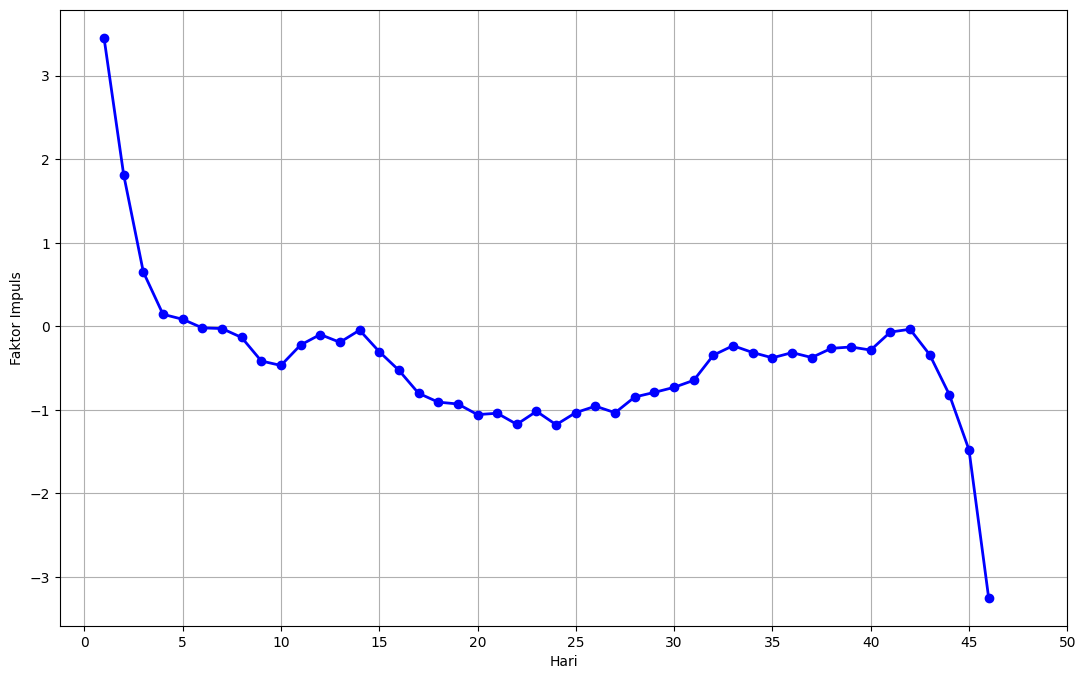

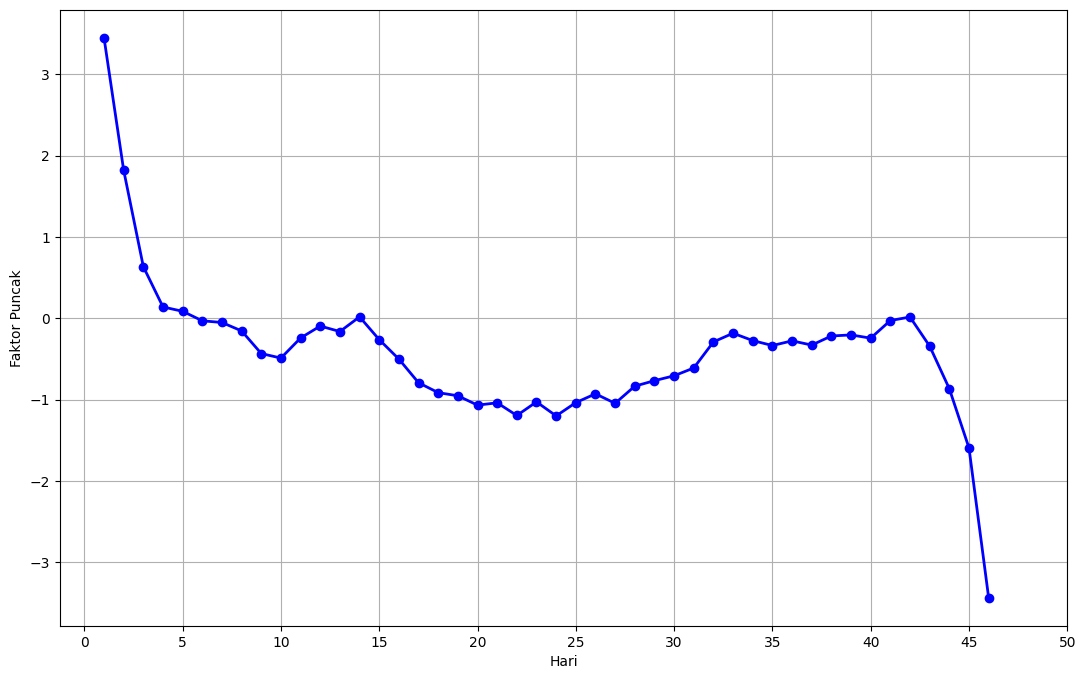

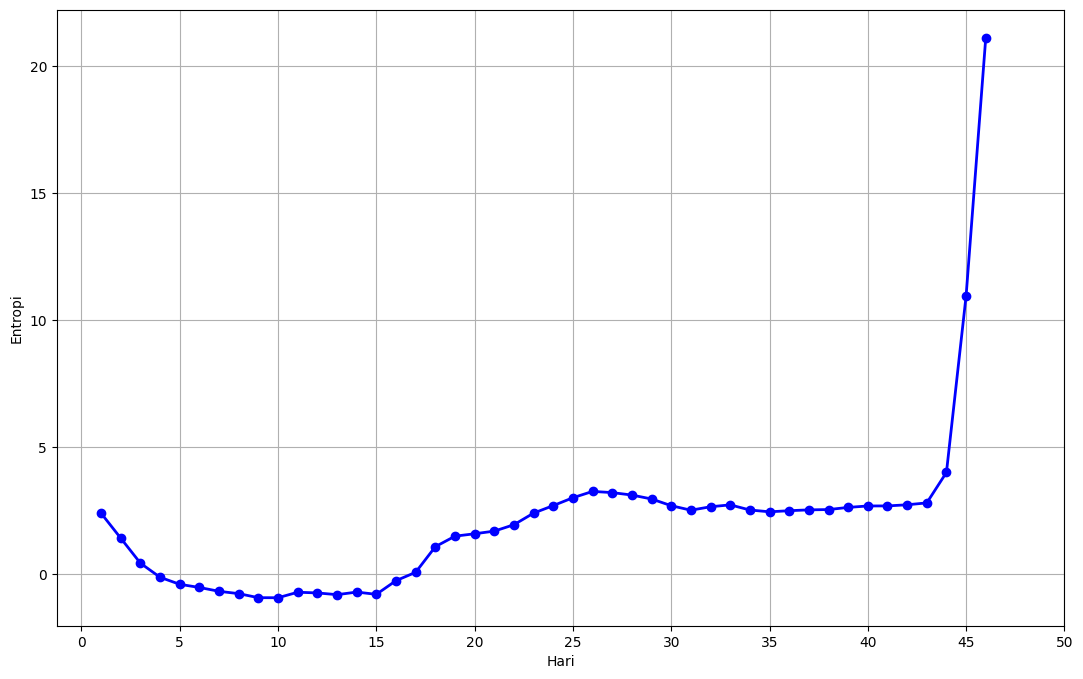

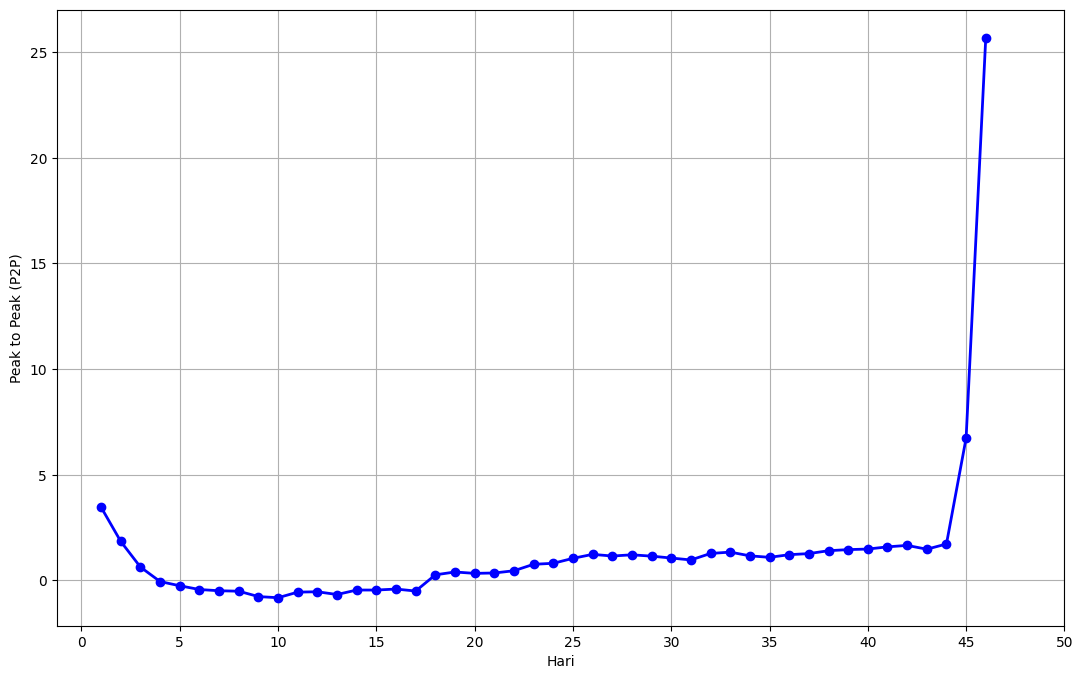

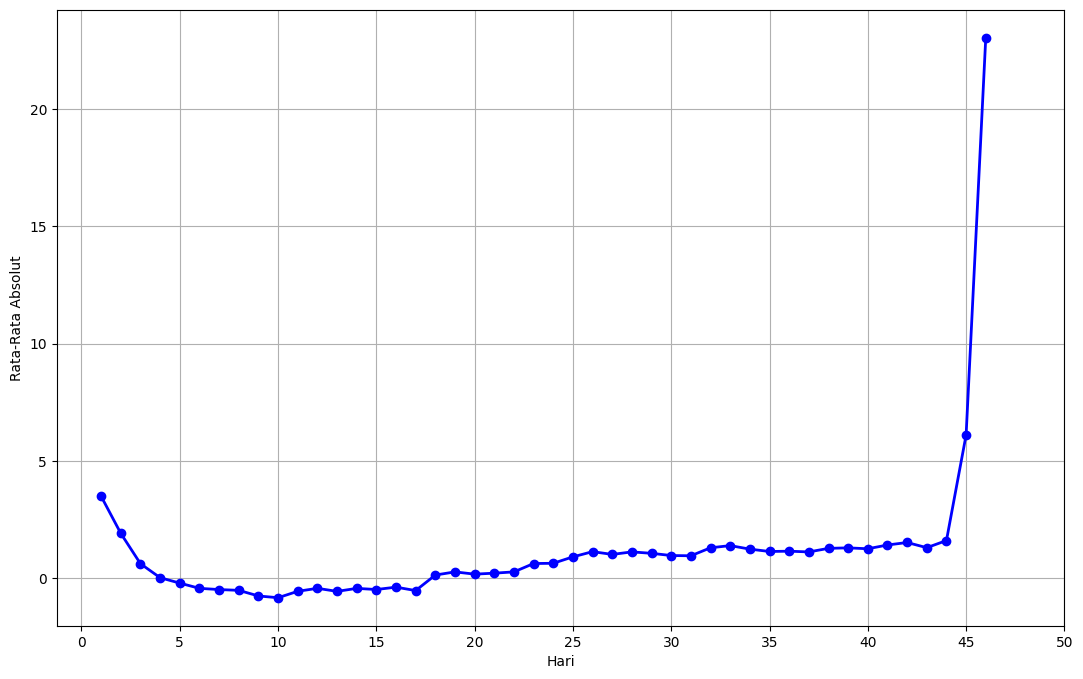

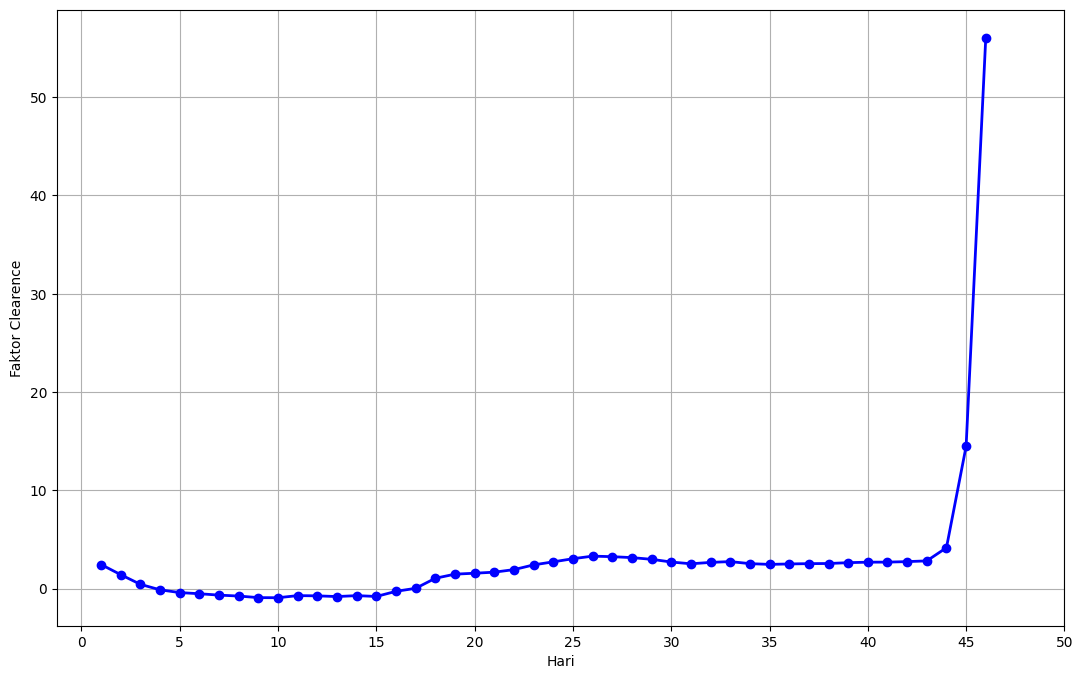

In [243]:
smoothing_EMA15.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(smoothing_EMA15.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(smoothing_EMA15.index+1, smoothing_EMA15[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,51,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

## Pembuatan Model SVR

### Model SVR Tanpa PCA

#### Perhitungan Nilai RUL

In [244]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 50 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_EMA15['RUL'] = np.asarray(RUL).flatten()

#### Pembagian Data Train dan Test

In [245]:
train_data = smoothing_EMA15.iloc[0:20] # Pembagian training data
test_data = smoothing_EMA15.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier 

In [246]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:3.280653084912484, R2:0.6763102356828332
test set RMSE:21.79693644040069, R2:-7.446336678877644


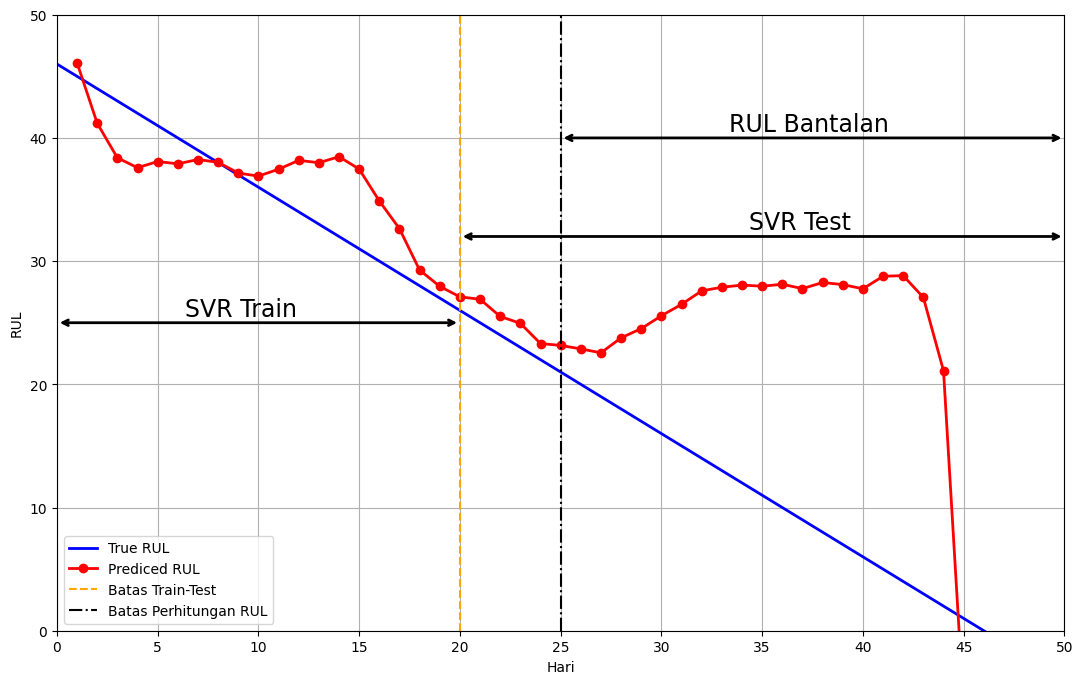

In [247]:
y_predEMA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_EMA15.index+1, y_predEMA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna 

In [248]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 19:01:57,571] A new study created in memory with name: no-name-d0987558-72ad-418c-ba70-f456b24d522e
[I 2023-04-10 19:01:57,582] Trial 0 finished with value: 21.413271312517253 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'auto', 'epsilon': 0.2}. Best is trial 0 with value: 21.413271312517253.
[I 2023-04-10 19:01:57,592] Trial 1 finished with value: 20.77300544111058 and parameters: {'kernel': 'poly', 'degree': 1, 'gamma': 'auto', 'epsilon': 0.34, 'coef0': 0.15000000000000002}. Best is trial 1 with value: 20.77300544111058.
[I 2023-04-10 19:01:57,602] Trial 2 finished with value: 23.725426309283595 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'epsilon': 0.34}. Best is trial 1 with value: 20.77300544111058.
[I 2023-04-10 19:01:57,610] Trial 3 finished with value: 68894.7805070626 and parameters: {'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'epsilon': 0.34, 'coef0': 0.3}. Best is trial 1 with value: 20.77300544111058.
[I 2023-04-10 19:01:

In [249]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 20.688784879729692
Best Parameters: {'kernel': 'linear', 'degree': 1, 'gamma': 'auto', 'epsilon': 0.4}


In [250]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear', degree=1, gamma='auto', epsilon=0.4) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:3.24406305712954, R2:0.6834903723719501
test set RMSE:20.688784879729692, R2:-6.609347907550791


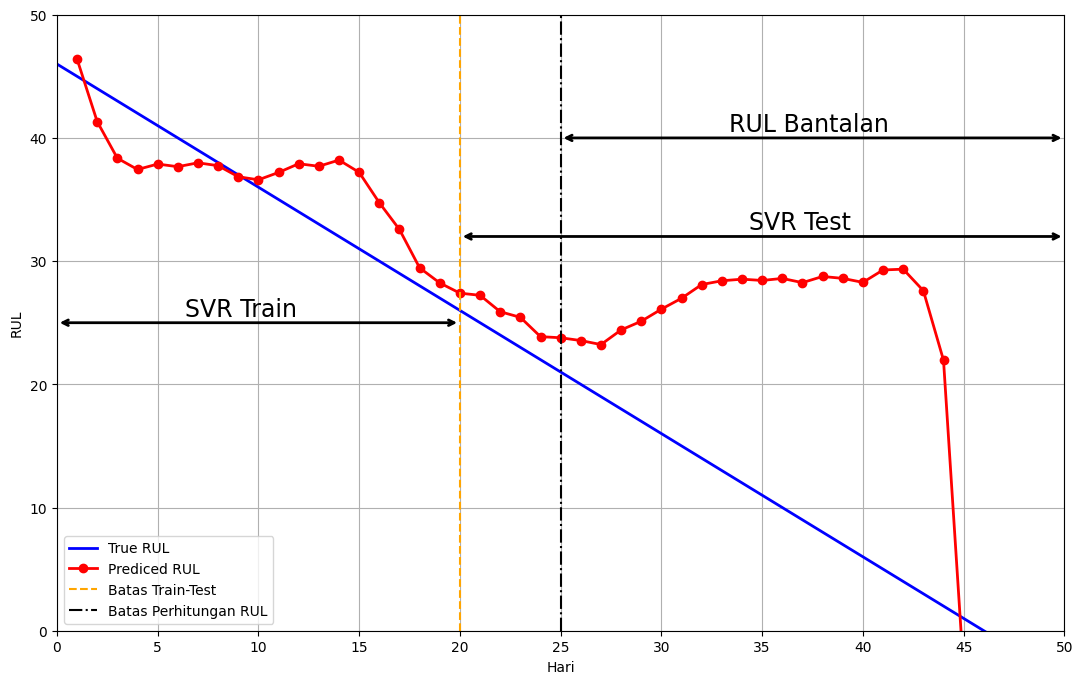

In [251]:
y_predEMAPCA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_EMA15_PCA.index+1, y_predEMAPCA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

### Model SVR Dengan PCA EMA15

#### Perhitungan Nilai RUL

In [252]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 46 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_EMA15_PCA['RUL'] = np.asarray(RUL).flatten()

#### Pembagian Data Train dan Test

In [253]:
train_data = smoothing_EMA15_PCA.iloc[0:20] # Pembagian training data
test_data = smoothing_EMA15_PCA.iloc[20:] # Pembagian test data

In [254]:
# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier EMA15

In [255]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:5.210793911573443, R2:0.18338727251456055
test set RMSE:33.26056371373252, R2:-18.666935085426857


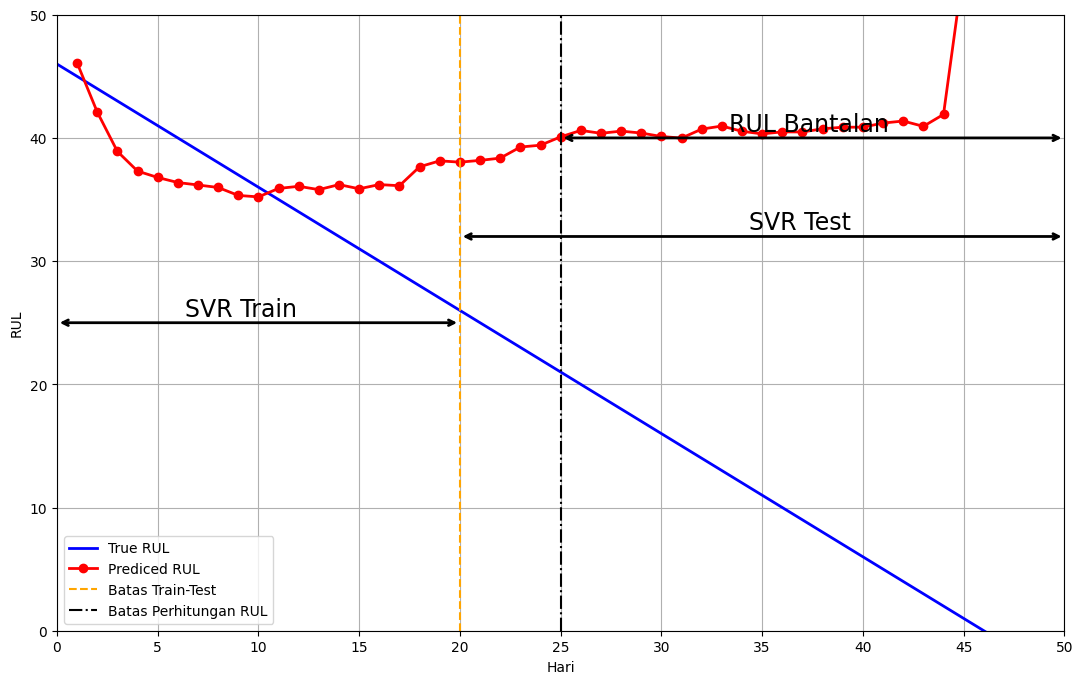

In [256]:
y_predEMAPCA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_EMA15_PCA.index+1, y_predEMAPCA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna EMA15

In [257]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return mean_squared_error(y_test, preds, squared=False) # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 1000 kali

[I 2023-04-10 19:03:28,538] A new study created in memory with name: no-name-a31eb568-fa4c-4110-a7af-0701a6a16866
[I 2023-04-10 19:03:28,557] Trial 0 finished with value: 26.083737436548986 and parameters: {'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'epsilon': 0.23}. Best is trial 0 with value: 26.083737436548986.
[I 2023-04-10 19:03:28,573] Trial 1 finished with value: 33.40569137316513 and parameters: {'kernel': 'linear', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.22}. Best is trial 0 with value: 26.083737436548986.
[I 2023-04-10 19:03:28,588] Trial 2 finished with value: 28.27256752395042 and parameters: {'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.11, 'coef0': 0.12}. Best is trial 0 with value: 26.083737436548986.
[I 2023-04-10 19:03:28,603] Trial 3 finished with value: 28.257227697754633 and parameters: {'kernel': 'sigmoid', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.37, 'coef0': 0.27}. Best is trial 0 with value: 26.083737436548986.
[I 2023-04-10 19:03

In [258]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 25.64118716765303
Best Parameters: {'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'epsilon': 0.01}


In [259]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear', degree=2, gamma='auto', epsilon= 0.01, coef0= 0) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:5.222147289470027, R2:0.17982489284453673
test set RMSE:33.15255837422553, R2:-18.539415586780997


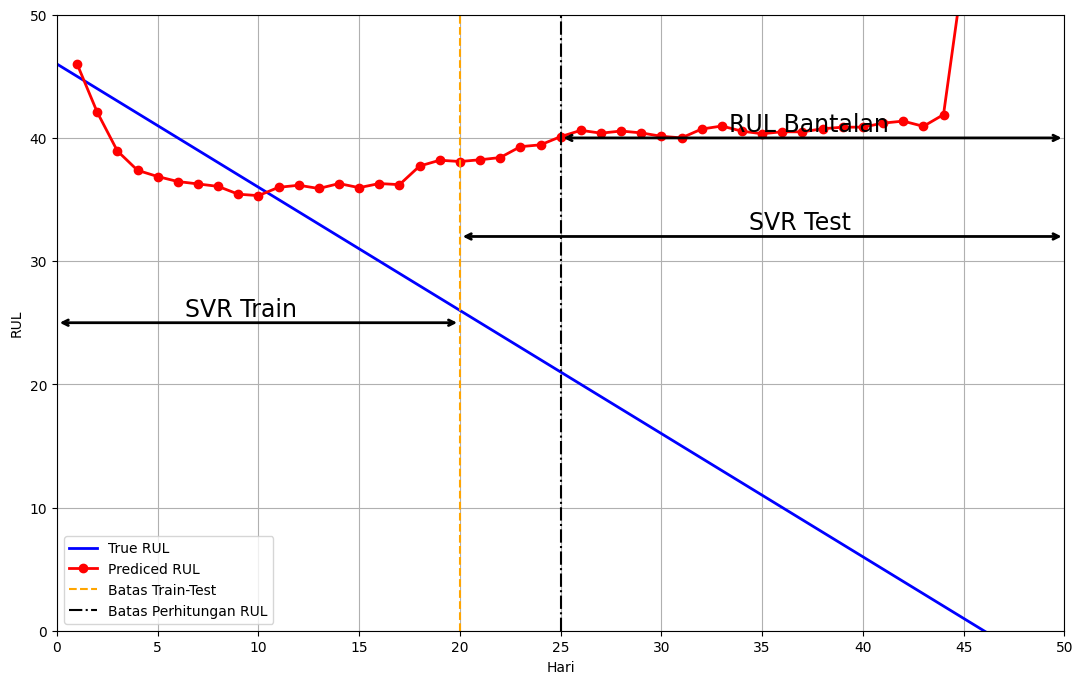

In [260]:
y_predEMAPCA_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_EMA15_PCA.index+1, y_predEMAPCA_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

# Holt's Method Smoothing

## Pembuatan Fitur PCA

In [261]:
hi = smoothing_DoubleExp.copy().iloc[:20]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler() # Pendefinisian scaler
hi = pd.DataFrame(scaler.fit_transform(hi)) # Fitting scaler pada X_train

from sklearn.decomposition import PCA
pca = PCA()

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
PCA_explained_variance_ratio= pd.DataFrame(pca.explained_variance_ratio_)
PCA_explained_variance_ratio.rename({0:'Fitur 1', 1:'Fitur 2', 2:'Fitur 3', 3:'Fitur 4', 
                                     4:'Fitur 5', 5:'Fitur 6'}, axis=0, inplace=True)
PCA_explained_variance_ratio.rename({0:'Variance Ratio'}, axis=1, inplace=True)
PCA_explained_variance_ratio

Variance Ratio
Fitur 1        0.875127
Fitur 2        0.114900
Fitur 3        0.009493
Fitur 4        0.000313
Fitur 5        0.000144
Fitur 6        0.000023

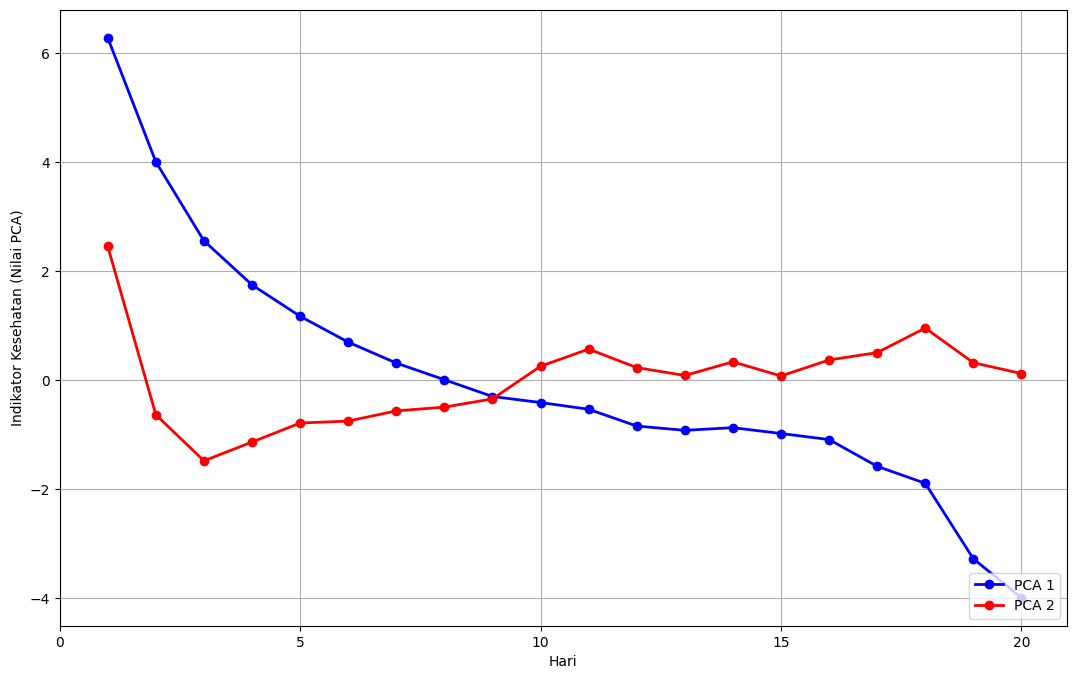

In [262]:
pca = PCA(n_components=2)

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
hi_PCA= pd.DataFrame(hi_PCA, columns=['Fitur 1', 'Fitur 2'])
plt.figure(figsize=(13,8))
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 2'], linestyle='-', marker='o', color='red', linewidth=2)
plt.xticks(np.arange(0,21,step=5))
plt.legend(['PCA 1', 'PCA 2'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

In [263]:
scaler_parameter = pd.DataFrame([scaler.scale_, scaler.mean_, scaler.var_]).T
scaler_parameter.rename(columns={0:'Scale', 1:'Mean', 2:'Variances'}, index={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
scaler_parameter

Scale      Mean  Variances
Faktor Impuls       0.117546  5.949479   0.013817
Faktor Puncak       0.085806  4.708739   0.007363
Entropi             0.016277  4.464262   0.000265
Peak to Peak (P2P)  0.008925  0.469065   0.000080
Rata-Rata Absolut   0.004360  0.245369   0.000019
Faktor Clearence    0.001931  0.052168   0.000004

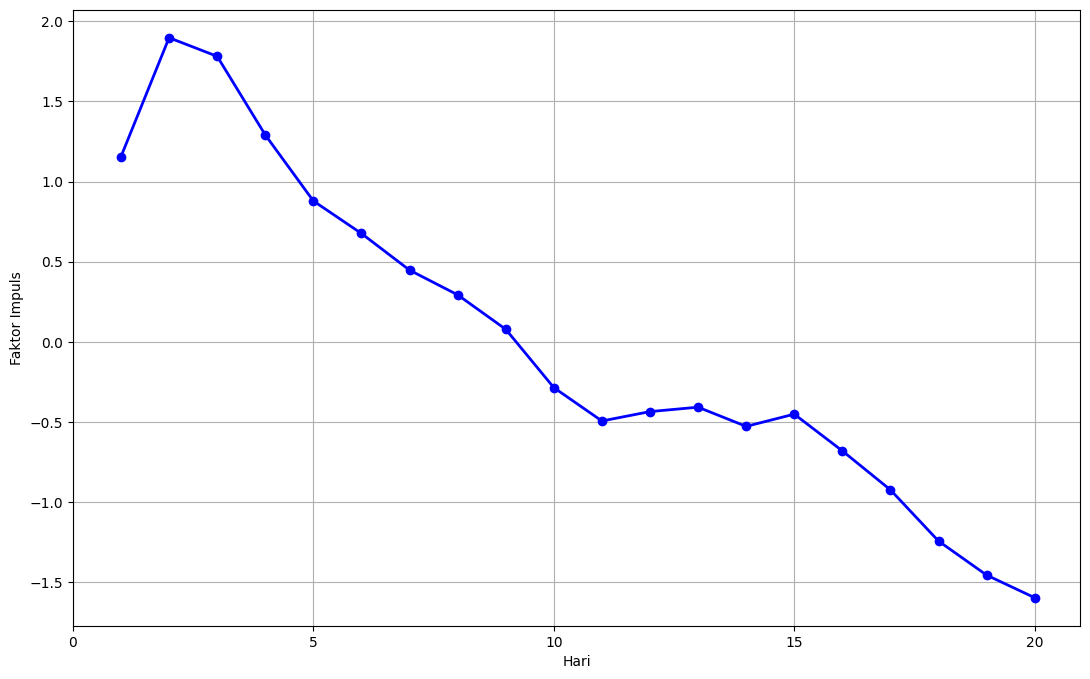

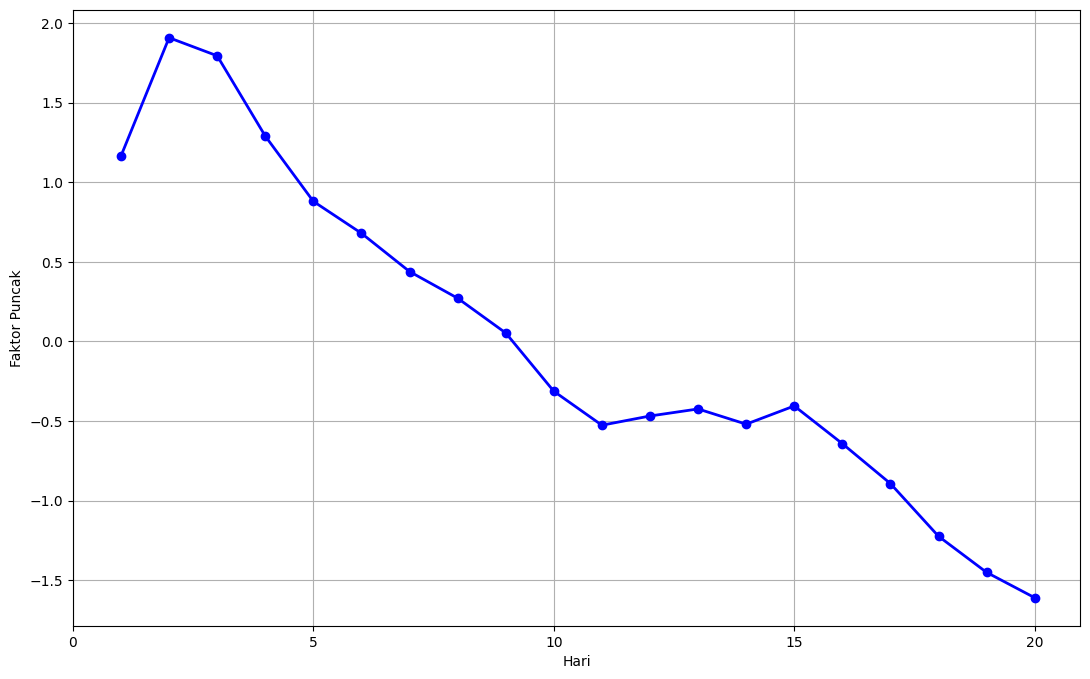

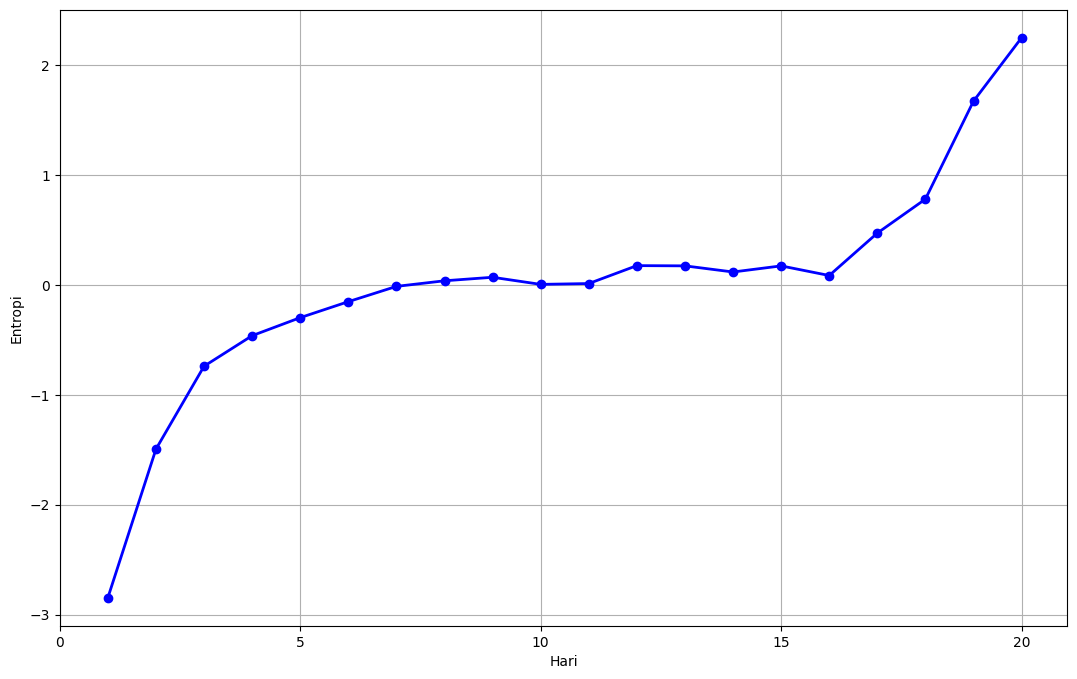

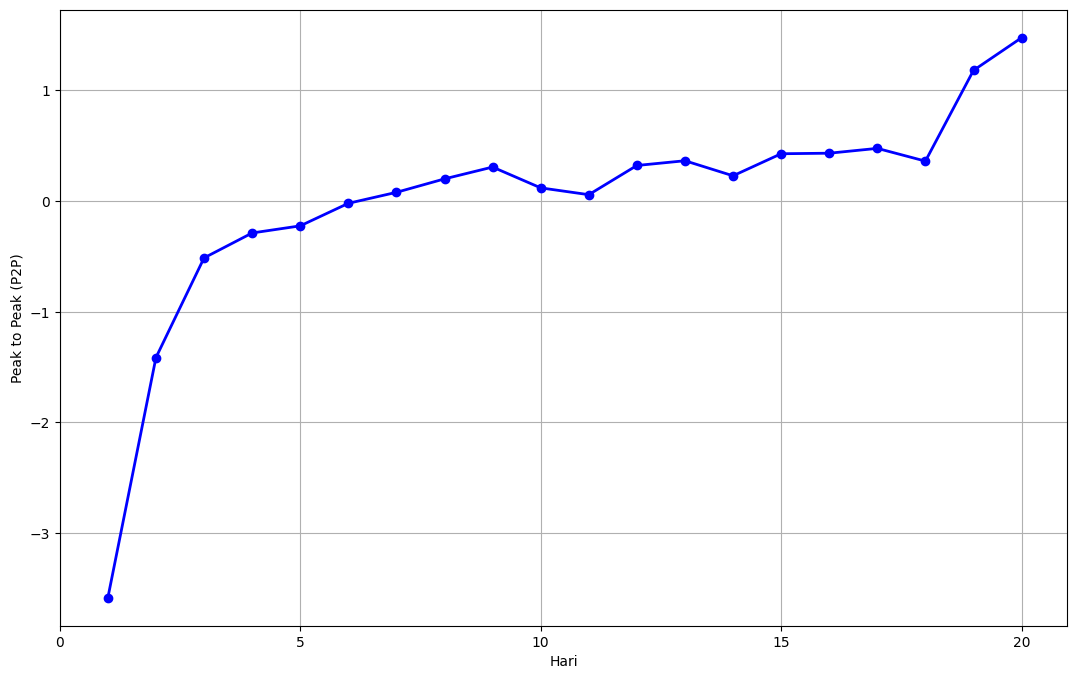

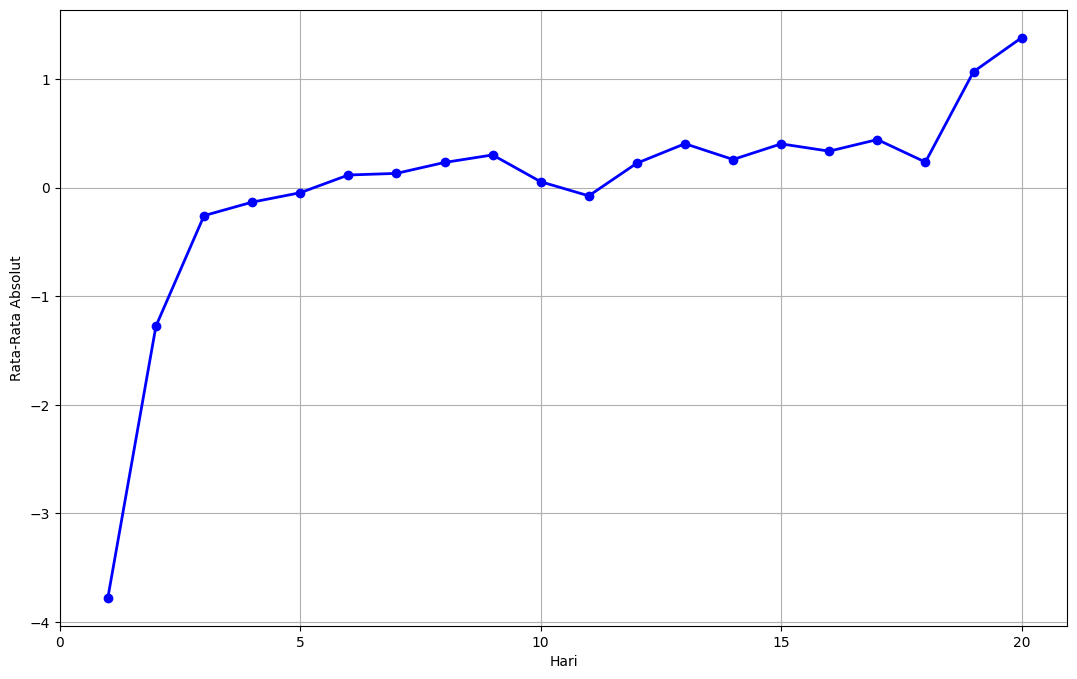

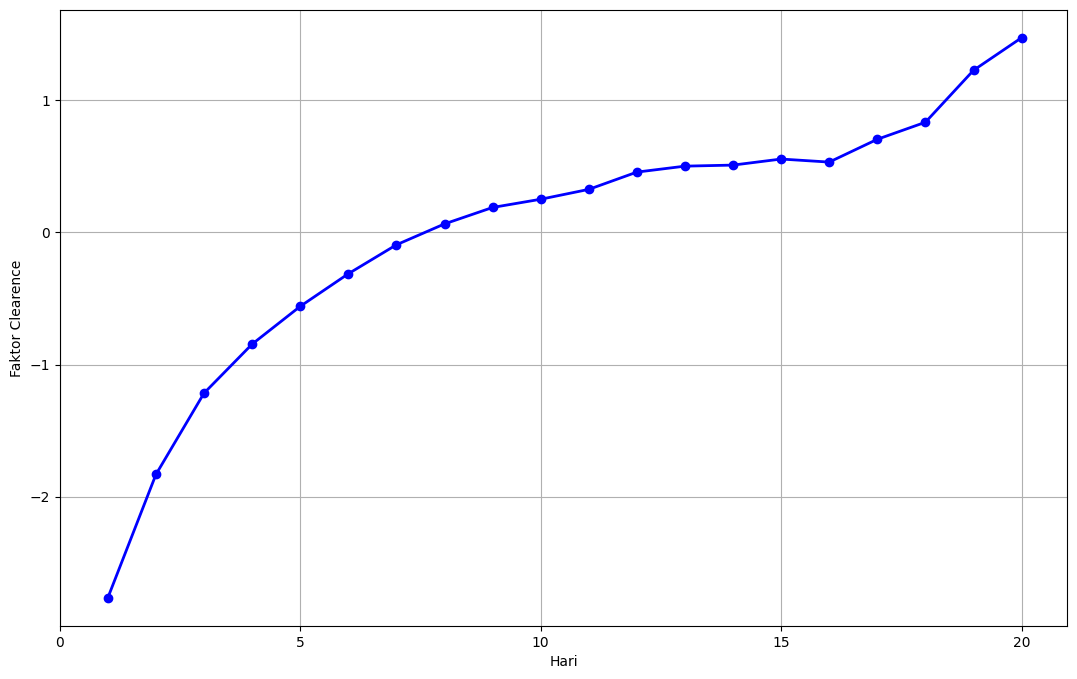

In [264]:
hi.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(hi.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(hi.index+1, hi[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,21,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

In [265]:
PCA_loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=hi.columns)
PCA_loadings

PCA1      PCA2
Faktor Impuls       0.391014 -0.534254
Faktor Puncak       0.391601 -0.531325
Entropi            -0.423132 -0.157361
Peak to Peak (P2P) -0.412928 -0.384335
Rata-Rata Absolut  -0.394758 -0.509241
Faktor Clearence   -0.434020  0.021535

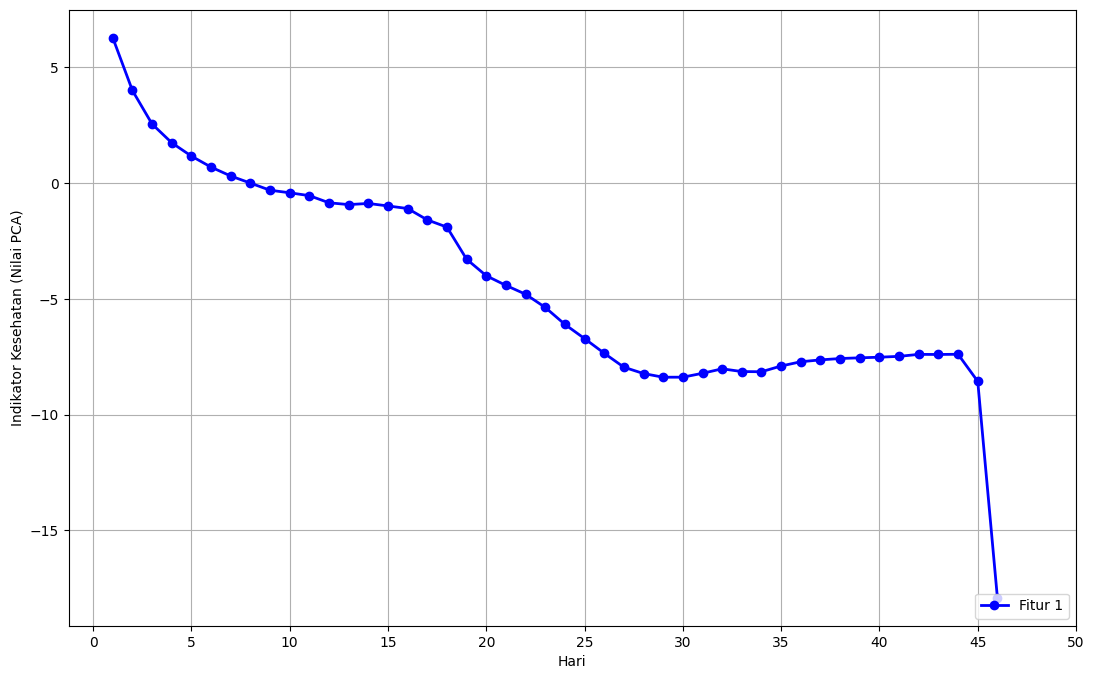

In [266]:
# Membuat fungsi PCA dengan 3 Principal Component 
# svd_solver = full ==> run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing
PCA_loadings = PCA_loadings.loc[:,['PCA1']]
smoothing_DoubleExp = pd.DataFrame(scaler.transform(smoothing_DoubleExp)) # Fitting scaler pada X_train

# Fitting dan transform train data dengan PCA
smoothing_DoubleExp_PCA= np.dot(smoothing_DoubleExp, PCA_loadings)
smoothing_DoubleExp_PCA = pd.DataFrame(smoothing_DoubleExp_PCA, columns =['Fitur 1'])

# Variabel days_cycle dan RUL akan ditambahkan pada dataframe dari data smoothing yang dipilih
plt.figure(figsize=(13,8))
hi_plot = plt.plot(smoothing_DoubleExp_PCA.index+1, smoothing_DoubleExp_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
plt.xticks(np.arange(0,51,step=5))
plt.legend(['Fitur 1'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

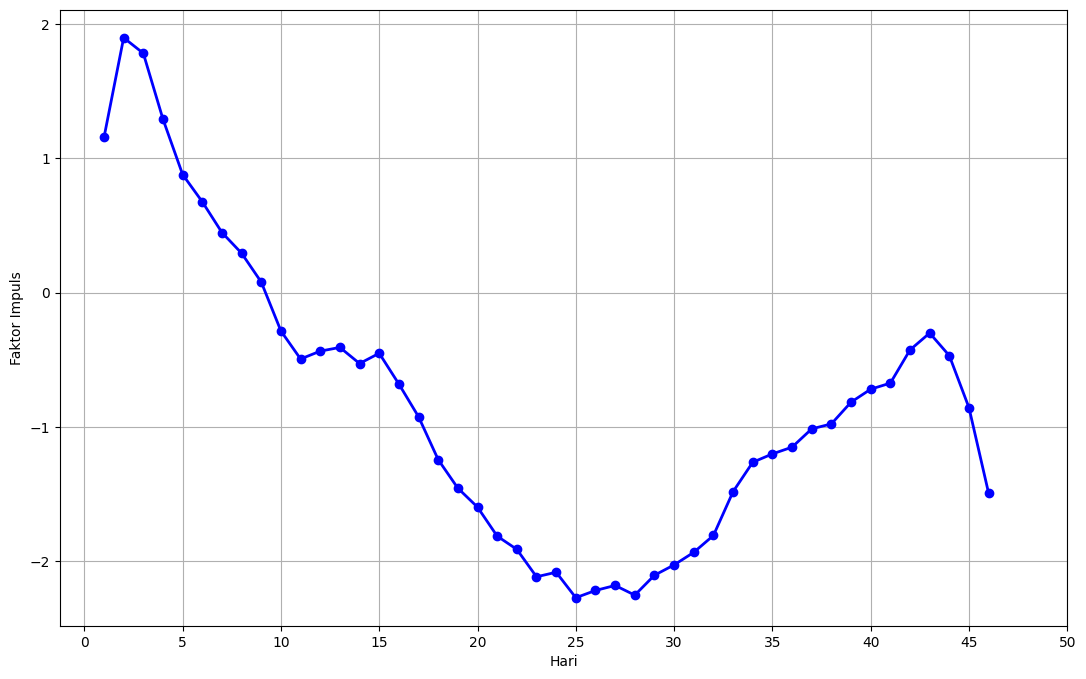

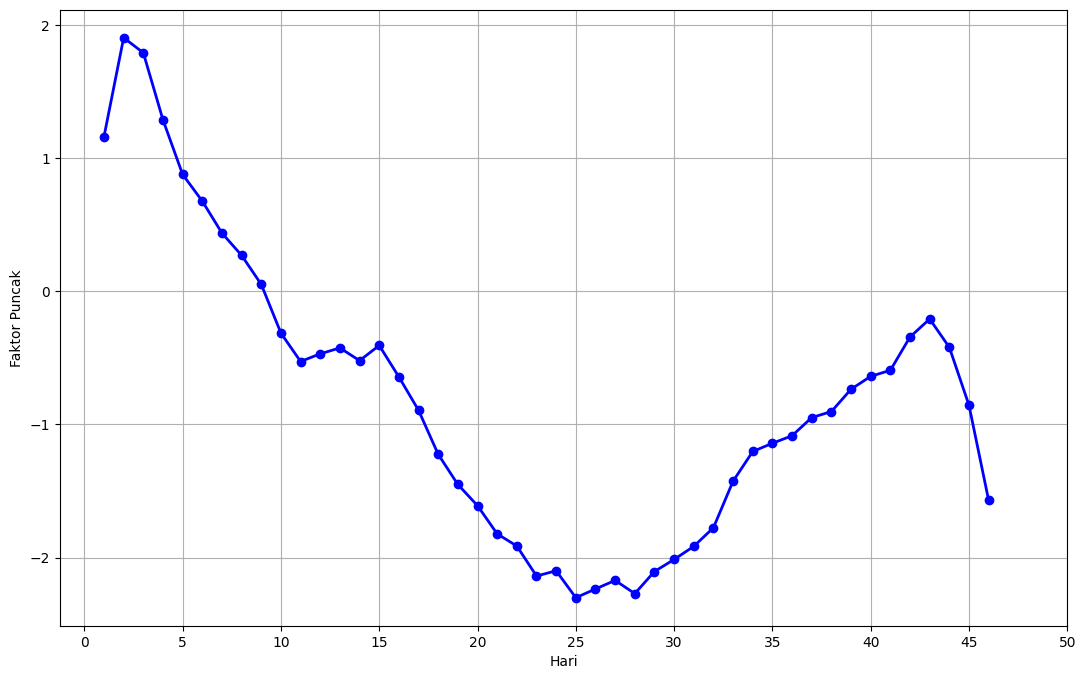

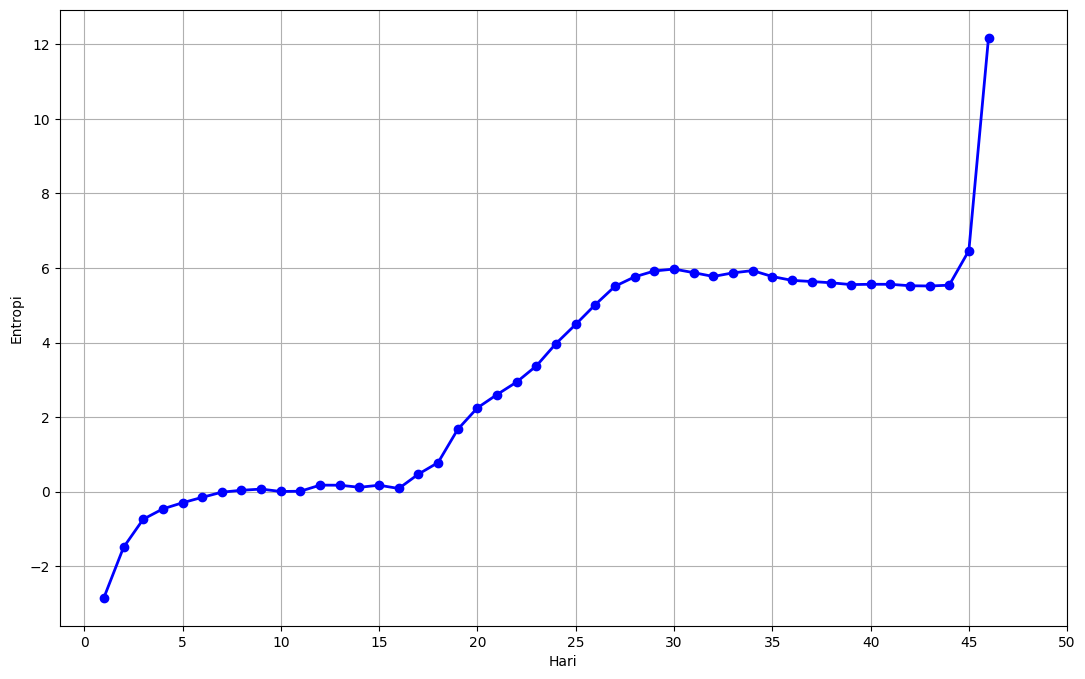

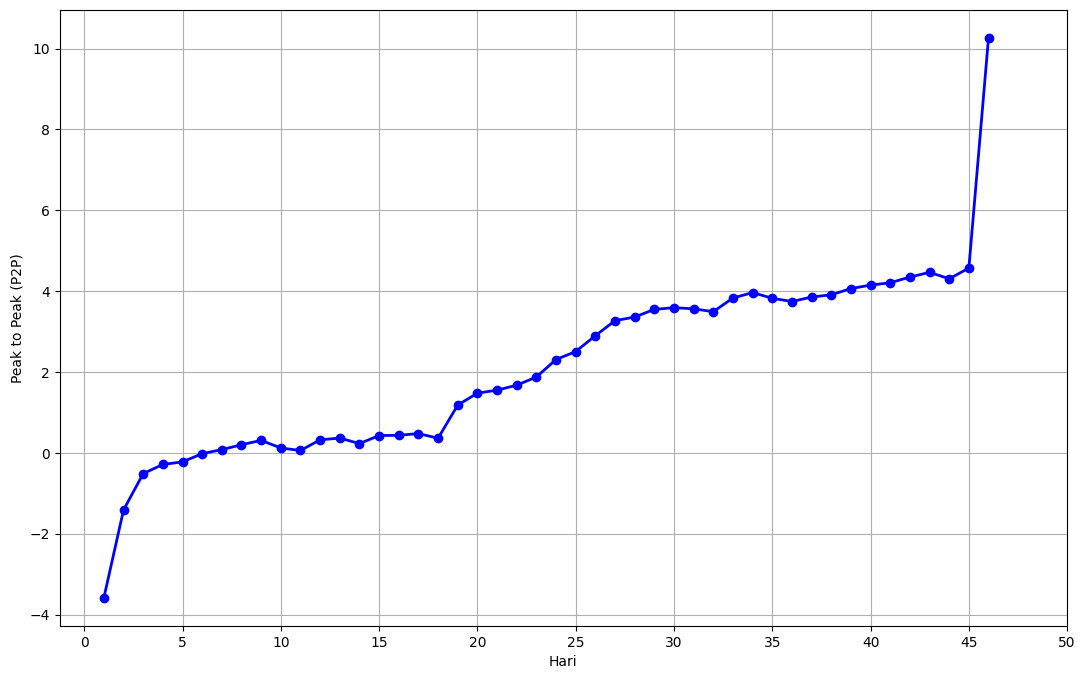

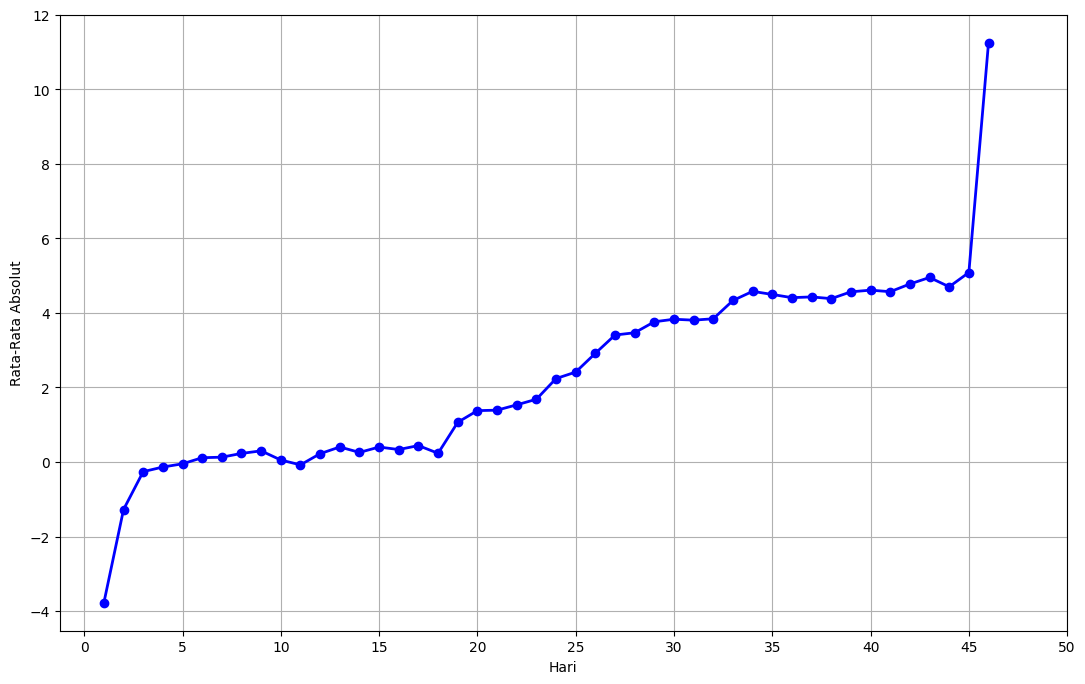

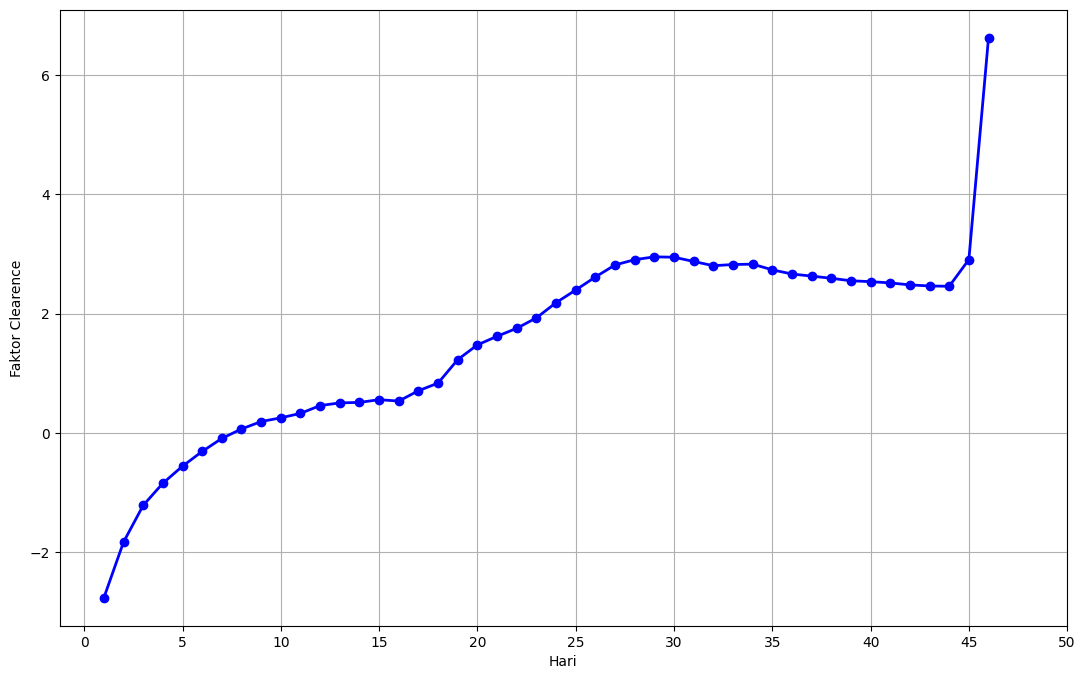

In [267]:
smoothing_DoubleExp.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(smoothing_DoubleExp.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(smoothing_DoubleExp.index+1, smoothing_DoubleExp[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,51,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

## Pembuatan Model SVR

### Model SVR Tanpa PCA

#### Perhitungan Nilai RUL

In [268]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 46 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_DoubleExp['RUL'] = np.asarray(RUL).flatten()

#### Pembagian Data Train dan Test

In [269]:
train_data = smoothing_DoubleExp.iloc[0:20] # Pembagian training data
test_data = smoothing_DoubleExp.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier

In [270]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:1.3871946676394247, R2:0.9421260437315112
test set RMSE:14.374851773877962, R2:-2.6735353514837756


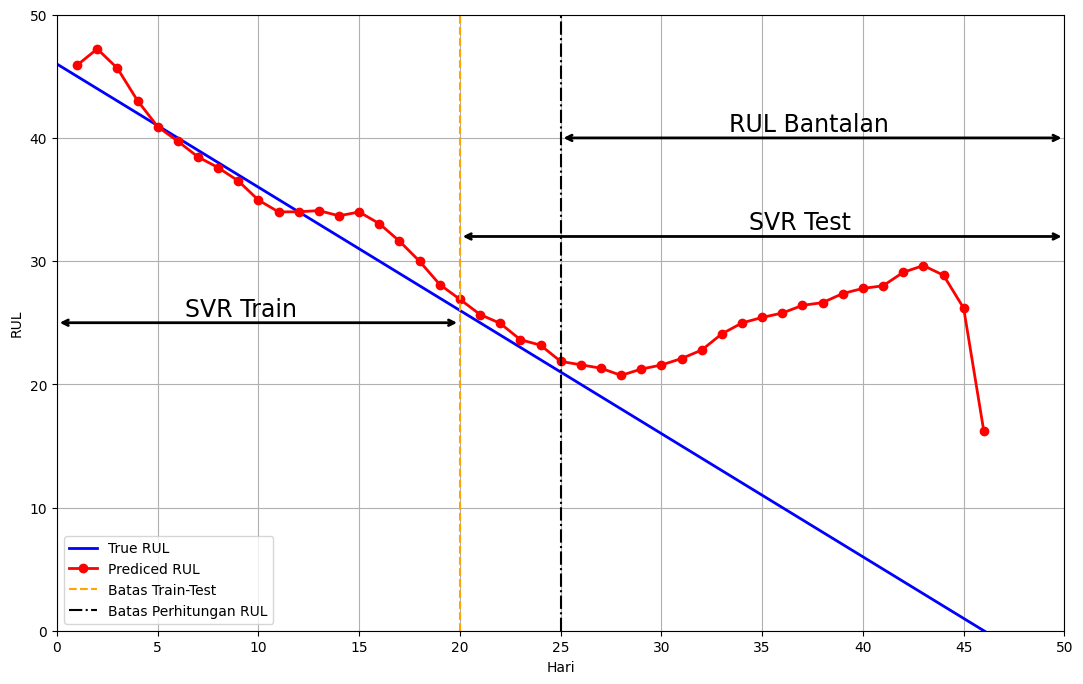

In [271]:
y_predDE_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_DoubleExp.index+1, y_predDE_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna

In [272]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 19:05:05,317] A new study created in memory with name: no-name-24e44ee9-7665-4998-be82-7a1cbb92074f
[I 2023-04-10 19:05:05,328] Trial 0 finished with value: 14.660580635896462 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.34}. Best is trial 0 with value: 14.660580635896462.
[I 2023-04-10 19:05:05,337] Trial 1 finished with value: 14.7059661757602 and parameters: {'kernel': 'linear', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.36000000000000004}. Best is trial 0 with value: 14.660580635896462.
[I 2023-04-10 19:05:05,343] Trial 2 finished with value: 553.0106971652993 and parameters: {'kernel': 'poly', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.09, 'coef0': 0.35000000000000003}. Best is trial 0 with value: 14.660580635896462.
[I 2023-04-10 19:05:05,353] Trial 3 finished with value: 25.705335587796146 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.32}. Best is trial 0 with value: 14.660580635896462.
[I 2023-0

In [273]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 9.23213698481006
Best Parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'epsilon': 0.01, 'coef0': 0.22}


In [274]:
# Pembuatan model dengan SVR
svr = SVR(kernel='poly', degree=2, gamma='scale', epsilon=0.01, coef0=0.22) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:2.0903338855655287, R2:0.8685865938904216
test set RMSE:9.23213698481005, R2:-0.5152418365564013


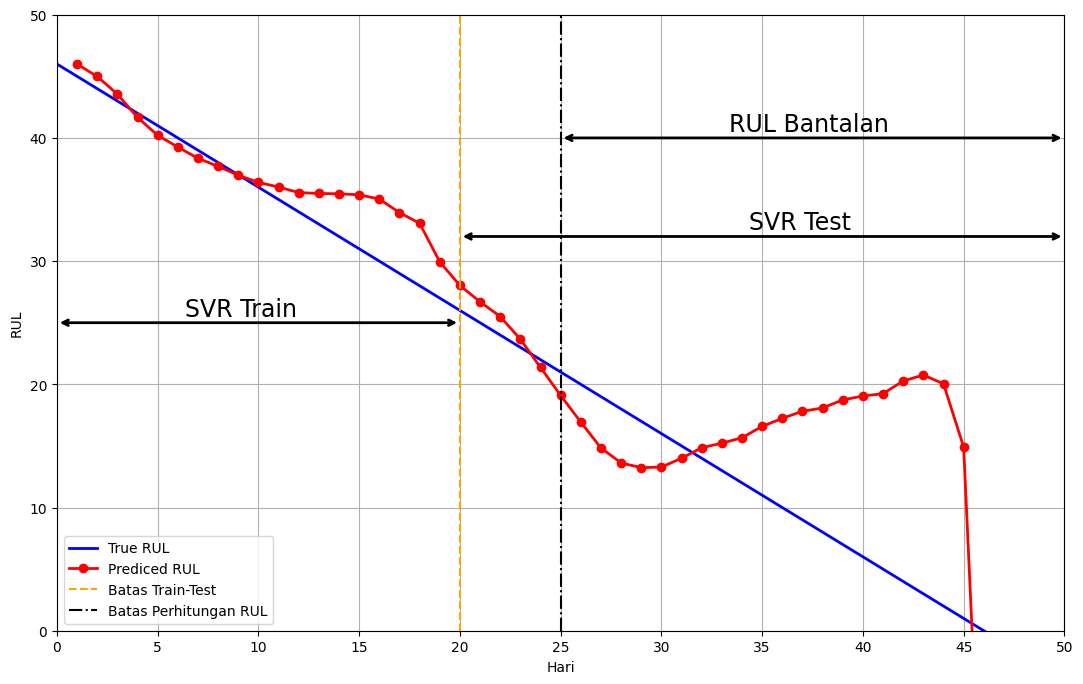

In [275]:
y_predDE_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_DoubleExp.index+1, y_predDE_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

### Model SVR Dengan PCA Holt's Method

#### Perhitungan Nilai RUL

In [276]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 46 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_DoubleExp_PCA['RUL'] = np.asarray(RUL).flatten() # Memasukkan list days_cycle ke dalam dataframe Simple Exponential Smoothing

#### Pembagian Data untuk Train dan Test

In [277]:
train_data = smoothing_DoubleExp_PCA.iloc[0:20] # Pembagian training data
test_data = smoothing_DoubleExp_PCA.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier Holt's Method

In [278]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:2.5273992712187496, R2:0.8078873059802386
test set RMSE:7.534959590226424, R2:-0.009344284912802703


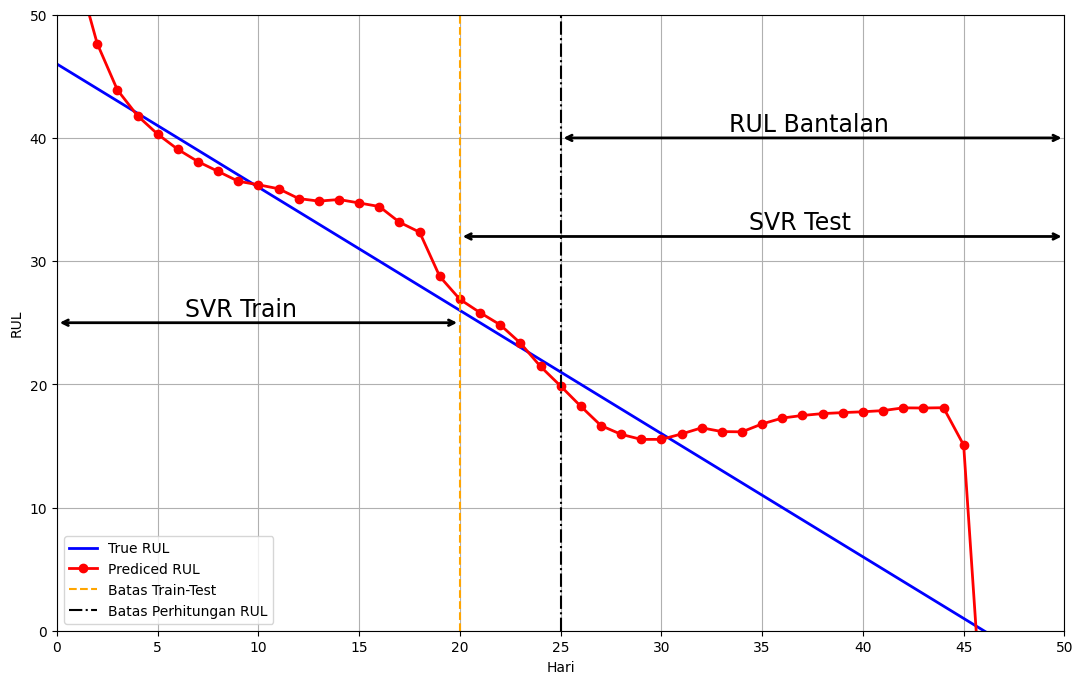

In [279]:
y_predDEPCA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_DoubleExp_PCA.index+1, y_predDEPCA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna Holt's Method

In [280]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return mean_squared_error(y_test, preds, squared=False) # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 1000 kali

[I 2023-04-10 19:06:13,581] A new study created in memory with name: no-name-36435baf-b839-41a2-be75-1cdf63fb3f54
[I 2023-04-10 19:06:13,596] Trial 0 finished with value: 13.545354539780632 and parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.22, 'coef0': 0.14}. Best is trial 0 with value: 13.545354539780632.
[I 2023-04-10 19:06:13,616] Trial 1 finished with value: 7.432394395271721 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.32}. Best is trial 1 with value: 7.432394395271721.
[I 2023-04-10 19:06:13,625] Trial 2 finished with value: 16.58296733805157 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.25, 'coef0': 0.06999999999999999}. Best is trial 1 with value: 7.432394395271721.
[I 2023-04-10 19:06:13,634] Trial 3 finished with value: 16.89272108847442 and parameters: {'kernel': 'sigmoid', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.19, 'coef0': 0.2}. Best is trial 1 with value: 7.4323943952

In [281]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 6.465543294193435
Best Parameters: {'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'epsilon': 0.34, 'coef0': 0.24000000000000002}


In [282]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear', degree=1, gamma='scale', epsilon=0.4, coef0=0) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:2.4521796370747664, R2:0.8191523316546125
test set RMSE:7.396367859266274, R2:0.027444310940672567


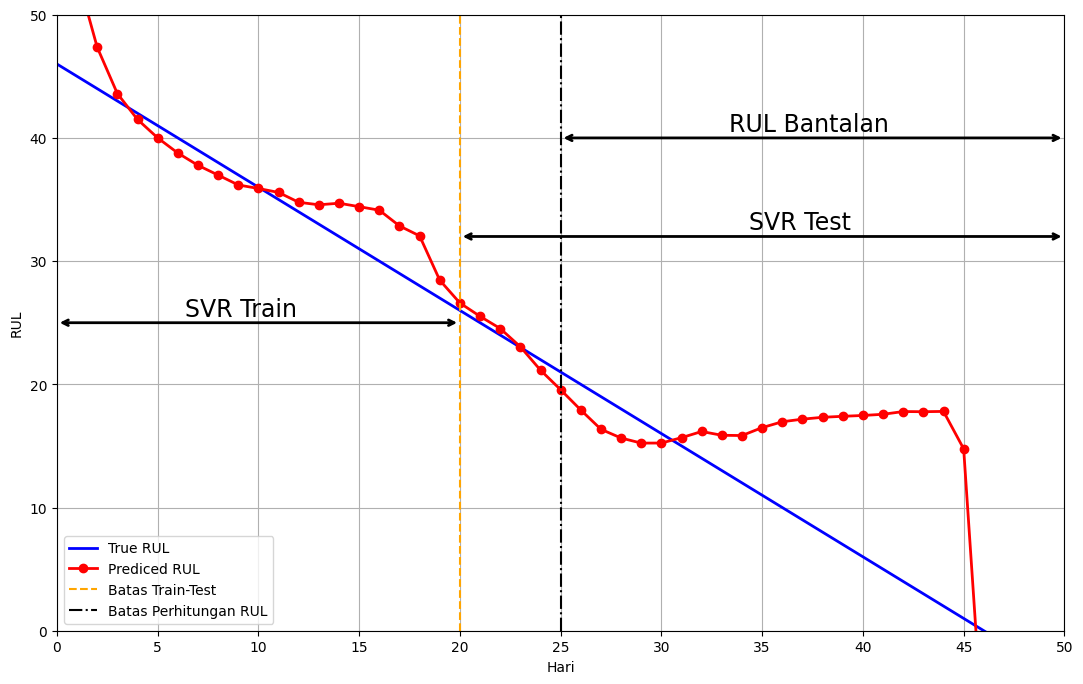

In [283]:
y_predDEPCA_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_DoubleExp_PCA.index+1, y_predDEPCA_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

# Savitzky-Golay filter

## Pembuatan Fitur PCA

In [284]:
hi = smoothing_savgolfilter.copy().iloc[:20]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler() # Pendefinisian scaler
hi = pd.DataFrame(scaler.fit_transform(hi)) # Fitting scaler pada X_train

from sklearn.decomposition import PCA
pca = PCA()

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
PCA_explained_variance_ratio= pd.DataFrame(pca.explained_variance_ratio_)
PCA_explained_variance_ratio.rename({0:'Fitur 1', 1:'Fitur 2', 2:'Fitur 3', 3:'Fitur 4', 
                                     4:'Fitur 5', 5:'Fitur 6'}, axis=0, inplace=True)
PCA_explained_variance_ratio.rename({0:'Variance Ratio'}, axis=1, inplace=True)
PCA_explained_variance_ratio

Variance Ratio
Fitur 1        0.630083
Fitur 2        0.369189
Fitur 3        0.000613
Fitur 4        0.000097
Fitur 5        0.000016
Fitur 6        0.000001

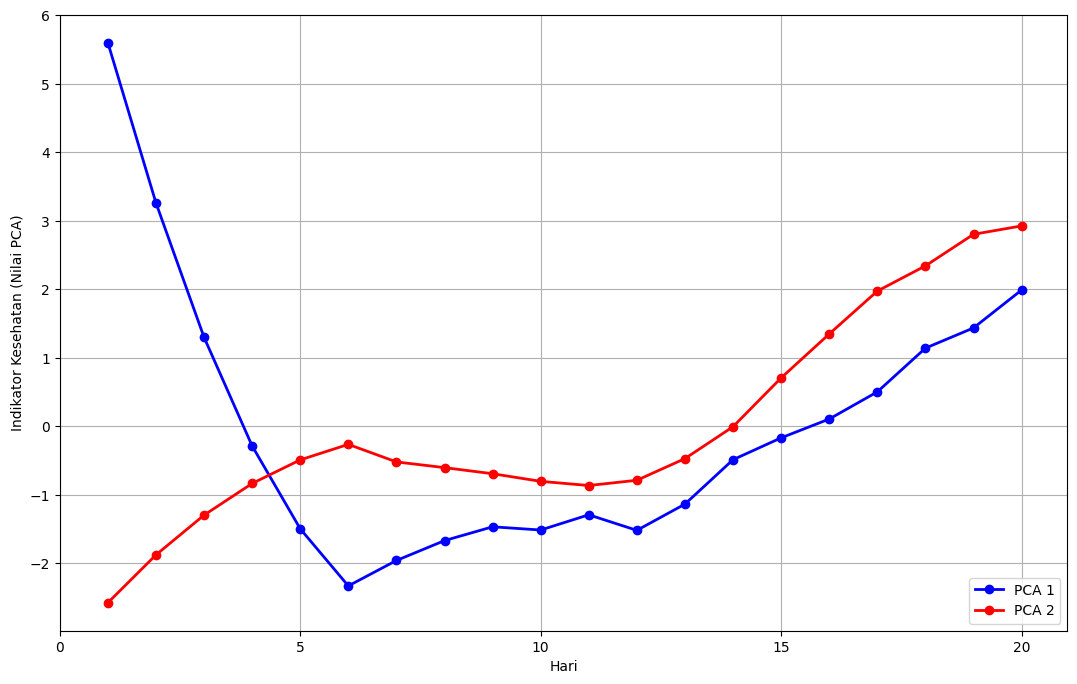

In [285]:
pca = PCA(n_components=2)

# Fitting dan transform train data dengan PCA
hi_PCA= pca.fit_transform(hi)
hi_PCA= pd.DataFrame(hi_PCA, columns=['Fitur 1', 'Fitur 2'])
plt.figure(figsize=(13,8))
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
hi_plot = plt.plot(hi_PCA.index+1, hi_PCA['Fitur 2'], linestyle='-', marker='o', color='red', linewidth=2)
plt.xticks(np.arange(0,21,step=5))
plt.legend(['PCA 1', 'PCA 2'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

In [286]:
scaler_parameter = pd.DataFrame([scaler.scale_, scaler.mean_, scaler.var_]).T
scaler_parameter.rename(columns={0:'Scale', 1:'Mean', 2:'Variances'}, index={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
scaler_parameter

Scale      Mean  Variances
Faktor Impuls       0.175207  5.926838   0.030697
Faktor Puncak       0.129414  4.691980   0.016748
Entropi             0.031652  4.464070   0.001002
Peak to Peak (P2P)  0.016529  0.465438   0.000273
Rata-Rata Absolut   0.009607  0.243192   0.000092
Faktor Clearence    0.001656  0.051745   0.000003

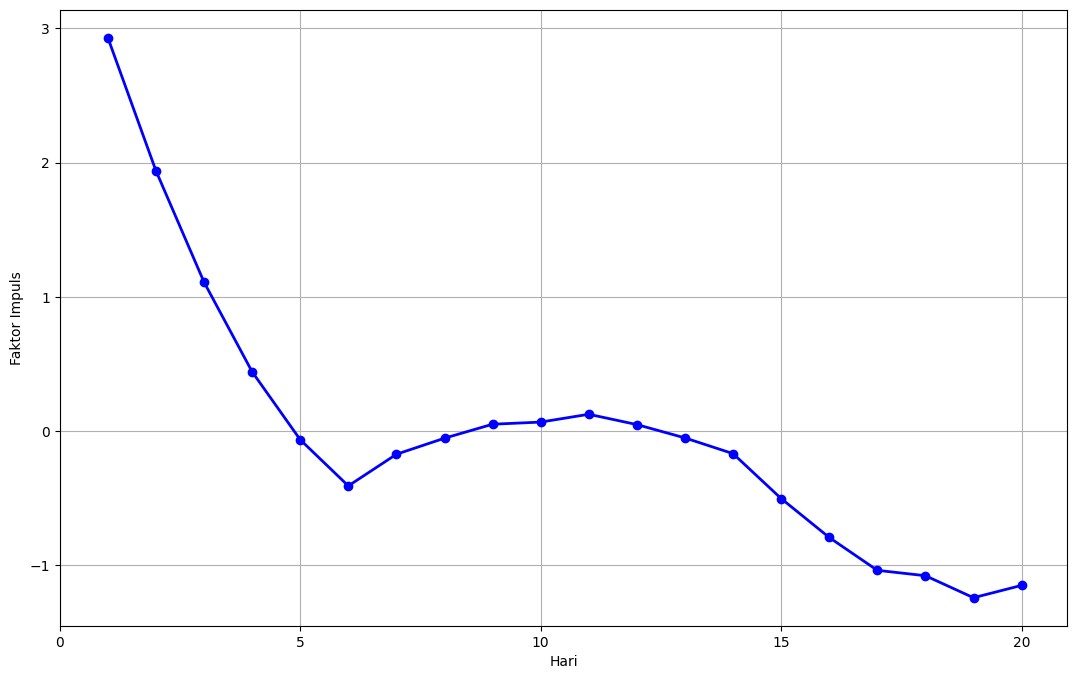

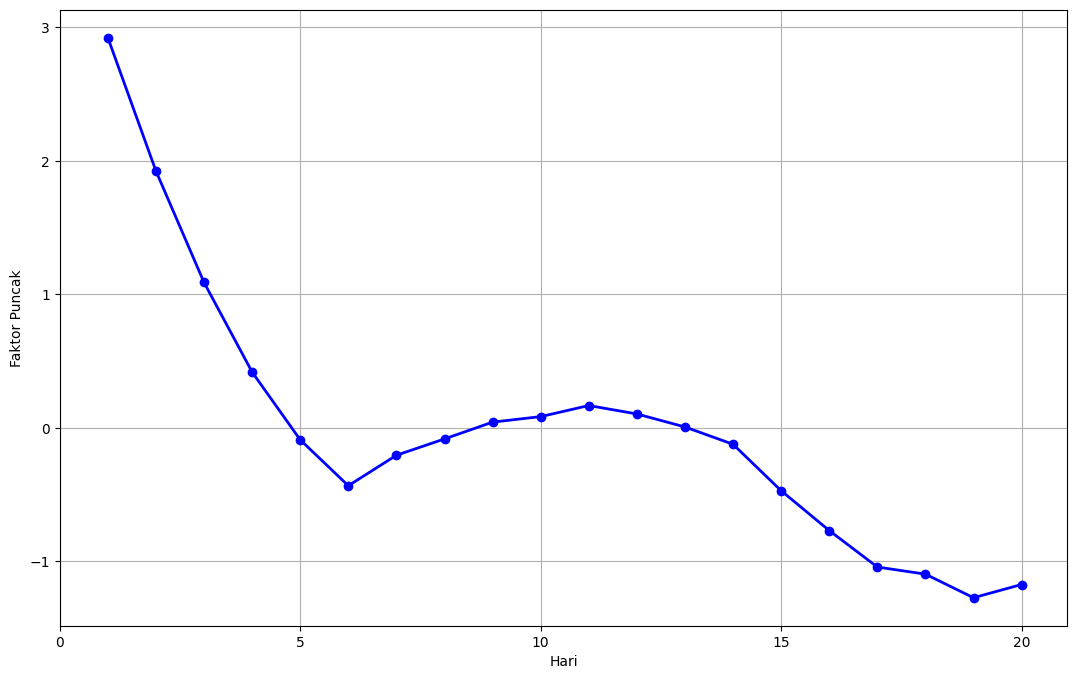

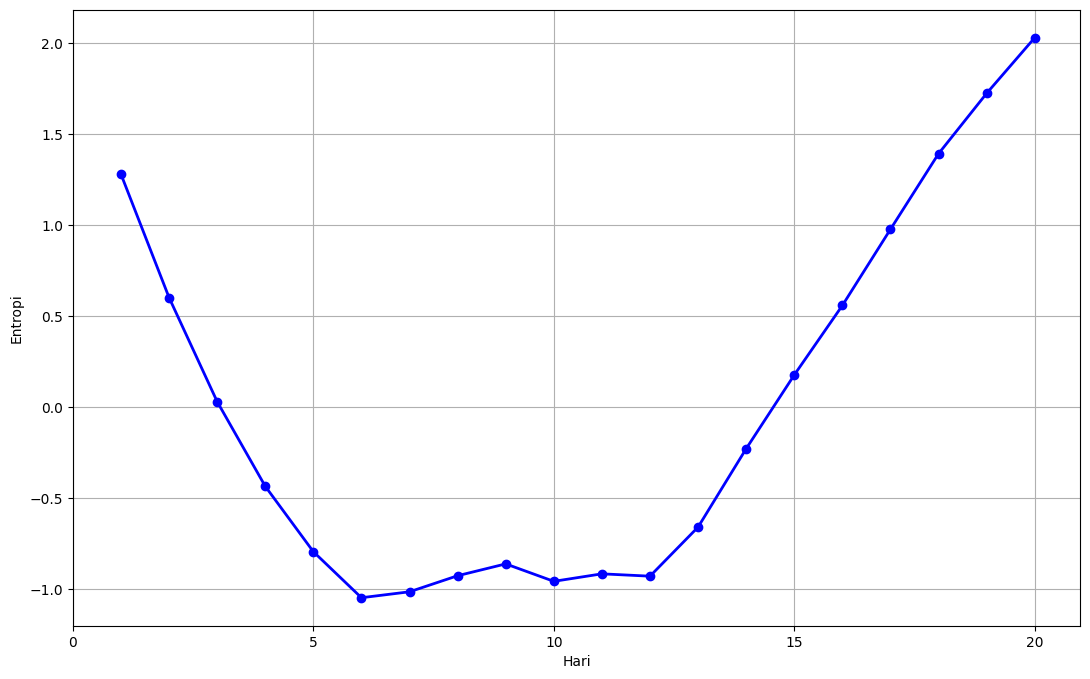

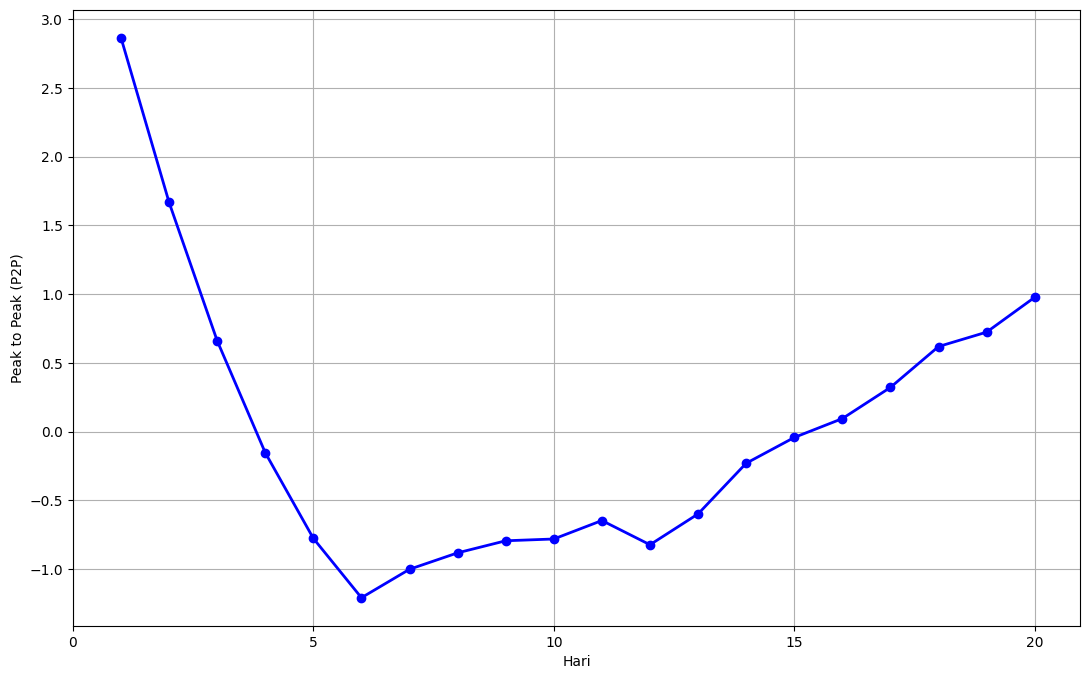

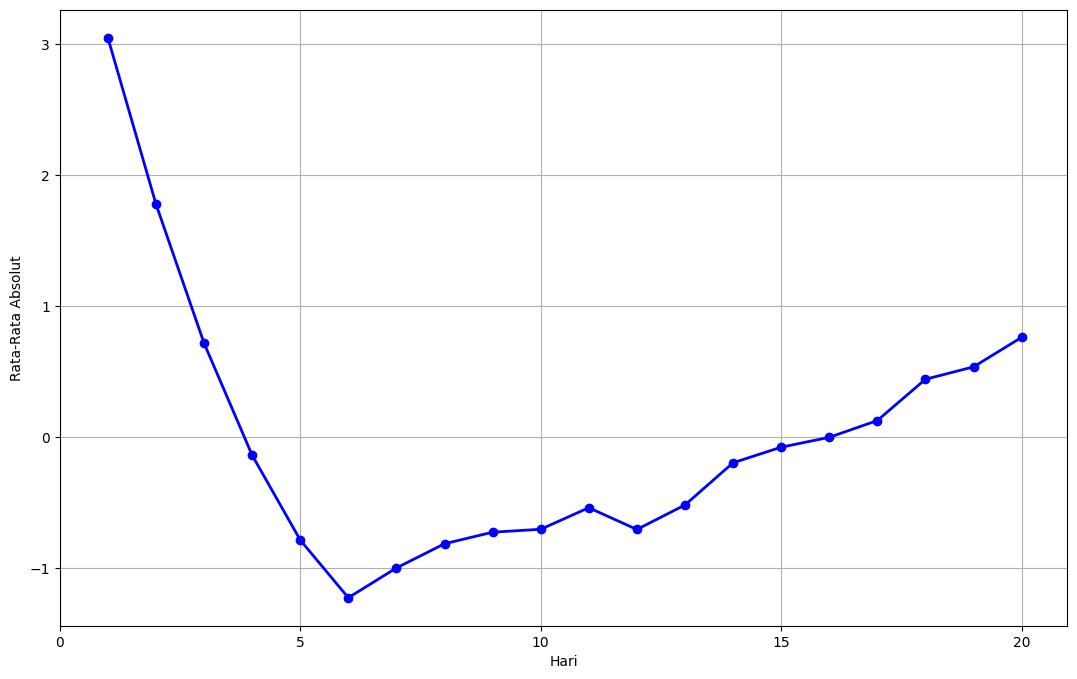

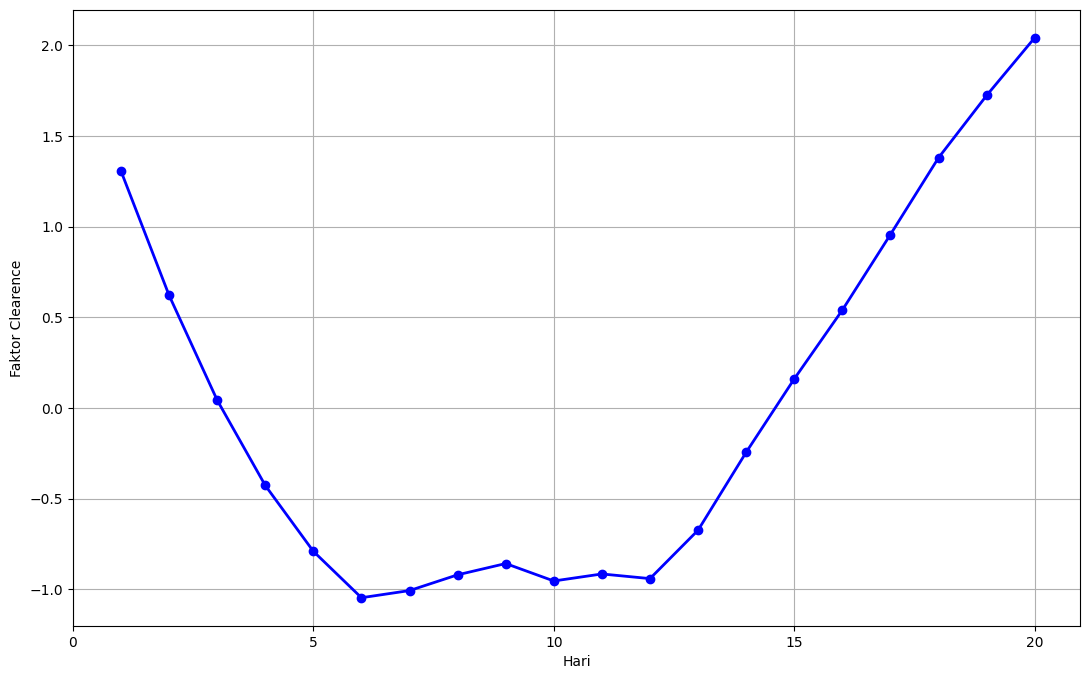

In [287]:
hi.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(hi.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(hi.index+1, hi[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,21,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

In [288]:
PCA_loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=hi.columns)
PCA_loadings

PCA1      PCA2
Faktor Impuls       0.256897 -0.581722
Faktor Puncak       0.253460 -0.584568
Entropi             0.413407  0.399472
Peak to Peak (P2P)  0.514101  0.005642
Rata-Rata Absolut   0.511340 -0.067662
Faktor Clearence    0.416039  0.394579

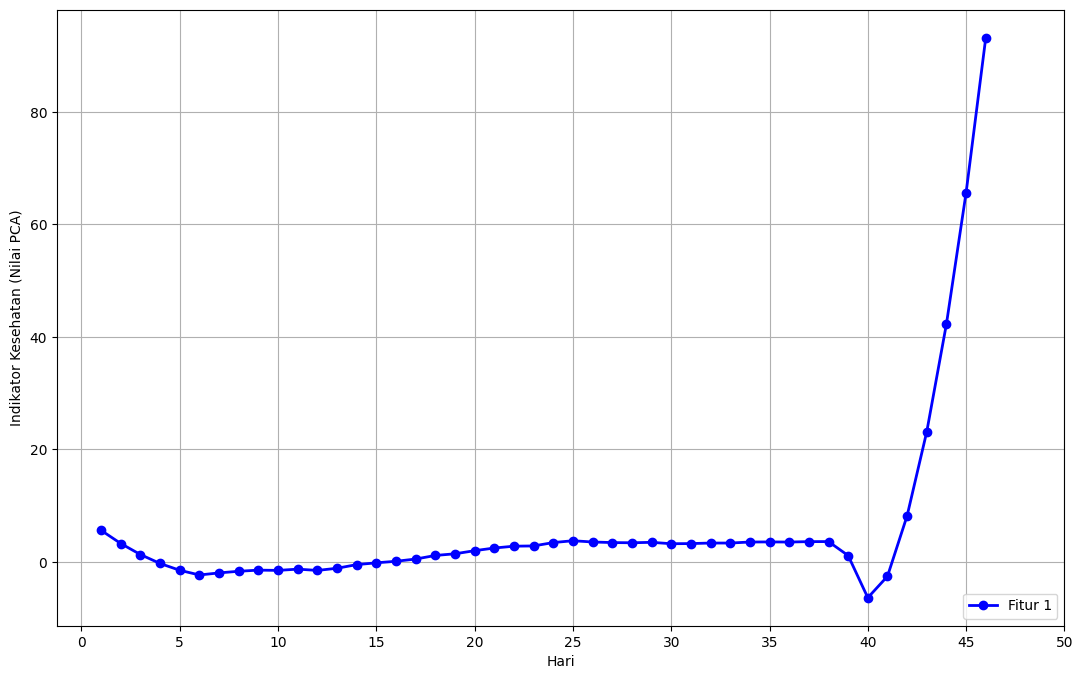

In [289]:
# Membuat fungsi PCA dengan 3 Principal Component 
# svd_solver = full ==> run exact full SVD calling the standard LAPACK solver via scipy.linalg.svd and select the components by postprocessing
PCA_loadings = PCA_loadings.loc[:,['PCA1']]
smoothing_savgolfilter = pd.DataFrame(scaler.transform(smoothing_savgolfilter)) # Fitting scaler pada X_train

# Fitting dan transform train data dengan PCA
smoothing_savgolfilter_PCA= np.dot(smoothing_savgolfilter, PCA_loadings)
smoothing_savgolfilter_PCA = pd.DataFrame(smoothing_savgolfilter_PCA, columns =['Fitur 1'])

# Variabel days_cycle dan RUL akan ditambahkan pada dataframe dari data smoothing yang dipilih
plt.figure(figsize=(13,8))
hi_plot = plt.plot(smoothing_savgolfilter_PCA.index+1, smoothing_savgolfilter_PCA['Fitur 1'], linestyle='-', marker='o', color='b', linewidth=2)
plt.xticks(np.arange(0,51,step=5))
plt.legend(['Fitur 1'], loc=4)
plt.ylabel('Indikator Kesehatan (Nilai PCA)')
plt.xlabel('Hari')
plt.grid()

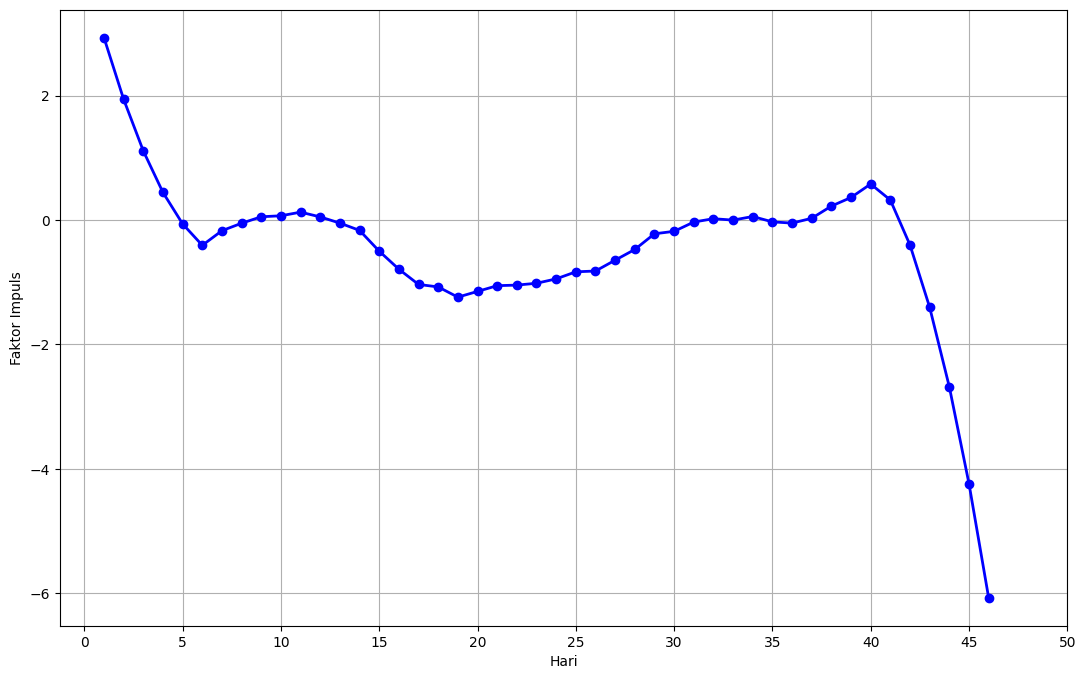

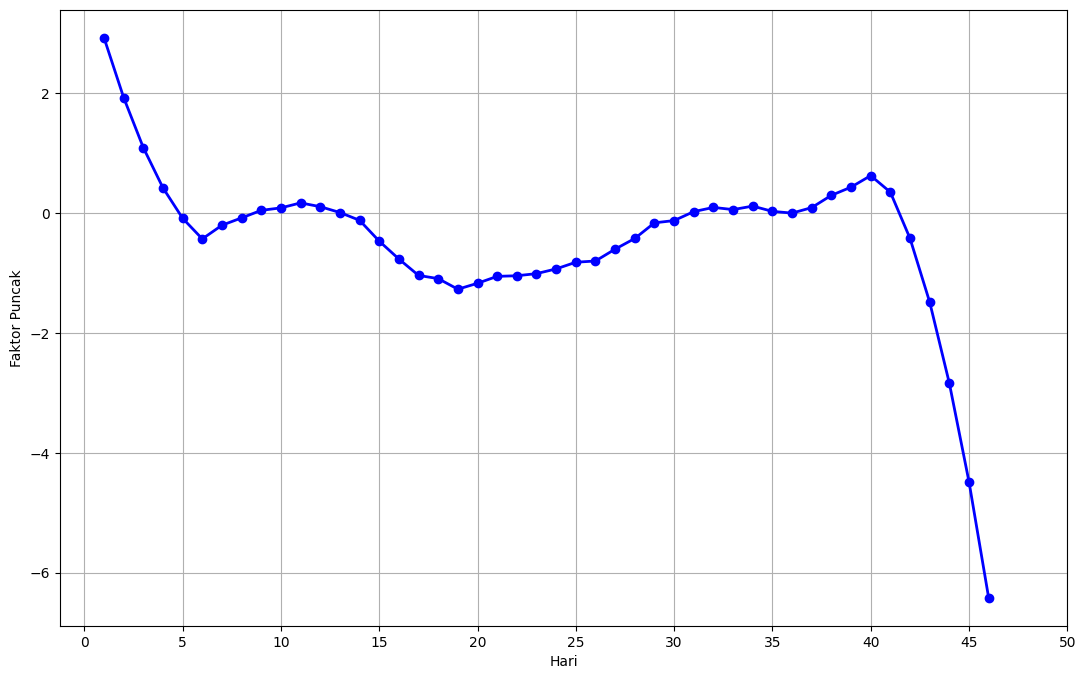

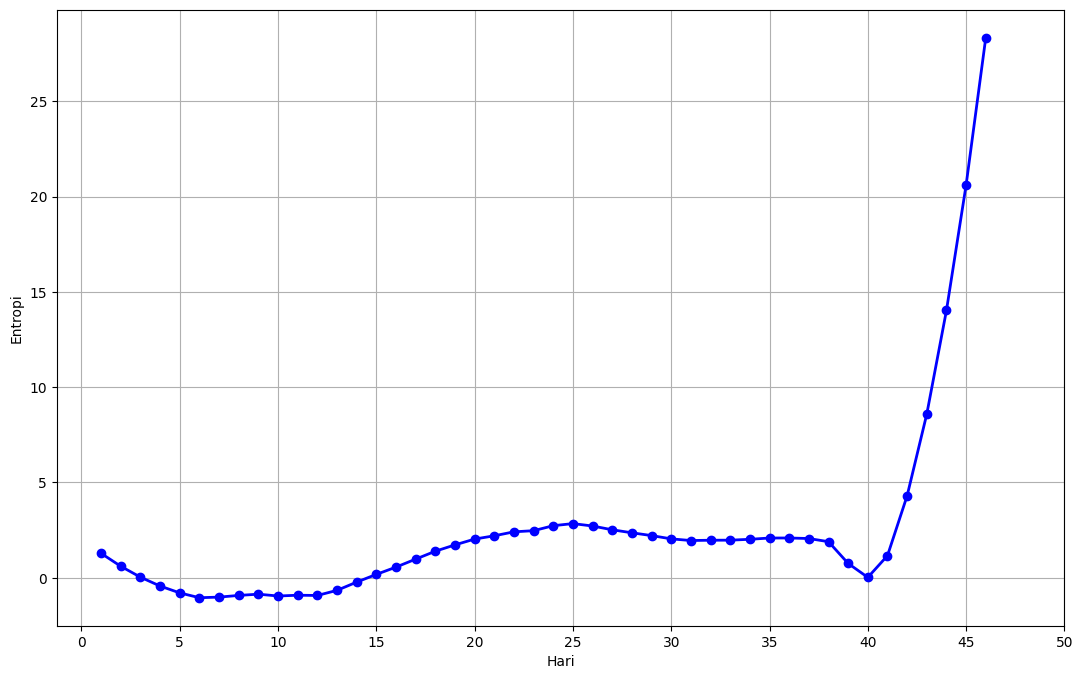

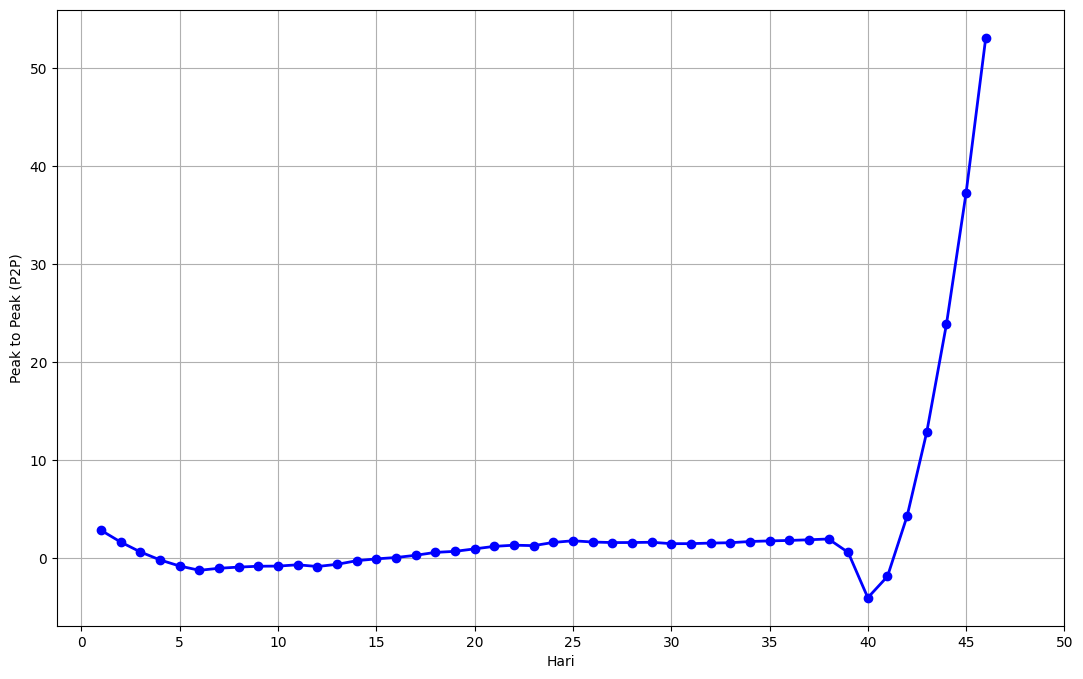

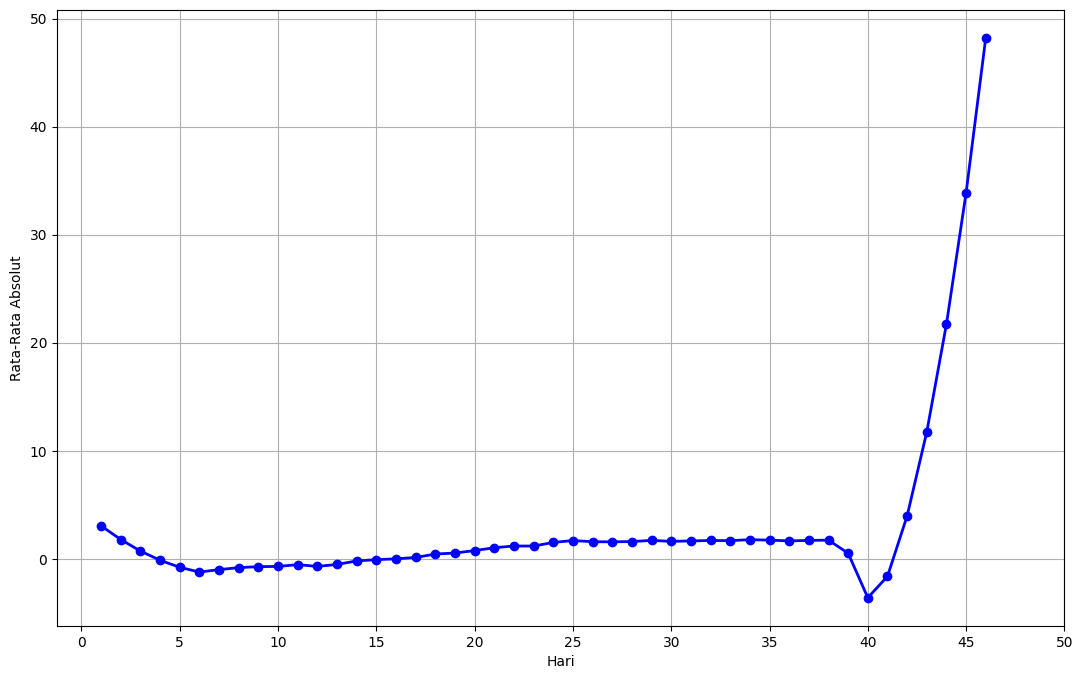

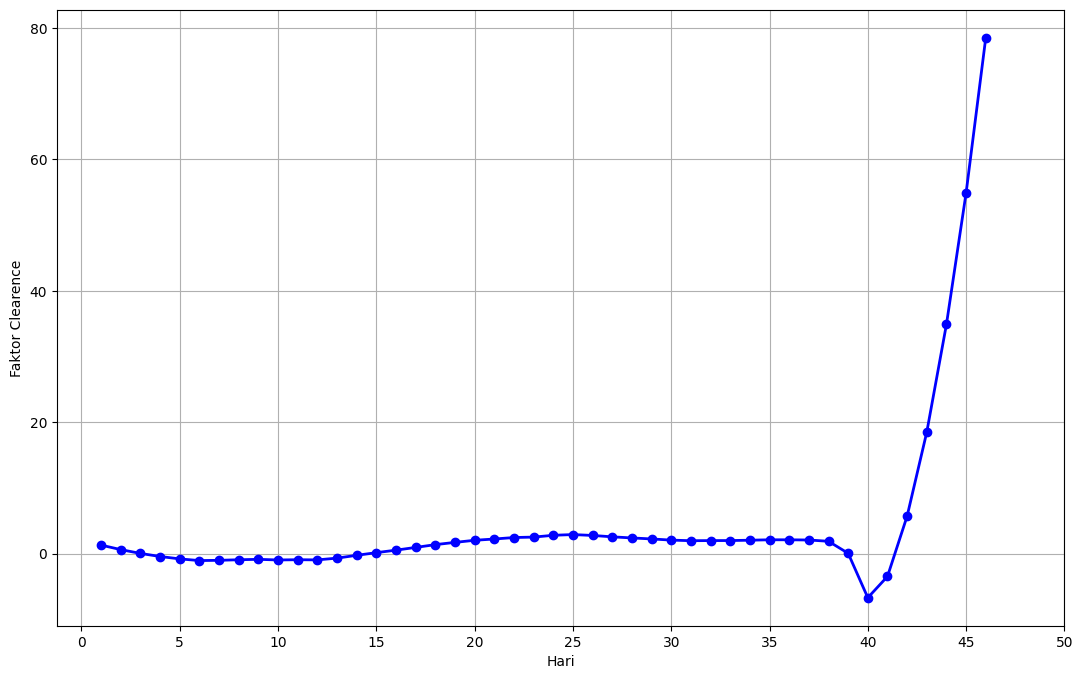

In [290]:
smoothing_savgolfilter.rename(columns={0:'Faktor Impuls', 1:'Faktor Puncak', 2:'Entropi', 3:'Peak to Peak (P2P)', 4:'Rata-Rata Absolut', 5:'Faktor Clearence'}, inplace=True)
columns = list(smoothing_savgolfilter.columns)
# Seluruh hasil data smoothing dan dataframe time_features dibuat dalam satu grafik untuk masing-masing variabel
for tf in columns: # Iterasi untuk tiap variabel pada list
  plt.figure(figsize=(13, 8)) # Ukuran plot
  Features = plt.plot(smoothing_savgolfilter.index+1, smoothing_savgolfilter[[tf]], linestyle='-', marker='o', color='b', linewidth=2)
  plt.xticks(np.arange(0,51,step=5))
  plt.ylabel(tf)
  plt.xlabel('Hari')
  plt.grid()

## Pembuatan Model SVR

### Model SVR Tanpa PCA

#### Perhitungan Nilai RUL

In [291]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 46 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_savgolfilter['RUL'] = np.asarray(RUL).flatten()

#### Pembagian Data Train dan Test

In [292]:
train_data = smoothing_savgolfilter.iloc[0:20] # Pembagian training data
test_data = smoothing_savgolfilter.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier

In [293]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:2.508859013050128, R2:0.8106955324101395
test set RMSE:27.407402550084633, R2:-12.354057147420189


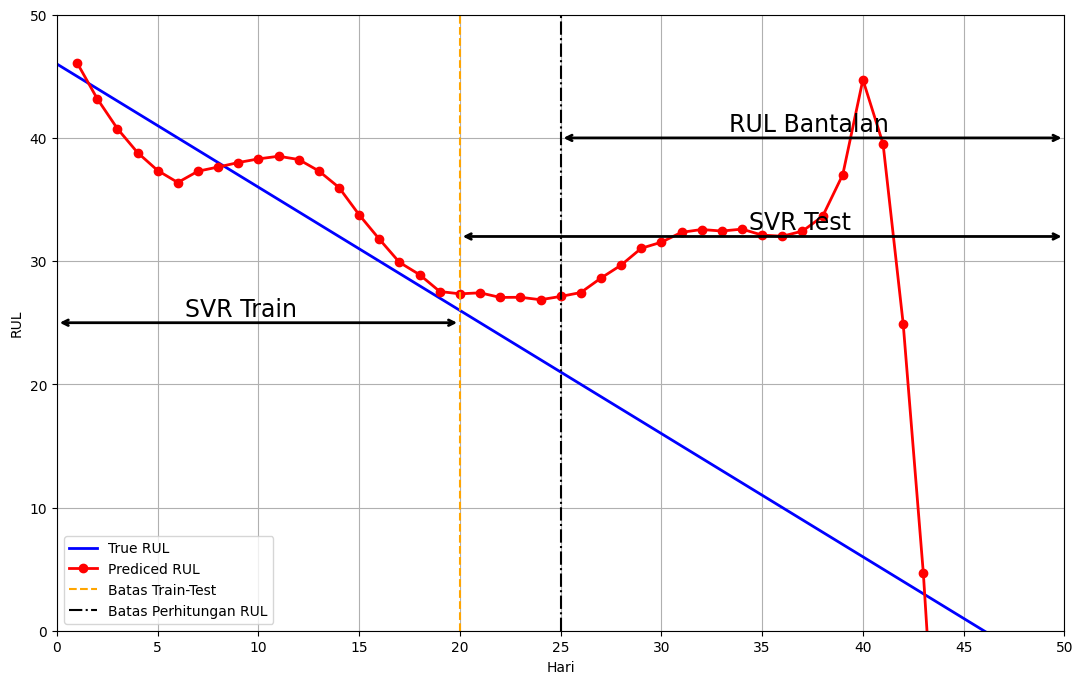

In [294]:
y_predSF_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_savgolfilter.index+1, y_predSF_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna

In [295]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    result = mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return result # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 50 kali

[I 2023-04-10 19:07:26,783] A new study created in memory with name: no-name-b5e22aa2-ef59-41c4-b3d4-3964cfba9574
[I 2023-04-10 19:07:26,797] Trial 0 finished with value: 23.09225937905496 and parameters: {'kernel': 'poly', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.31, 'coef0': 0.29000000000000004}. Best is trial 0 with value: 23.09225937905496.
[I 2023-04-10 19:07:26,809] Trial 1 finished with value: 23.112156231030816 and parameters: {'kernel': 'poly', 'degree': 1, 'gamma': 'auto', 'epsilon': 0.36000000000000004, 'coef0': 0.11}. Best is trial 0 with value: 23.09225937905496.
[I 2023-04-10 19:07:26,822] Trial 2 finished with value: 20.05596158178339 and parameters: {'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'epsilon': 0.19, 'coef0': 0.13}. Best is trial 2 with value: 20.05596158178339.
[I 2023-04-10 19:07:26,831] Trial 3 finished with value: 23.005802654915072 and parameters: {'kernel': 'poly', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.09, 'coef0': 0.24000000000000002}. 

In [296]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 16.949673585305277
Best Parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'epsilon': 0.09, 'coef0': 0.31}


In [297]:
# Pembuatan model dengan SVR
svr = SVR(kernel='poly', degree=1, gamma='auto', epsilon=0.04, coef0=0.4) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:2.998282978952697, R2:0.7296330579886479
test set RMSE:22.986400269553947, R2:-8.39332617514933


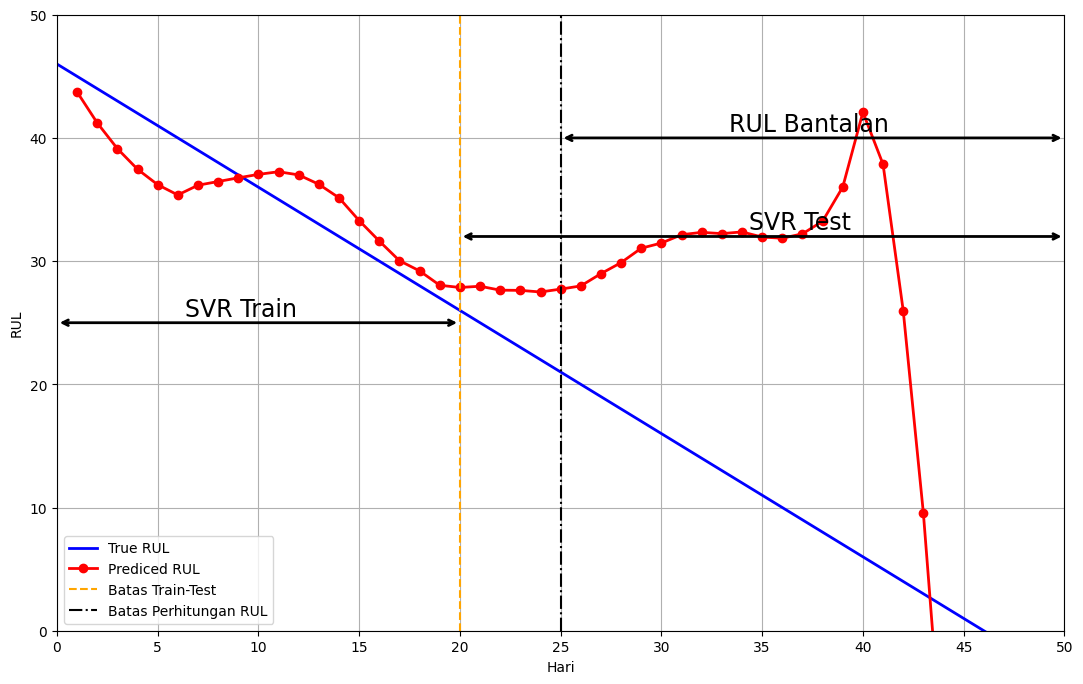

In [298]:
y_predSF_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_savgolfilter.index+1, y_predSF_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

### Model SVR Dengan PCA Savgol Filter

#### Perhitungan Nilai RUL

In [299]:
RUL = [] # List kosong untuk RUL
for i in range (46,0,-1): # Membuat iterasi angka dari 46 hingga 1
  RUL.append(i) # Setiap iterasi dimasukkan ke dalam list RUL
smoothing_savgolfilter_PCA['RUL'] = np.asarray(RUL).flatten() # Memasukkan list days_cycle ke dalam dataframe Simple Exponential Smoothing

#### Pembagian Data untuk Train dan Test

In [300]:
train_data = smoothing_savgolfilter_PCA.iloc[0:20] # Pembagian training data
test_data = smoothing_savgolfilter_PCA.iloc[20:] # Pembagian test data

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_train = train_data # Penghapusan kolom dari dataset train dan dijadikan variabel baru
y_train = X_train.pop('RUL') # Penghapusan kolom RUL dari X_train

# List time_features yang tidak digunakan karena berdasarkan mendapatkan skor rendah dari goodness metric
X_test = test_data  # Penghapusan kolom dari dataset test dan dijadikan variabel baru
y_test = X_test.pop('RUL') # Penghapusan kolom RUL dari X_test

#### Model SVR Linier Savgol Filter

In [301]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear') # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:6.557738530169116, R2:-0.2933514174455518
test set RMSE:23.41963724512318, R2:-8.75074504343397


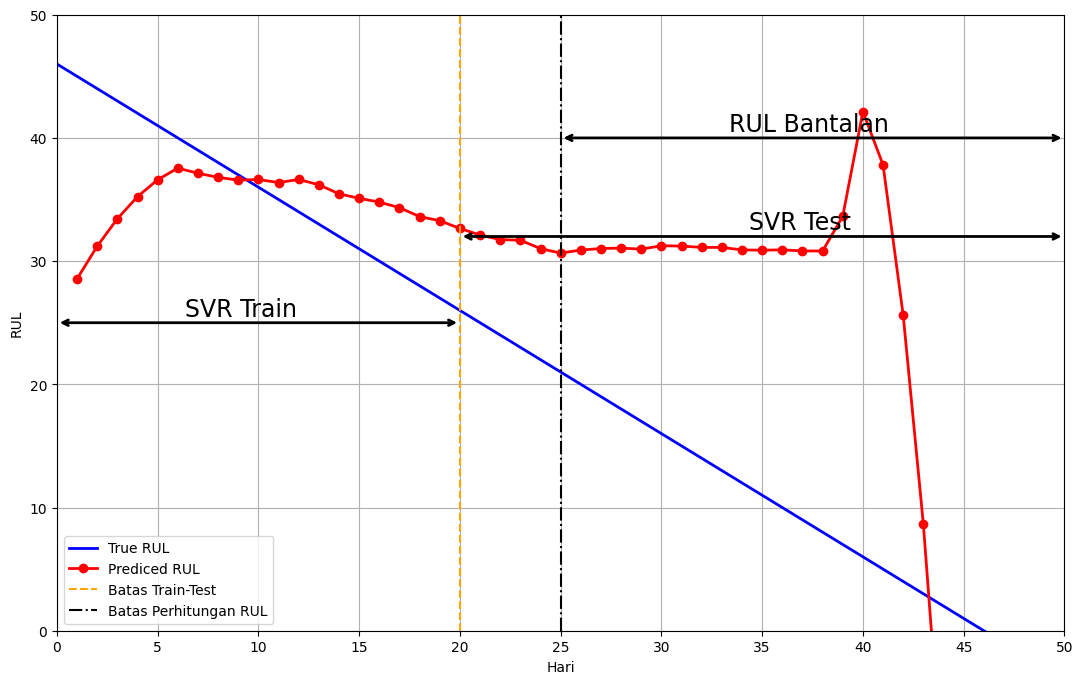

In [302]:
y_predSFPCA_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_savgolfilter_PCA.index+1, y_predSFPCA_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

#### Model SVR Optuna Savgol Filter


In [303]:
# Pembuatan fungsi untuk mencari parameter terbaik dengan menggunkan library Optuna
def objective(trial):
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']) # Parameter kernel dari SVR
    degree = trial.suggest_int("degree", 1,4) # Parameter degree dari SVR
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) # Parameter gamma dari SVR
    epsilon = trial.suggest_float('epsilon', 0.01, 0.4, step=0.01) # Parameter epsilon dari SVR
    # Apabila kernel yang digunakan 'poly' maka variasi untuk parameter coef0 
    if kernel == "poly":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan 'sigmoid' maka variasi untuk parameter coef0
    elif kernel =="sigmoid":
      coef0 = trial.suggest_float('coef0', 0.01, 0.4, step=0.01)
    # Apabila kernel yang digunakan selain 'poly' dan 'sigmoid' maka parameter coef0 == 0.0
    else:
      coef0 = 0.0   
    
    # Pembuatan model SVR dengan parameter yang sudah ditentukan
    model = SVR(kernel=kernel, degree=degree, gamma=gamma, epsilon=epsilon, coef0=coef0)
    model.fit(X_train, y_train) # Fitting model terhadap X_train_transformed dan y_train_clipped
    preds = model.predict(X_test) # Melakukan prediksi pada X_test_transformed
    mean_squared_error(y_test, preds, squared=False) # Perhitungan MSE untuk menilai performa algortima dengan parameter yang digunakan
    return mean_squared_error(y_test, preds, squared=False) # Menampilkan hasil MSE

study = optuna.create_study(direction="minimize") # Pembuatan study untuk Optuna dengan tujuan mencari performa paling maksimal dengan paramter tertentu
study.optimize(objective, n_trials=1000) # Menggunakan iterasi sebanyak 1000 kali

[I 2023-04-10 19:08:36,555] A new study created in memory with name: no-name-3fdd5bdf-f4ed-4858-8bcd-415fcb2617ea
[I 2023-04-10 19:08:36,574] Trial 0 finished with value: 20.674509653684176 and parameters: {'kernel': 'sigmoid', 'degree': 1, 'gamma': 'scale', 'epsilon': 0.28, 'coef0': 0.13}. Best is trial 0 with value: 20.674509653684176.
[I 2023-04-10 19:08:36,583] Trial 1 finished with value: 20.718555899513706 and parameters: {'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'epsilon': 0.35000000000000003, 'coef0': 0.2}. Best is trial 0 with value: 20.674509653684176.
[I 2023-04-10 19:08:36,591] Trial 2 finished with value: 23.41963724512318 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'scale', 'epsilon': 0.15000000000000002}. Best is trial 0 with value: 20.674509653684176.
[I 2023-04-10 19:08:36,598] Trial 3 finished with value: 23.149633569600045 and parameters: {'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'epsilon': 0.12}. Best is trial 0 with value: 20.6745096

In [304]:
# Melihat parameter terbaik untuk algortima SVR
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best Parameters: {}'.format(trial.params))

Accuracy: 18.54222490496665
Best Parameters: {'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto', 'epsilon': 0.24000000000000002, 'coef0': 0.01}


In [305]:
# Pembuatan model dengan SVR
svr = SVR(kernel='linear', degree=1, gamma='auto', epsilon=0.09, coef0=0.01) # Pendefinisian algortima SVR dengan kernel linear
svr.fit(X_train, y_train) # Fitting terhadap X_train_scaled dan y_train

y_pred_train = svr.predict(X_train) # Melakukan prediksi pada train set
evaluate(y_train, y_pred_train, 'train') # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

y_pred_test = svr.predict(X_test) # Melakukan prediksi pada test set
evaluate(y_test, y_pred_test) # Menghitung nilai RMSE dan R2 dengan fungsi evaluate

train set RMSE:6.557738530169116, R2:-0.2933514174455518
test set RMSE:23.41963724512318, R2:-8.75074504343397


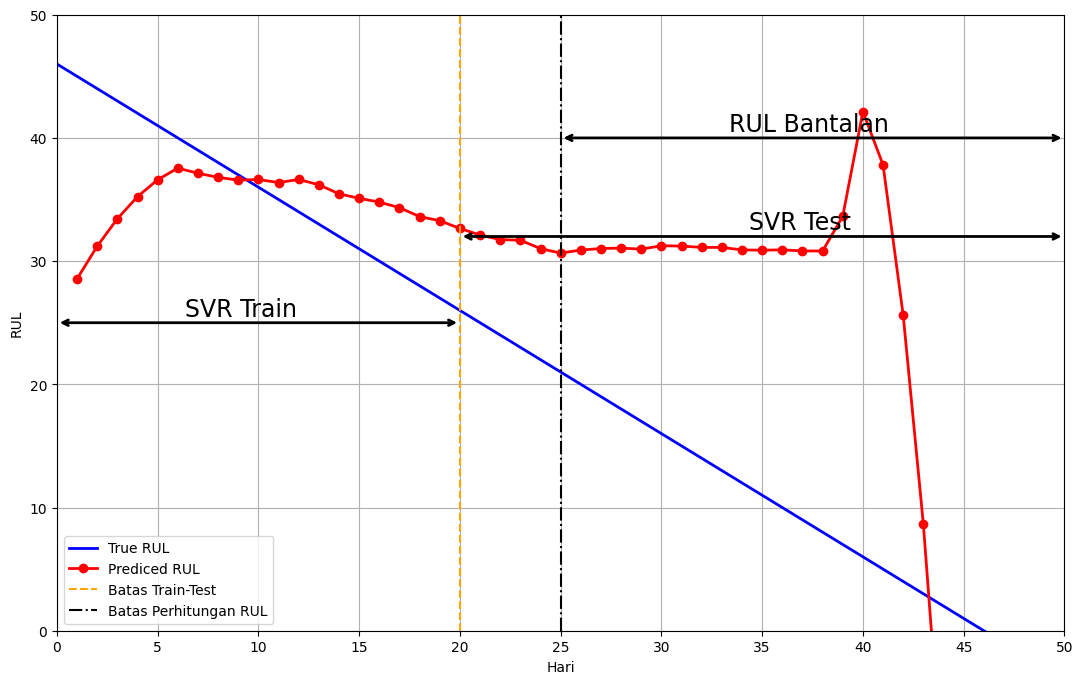

In [306]:
y_predSFPCA_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_savgolfilter_PCA.index+1, y_predSFPCA_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

# Grafik

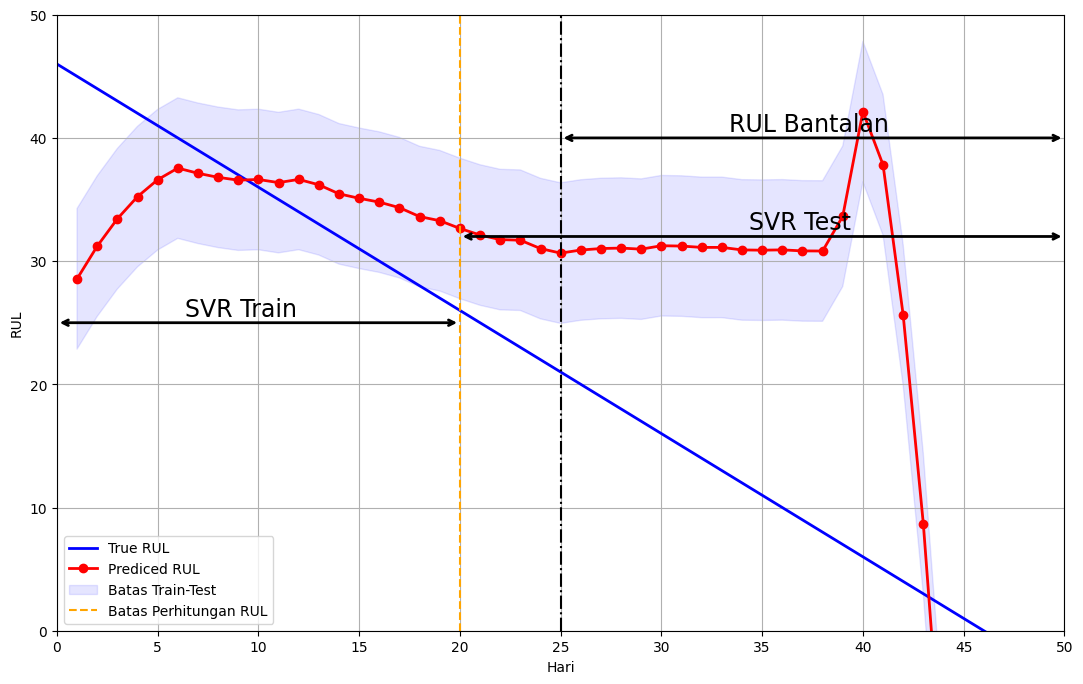

In [307]:
y_predSF_linier = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_savgolfilter_PCA.index+1, y_predSF_linier, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
ci = 1.96 * np.std(y_predSF_linier)/np.sqrt(len(smoothing_savgolfilter_PCA.index+1))
confidence_interval = plt.fill_between(smoothing_savgolfilter_PCA.index+1, (y_predSF_linier-ci), (y_predSF_linier+ci), color='blue', alpha=0.1)
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)

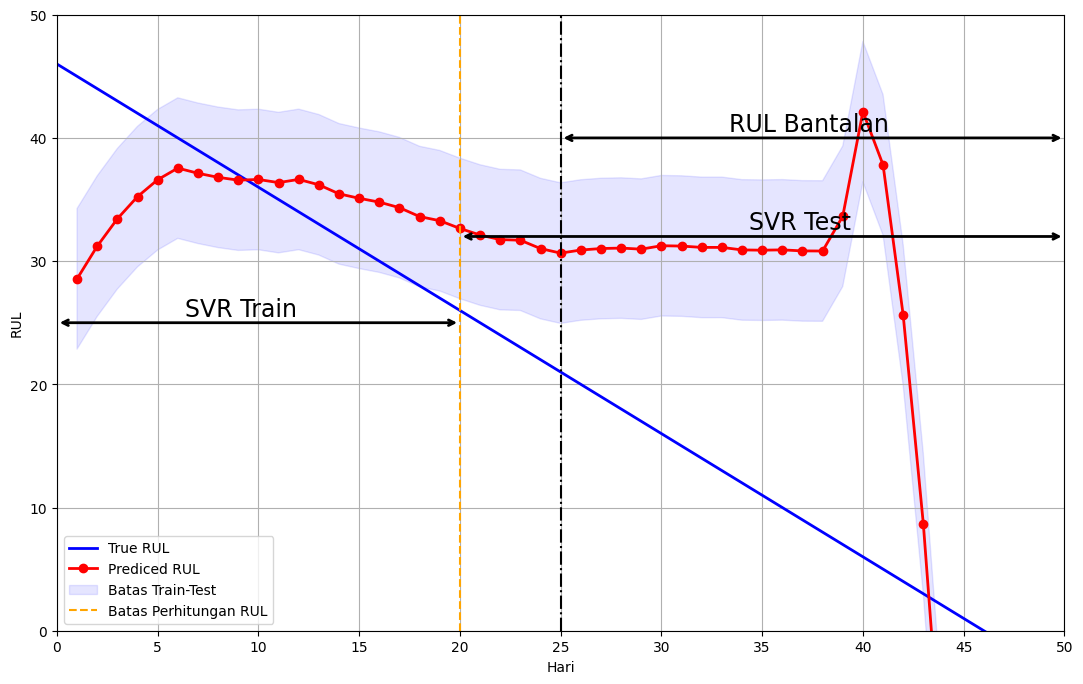

In [308]:
y_predSFPCA_optuna = np.concatenate((y_pred_train, y_pred_test))
plt.figure(figsize=(13, 8)) # Ukuran plot
true_RUL = plt.plot(RUL_Aktual.index,RUL_Aktual['RUL Aktual'], linestyle='-', color='b', linewidth=2) # Pembuatan plot dari dataframe time_features
pred_RUL = plt.plot(smoothing_savgolfilter_PCA.index+1, y_predSFPCA_optuna, linestyle='-', marker='o', color='red', linewidth=2) # Pembuatan plot dari dataframe Simple Moving Average
ci = 1.96 * np.std(y_predSFPCA_optuna)/np.sqrt(len(smoothing_savgolfilter_PCA.index+1))
confidence_interval = plt.fill_between(smoothing_savgolfilter_PCA.index+1, (y_predSFPCA_optuna-ci), (y_predSFPCA_optuna+ci), color='blue', alpha=0.1)
plt.xticks(np.arange(0,51,step=5))
plt.xlim(0,50)
plt.ylim(0,50)
plt.axvline(x = 20, color = 'orange', linestyle='--')
plt.axvline(x = 25, color = 'black', linestyle='-.')
plt.annotate('', xy=(25, 40), xycoords='data',
    xytext=(50, 40), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'RUL Bantalan', xy=(33, 40), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(20, 32), xycoords='data',
    xytext=(50, 32), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Test', xy=(34, 32), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.annotate('', xy=(0, 25), xycoords='data',
    xytext=(20, 25), textcoords='data',
    arrowprops=dict(arrowstyle= '<->', linewidth=2))
plt.annotate(
    'SVR Train', xy=(6, 25), xycoords='data',
    xytext=(5, 5), textcoords='offset points', size=17)
plt.ylabel('RUL')
plt.xlabel('Hari')
plt.grid()
plt.legend(['True RUL','Prediced RUL', 'Batas Train-Test', 'Batas Perhitungan RUL'], loc=3)
plt.show()